In [1]:
# Modèle 3 : LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance

import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


###### package courant pour le machine learning ######

import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# # theano
# import theano
# print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

def read(file_name):
    xl = 0
    try:
        df = pd.read_excel(f"data/{file_name}.xlsx")
        xl = 1
    except:
        df = pd.read_csv(f"data/{file_name}.csv", sep='|', encoding='utf-8', on_bad_lines='skip')
        xl = 0

    df.columns = df.columns.str.lower()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if xl:
            df['year'] = df['date'].dt.year
    return df

scipy: 1.15.3
numpy: 2.3.1
matplotlib: 3.10.3
pandas: 2.3.0
statsmodels: 0.14.4
sklearn: 1.7.0
tensorflow: 2.20.0
keras: 3.10.0


In [84]:
data = pd.read_csv('data/df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

# GDPQ = pd.read_csv('GDP Quarter.csv',sep=',')
# GDPQ['date'] = pd.to_datetime(GDPQ['timestamp'])
# GDPQ['year'] = GDPQ['date'].dt.year
# GDPQ['month'] = GDPQ['date'].dt.month

# GDPQ_full = []
# for _, row in GDPQ.iterrows():
#     for m in range(row['date'].quarter * 3 - 2, row['date'].quarter * 3 + 1):
#         GDPQ_full.append({'year': row['year'], 'month': m, 'CroissQ': row['CroissQ']})
# GDPQ_full = pd.DataFrame(GDPQ_full)


data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
#data = data.merge(GDPQ, on=['year', 'month'], how='left')
#data.drop(['timestamp_x','date_y','timestamp_y', 'date'], axis=1, inplace=True)
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
data.rename(columns = {'date_x': 'date'}, inplace = True)
data.set_index('date', inplace=True)
# data['mid'] = (data['high'] + data['low']) / 2
# data['range'] = data['high'] -data['low']

data['jour_semaine'] = data.index.dayofweek
data['mois'] = data.index.month

data.columns = data.columns.str.lower()

dataa = data.copy()

[*********************100%***********************]  1 of 1 completed


In [27]:
dataa

,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,rsi_3d,...,close_minus_20d,close_minus_30d,close_minus_50d,close_minus_100d,close_minus_200d,dxy,eia/gdpqxus/usa,croissm,jour_semaine,mois
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,1228.10,1.398027,1248.81,1219.10,27.8209,-14.0,1195.63,43.6168,0.037428,51.21,...,32.47,40.12,71.35,0.0000,0.00000,93.440002,13315.597,123.927000,0,1
1999-01-05,1244.78,1.254373,1246.11,1228.10,28.1988,173.0,1199.03,43.6168,0.052075,80.72,...,45.75,53.73,84.71,0.0000,0.00000,93.470001,13315.597,123.927000,1,1
1999-01-06,1272.34,1.566773,1272.50,1244.78,28.8231,313.0,1203.26,43.6168,0.282519,92.29,...,69.08,77.66,108.23,0.0000,0.00000,94.529999,13315.597,123.927000,2,1
1999-01-07,1269.73,1.351569,1272.34,1257.68,28.7640,-172.0,1207.68,43.6168,0.077112,85.04,...,62.05,72.33,101.67,0.0000,0.00000,93.720001,13315.597,123.927000,3,1
1999-01-08,1275.09,1.455050,1278.05,1261.85,28.8857,77.0,1212.26,43.5434,0.000000,87.95,...,62.83,74.62,102.84,0.0000,0.00000,94.349998,13315.597,123.927000,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-12,6584.29,0.914048,6600.21,6579.49,27.4007,-269.0,6472.55,264.7617,0.269140,87.19,...,111.74,146.06,199.40,457.9858,599.36400,97.550003,23785.330,32.422211,4,9
2025-09-15,6615.28,0.881635,6619.62,6602.07,27.5297,-99.0,6480.82,264.8023,1.483275,92.29,...,134.46,164.47,223.67,475.7006,627.12430,97.300003,23785.330,32.422211,0,9
2025-09-16,6606.76,0.978096,6626.99,6600.11,27.4942,-123.0,6488.70,264.8158,0.236378,79.27,...,118.06,146.73,207.62,454.8716,615.50735,96.629997,23785.330,32.422211,1,9


In [3]:
pd.DataFrame(dataa.columns)

,0
0,close
1,volume
2,high
3,low
4,pe
5,num_daily_adv_minus_decl
6,mov_avg_20d
7,best_eps
8,dvd_sh_last
9,rsi_3d


In [6]:
# Fixer la graine pour Python, NumPy, et TensorFlow


seed = int(time.time()) % 2**32  # ou random.randint(0, 2**32 - 1)
# 1759607359
seed = 1759608945
# Fixer le seed
random.seed(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Afficher le seed utilisé
print(f"Seed utilisé pour cette exécution : {seed}")

# (Optionnel) Forcer une exécution déterministe
# Cela peut ralentir l'entraînement, mais rend encore plus reproductible
# os.environ["TF_DETERMINISTIC_OPS"] = "1"


df = dataa.copy()

early_stop = EarlyStopping(
    monitor='val_loss',   # Sur quelle métrique surveiller l'amélioration
    patience=30,          # Nombre d'époques sans amélioration avant arrêt
    verbose=1,            # Affiche un message quand l'arrêt se produit
    restore_best_weights=True  # Restaure les poids correspondant à la meilleure val_loss
)

# Paramètres
seq_len = 30  # Longueur de séquence temporelle

# Normalisation
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Création des séquences
X, y = [], []
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len, df.columns.get_loc('cible')])
X, y = np.array(X), np.array(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_len, df.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Entraînement validation size
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, verbose=1, callbacks=[early_stop])

# Prédiction
predictions = model.predict(X_test)

Seed utilisé pour cette exécution : 1759608945
Epoch 1/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - val_loss: 3.8018e-04
Epoch 2/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7018e-05 - val_loss: 3.1986e-04
Epoch 3/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6256e-05 - val_loss: 3.7155e-04
Epoch 4/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0362e-05 - val_loss: 4.3219e-04
Epoch 5/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9044e-05 - val_loss: 3.9146e-04
Epoch 6/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7327e-05 - val_loss: 4.0349e-04
Epoch 7/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7375e-05 - val_loss: 4.3182e-04
Epoch 8/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7489e-05 - val_loss: 4.5929e-04
Epoch 9/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7219e-05 - val_loss: 4.6946e-04
Epoch 10/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6278e-05 - val_loss: 4.7607e-04
Epoch 

MSE: 313720.0251
MAE: 497.0930
R²: 0.5751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Prochaine valeur prédite: 5797.2790


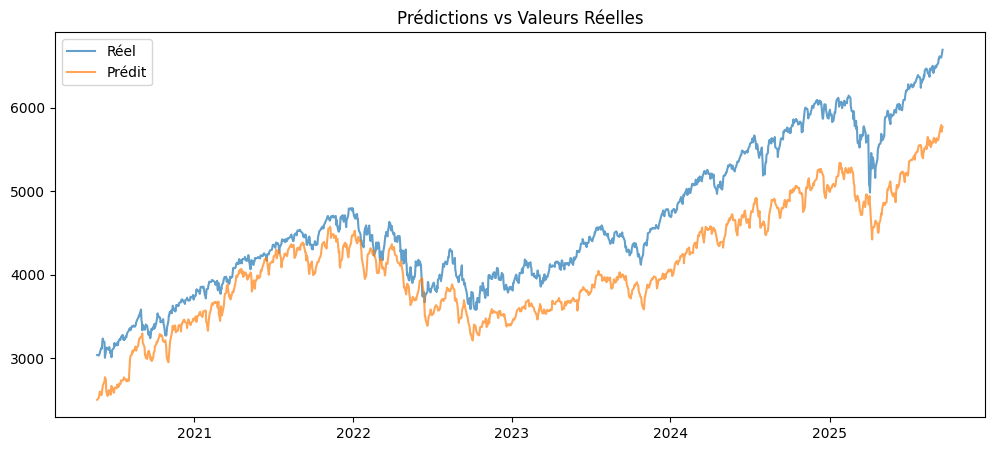

In [7]:
# Dénormaliser les prédictions
cible_idx = df.columns.get_loc('cible')
pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), cible_idx)), 
                                                        predictions, 
                                                        np.zeros((len(predictions), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]
y_test_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), cible_idx)), 
                                                          y_test.reshape(-1,1), 
                                                          np.zeros((len(y_test), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"MSE: {mean_squared_error(y_test_denorm, pred_denorm):.4f}")
print(f"MAE: {mean_absolute_error(y_test_denorm, pred_denorm):.4f}")
print(f"R²: {r2_score(y_test_denorm, pred_denorm):.4f}")

# Prédire le prochain point (future)
derniere_seq = data[-seq_len:].reshape(1, seq_len, df.shape[1])
next_pred = model.predict(derniere_seq)
next_pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((1, cible_idx)), 
                                                             next_pred, 
                                                             np.zeros((1, df.shape[1]-cible_idx-1))], axis=1))[0, cible_idx]
print(f"\nProchaine valeur prédite: {next_pred_denorm:.4f}")

# Visualisation (optionnel)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df.iloc[-len(y_test_denorm):].index, y_test_denorm, label='Réel', alpha=0.7)
plt.plot(df.iloc[-len(y_test_denorm):].index, pred_denorm, label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [63]:
results = pd.concat([pd.DataFrame(df.iloc[-len(y_test_denorm):].index, columns = ['date']), pd.DataFrame(pred_denorm, columns = ['pred']), pd.DataFrame(y_test_denorm, columns = ['real'])], axis=1)
results['diff'] = results['real'] - results['pred']
results

,date,pred,real,diff
0,2020-05-22,3014.606629,3036.13,21.523371
1,2020-05-26,3042.891180,3029.73,-13.161180
2,2020-05-27,3043.421630,3044.31,0.888370
3,2020-05-28,3042.488232,3055.73,13.241768
4,2020-05-29,3034.852842,3080.82,45.967158
...,...,...,...,...
1333,2025-09-12,6652.890313,6606.76,-46.130313
1334,2025-09-15,6637.127459,6600.35,-36.777459
1335,2025-09-16,6667.818221,6631.96,-35.858221
1336,2025-09-17,6752.137479,6664.36,-87.777479


In [ ]:
import random
import numpy as np
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Générer un seed aléatoire pour cette exécution ---
seed = int(time.time()) % 2**32
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
print(f"Seed utilisé pour cette exécution : {seed}")

# --- Préparer les données ---
df = dataa.copy()
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# --- Hyperparamètres à tester ---
seq_lens = [10, 15, 30]
units_list = [50, 100]
batch_sizes = [16, 32]
learning_rates = 0.001

# --- EarlyStopping commun ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=0,
    restore_best_weights=True
)

# --- Suivi du meilleur modèle ---
best_val_loss = float('inf')
best_model_params = {}

# --- Boucle sur tous les hyperparamètres ---
for seq_len in seq_lens:
    # Création des séquences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, df.columns.get_loc('cible')])
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    for units in units_list:
        for batch_size in batch_sizes:
            lr = learning_rates
            # Réinitialiser le seed pour chaque combinaison
            random.seed(seed)
            np.random.seed(seed)
            tf.random.set_seed(seed)
            
            # Créer le modèle
            model = Sequential([
                LSTM(units, activation='relu', input_shape=(seq_len, df.shape[1])),
                Dense(1)
            ])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
            
            # Entraîner
            history = model.fit(
                X_train, y_train,
                epochs=200,
                batch_size=batch_size,
                validation_data=(X_test, y_test),
                verbose=0,
                callbacks=[early_stop]
            )
            
            val_loss = min(history.history['val_loss'])
            print(f"seq_len={seq_len}, units={units}, batch_size={batch_size}, lr={lr}, val_loss={val_loss:.6f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_params = {
                    'seq_len': seq_len,
                    'units': units,
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'seed': seed,
                    'model': model
                }

print("\nMeilleur modèle trouvé :")
print(best_model_params)
print(f"Validation Loss : {best_val_loss:.6f}")

# --- Pour reproduire ce modèle ---
best_seq_len = best_model_params['seq_len']
best_units = best_model_params['units']
best_batch_size = best_model_params['batch_size']
best_lr = best_model_params['learning_rate']
best_seed = best_model_params['seed']
best_model = best_model_params['model']

print(f"\nReproduire ce run avec seed : {best_seed} et seq_len : {best_seq_len}")


Seed utilisé pour cette exécution : 1759696931
seq_len=5, units=32, batch_size=16, lr=0.001, val_loss=0.000215
seq_len=5, units=32, batch_size=32, lr=0.001, val_loss=0.000372
seq_len=5, units=50, batch_size=16, lr=0.001, val_loss=0.000764
seq_len=5, units=50, batch_size=32, lr=0.001, val_loss=0.000262
seq_len=5, units=100, batch_size=16, lr=0.001, val_loss=0.000203
seq_len=5, units=100, batch_size=32, lr=0.001, val_loss=0.001303
seq_len=10, units=32, batch_size=16, lr=0.001, val_loss=0.000243
seq_len=10, units=32, batch_size=32, lr=0.001, val_loss=0.000259
seq_len=10, units=50, batch_size=16, lr=0.001, val_loss=0.000165
seq_len=10, units=50, batch_size=32, lr=0.001, val_loss=0.001292
seq_len=10, units=100, batch_size=16, lr=0.001, val_loss=0.000124
seq_len=10, units=100, batch_size=32, lr=0.001, val_loss=0.000163
seq_len=15, units=32, batch_size=16, lr=0.001, val_loss=0.000352
seq_len=15, units=32, batch_size=32, lr=0.001, val_loss=0.000705
seq_len=15, units=50, batch_size=16, lr=0.001, val_loss=0.000157
seq_len=15, units=50, batch_size=32, lr=0.001, val_loss=0.000467
seq_len=15, units=100, batch_size=16, lr=0.001, val_loss=0.000158
seq_len=15, units=100, batch_size=32, lr=0.001, val_loss=0.000518
seq_len=30, units=32, batch_size=16, lr=0.001, val_loss=0.000224
seq_len=30, units=32, batch_size=32, lr=0.001, val_loss=0.000756
seq_len=30, units=50, batch_size=16, lr=0.001, val_loss=0.000236
seq_len=30, units=50, batch_size=32, lr=0.001, val_loss=0.000363
seq_len=30, units=100, batch_size=16, lr=0.001, val_loss=0.000145
seq_len=30, units=100, batch_size=32, lr=0.001, val_loss=0.000149

Meilleur modèle trouvé :
{'seq_len': 10, 'units': 100, 'batch_size': 16, 'learning_rate': 0.001, 'seed': 1759696931, 'model': <Sequential name=sequential_123, built=True>}
Validation Loss : 0.000124

Reproduire ce run avec seed : 1759696931 et seq_len : 10

95m 32s

Seed utilisé pour cette exécution : 1759608945
seq_len=5, units=32, batch_size=16, lr=0.001, val_loss=0.000343
seq_len=5, units=32, batch_size=16, lr=0.0005, val_loss=0.002382
seq_len=5, units=32, batch_size=32, lr=0.001, val_loss=0.001041
seq_len=5, units=32, batch_size=32, lr=0.0005, val_loss=0.004187
seq_len=5, units=32, batch_size=64, lr=0.001, val_loss=0.001343
seq_len=5, units=32, batch_size=64, lr=0.0005, val_loss=0.001587
seq_len=5, units=50, batch_size=16, lr=0.001, val_loss=0.000154
seq_len=5, units=50, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=5, units=50, batch_size=32, lr=0.001, val_loss=0.000236
seq_len=5, units=50, batch_size=32, lr=0.0005, val_loss=0.001368
seq_len=5, units=50, batch_size=64, lr=0.001, val_loss=0.001290
seq_len=5, units=50, batch_size=64, lr=0.0005, val_loss=0.001832
seq_len=5, units=100, batch_size=16, lr=0.001, val_loss=0.000241
seq_len=5, units=100, batch_size=16, lr=0.0005, val_loss=0.000198
seq_len=5, units=100, batch_size=32, lr=0.001, val_loss=0.000174
seq_len=5, units=100, batch_size=32, lr=0.0005, val_loss=0.000415
seq_len=5, units=100, batch_size=64, lr=0.001, val_loss=0.000212
seq_len=5, units=100, batch_size=64, lr=0.0005, val_loss=0.000724
seq_len=10, units=32, batch_size=16, lr=0.001, val_loss=0.000200
seq_len=10, units=32, batch_size=16, lr=0.0005, val_loss=0.000274
seq_len=10, units=32, batch_size=32, lr=0.001, val_loss=0.001671
seq_len=10, units=32, batch_size=32, lr=0.0005, val_loss=0.001777
seq_len=10, units=32, batch_size=64, lr=0.001, val_loss=0.001473
seq_len=10, units=32, batch_size=64, lr=0.0005, val_loss=0.002099
seq_len=10, units=50, batch_size=16, lr=0.001, val_loss=0.000159
seq_len=10, units=50, batch_size=16, lr=0.0005, val_loss=0.000460
seq_len=10, units=50, batch_size=32, lr=0.001, val_loss=0.001759
seq_len=10, units=50, batch_size=32, lr=0.0005, val_loss=0.000735
seq_len=10, units=50, batch_size=64, lr=0.001, val_loss=0.000561
seq_len=10, units=50, batch_size=64, lr=0.0005, val_loss=0.000742
seq_len=10, units=100, batch_size=16, lr=0.001, val_loss=0.000237
seq_len=10, units=100, batch_size=16, lr=0.0005, val_loss=0.000237
seq_len=10, units=100, batch_size=32, lr=0.001, val_loss=0.000230
seq_len=10, units=100, batch_size=32, lr=0.0005, val_loss=0.003050
seq_len=10, units=100, batch_size=64, lr=0.001, val_loss=0.001533
seq_len=10, units=100, batch_size=64, lr=0.0005, val_loss=0.000363
seq_len=15, units=32, batch_size=16, lr=0.001, val_loss=0.000253
seq_len=15, units=32, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=15, units=32, batch_size=32, lr=0.001, val_loss=0.000427
seq_len=15, units=32, batch_size=32, lr=0.0005, val_loss=0.001324
seq_len=15, units=32, batch_size=64, lr=0.001, val_loss=0.001082
seq_len=15, units=32, batch_size=64, lr=0.0005, val_loss=0.001493
seq_len=15, units=50, batch_size=16, lr=0.001, val_loss=0.000122
seq_len=15, units=50, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=15, units=50, batch_size=32, lr=0.001, val_loss=0.000273
seq_len=15, units=50, batch_size=32, lr=0.0005, val_loss=0.001535
seq_len=15, units=50, batch_size=64, lr=0.001, val_loss=0.000829
seq_len=15, units=50, batch_size=64, lr=0.0005, val_loss=0.002551
seq_len=15, units=100, batch_size=16, lr=0.001, val_loss=0.000183
seq_len=15, units=100, batch_size=16, lr=0.0005, val_loss=0.000247
seq_len=15, units=100, batch_size=32, lr=0.001, val_loss=0.000331
seq_len=15, units=100, batch_size=32, lr=0.0005, val_loss=0.000600
seq_len=15, units=100, batch_size=64, lr=0.001, val_loss=0.000793
seq_len=15, units=100, batch_size=64, lr=0.0005, val_loss=0.000892
seq_len=20, units=32, batch_size=16, lr=0.001, val_loss=0.000608
seq_len=20, units=32, batch_size=16, lr=0.0005, val_loss=0.000315
seq_len=20, units=32, batch_size=32, lr=0.001, val_loss=0.000399
seq_len=20, units=32, batch_size=32, lr=0.0005, val_loss=0.001801
seq_len=20, units=32, batch_size=64, lr=0.001, val_loss=0.001289
seq_len=20, units=32, batch_size=64, lr=0.0005, val_loss=0.001740
seq_len=20, units=50, batch_size=16, lr=0.001, val_loss=0.000227
seq_len=20, units=50, batch_size=16, lr=0.0005, val_loss=0.001702
seq_len=20, units=50, batch_size=32, lr=0.001, val_loss=0.000700
seq_len=20, units=50, batch_size=32, lr=0.0005, val_loss=0.002068
seq_len=20, units=50, batch_size=64, lr=0.001, val_loss=0.001321
seq_len=20, units=50, batch_size=64, lr=0.0005, val_loss=0.001295
seq_len=20, units=100, batch_size=16, lr=0.001, val_loss=0.000265
seq_len=20, units=100, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=20, units=100, batch_size=32, lr=0.001, val_loss=0.000306
seq_len=20, units=100, batch_size=32, lr=0.0005, val_loss=0.001122
seq_len=20, units=100, batch_size=64, lr=0.001, val_loss=0.002296
seq_len=20, units=100, batch_size=64, lr=0.0005, val_loss=0.001424
seq_len=30, units=32, batch_size=16, lr=0.001, val_loss=0.000589
seq_len=30, units=32, batch_size=16, lr=0.0005, val_loss=0.000736
seq_len=30, units=32, batch_size=32, lr=0.001, val_loss=0.001370
seq_len=30, units=32, batch_size=32, lr=0.0005, val_loss=0.000795
seq_len=30, units=32, batch_size=64, lr=0.001, val_loss=0.000547
seq_len=30, units=32, batch_size=64, lr=0.0005, val_loss=0.001863
seq_len=30, units=50, batch_size=16, lr=0.001, val_loss=0.000118
seq_len=30, units=50, batch_size=16, lr=0.0005, val_loss=0.000600
seq_len=30, units=50, batch_size=32, lr=0.001, val_loss=0.001509
seq_len=30, units=50, batch_size=32, lr=0.0005, val_loss=0.001933
seq_len=30, units=50, batch_size=64, lr=0.001, val_loss=0.000827
seq_len=30, units=50, batch_size=64, lr=0.0005, val_loss=0.000723
seq_len=30, units=100, batch_size=16, lr=0.001, val_loss=0.000140
seq_len=30, units=100, batch_size=16, lr=0.0005, val_loss=0.000175
seq_len=30, units=100, batch_size=32, lr=0.001, val_loss=0.000110
seq_len=30, units=100, batch_size=32, lr=0.0005, val_loss=0.000420
seq_len=30, units=100, batch_size=64, lr=0.001, val_loss=0.002057
seq_len=30, units=100, batch_size=64, lr=0.0005, val_loss=0.000595

Meilleur modèle trouvé :
{'seq_len': 30, 'units': 100, 'batch_size': 32, 'learning_rate': 0.001, 'seed': 1759608945, 'model': <Sequential name=sequential_103, built=True>}
Validation Loss : 0.000110

Reproduire ce run avec seed : 1759608945 et seq_len : 30

In [114]:
ser = """
seq_len=5, units=32, batch_size=16, lr=0.001, val_loss=0.000343
seq_len=5, units=32, batch_size=16, lr=0.0005, val_loss=0.002382
seq_len=5, units=32, batch_size=32, lr=0.001, val_loss=0.001041
seq_len=5, units=32, batch_size=32, lr=0.0005, val_loss=0.004187
seq_len=5, units=32, batch_size=64, lr=0.001, val_loss=0.001343
seq_len=5, units=32, batch_size=64, lr=0.0005, val_loss=0.001587
seq_len=5, units=50, batch_size=16, lr=0.001, val_loss=0.000154
seq_len=5, units=50, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=5, units=50, batch_size=32, lr=0.001, val_loss=0.000236
seq_len=5, units=50, batch_size=32, lr=0.0005, val_loss=0.001368
seq_len=5, units=50, batch_size=64, lr=0.001, val_loss=0.001290
seq_len=5, units=50, batch_size=64, lr=0.0005, val_loss=0.001832
seq_len=5, units=100, batch_size=16, lr=0.001, val_loss=0.000241
seq_len=5, units=100, batch_size=16, lr=0.0005, val_loss=0.000198
seq_len=5, units=100, batch_size=32, lr=0.001, val_loss=0.000174
seq_len=5, units=100, batch_size=32, lr=0.0005, val_loss=0.000415
seq_len=5, units=100, batch_size=64, lr=0.001, val_loss=0.000212
seq_len=5, units=100, batch_size=64, lr=0.0005, val_loss=0.000724
seq_len=10, units=32, batch_size=16, lr=0.001, val_loss=0.000200
seq_len=10, units=32, batch_size=16, lr=0.0005, val_loss=0.000274
seq_len=10, units=32, batch_size=32, lr=0.001, val_loss=0.001671
seq_len=10, units=32, batch_size=32, lr=0.0005, val_loss=0.001777
seq_len=10, units=32, batch_size=64, lr=0.001, val_loss=0.001473
seq_len=10, units=32, batch_size=64, lr=0.0005, val_loss=0.002099
seq_len=10, units=50, batch_size=16, lr=0.001, val_loss=0.000159
seq_len=10, units=50, batch_size=16, lr=0.0005, val_loss=0.000460
seq_len=10, units=50, batch_size=32, lr=0.001, val_loss=0.001759
seq_len=10, units=50, batch_size=32, lr=0.0005, val_loss=0.000735
seq_len=10, units=50, batch_size=64, lr=0.001, val_loss=0.000561
seq_len=10, units=50, batch_size=64, lr=0.0005, val_loss=0.000742
seq_len=10, units=100, batch_size=16, lr=0.001, val_loss=0.000237
seq_len=10, units=100, batch_size=16, lr=0.0005, val_loss=0.000237
seq_len=10, units=100, batch_size=32, lr=0.001, val_loss=0.000230
seq_len=10, units=100, batch_size=32, lr=0.0005, val_loss=0.003050
seq_len=10, units=100, batch_size=64, lr=0.001, val_loss=0.001533
seq_len=10, units=100, batch_size=64, lr=0.0005, val_loss=0.000363
seq_len=15, units=32, batch_size=16, lr=0.001, val_loss=0.000253
seq_len=15, units=32, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=15, units=32, batch_size=32, lr=0.001, val_loss=0.000427
seq_len=15, units=32, batch_size=32, lr=0.0005, val_loss=0.001324
seq_len=15, units=32, batch_size=64, lr=0.001, val_loss=0.001082
seq_len=15, units=32, batch_size=64, lr=0.0005, val_loss=0.001493
seq_len=15, units=50, batch_size=16, lr=0.001, val_loss=0.000122
seq_len=15, units=50, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=15, units=50, batch_size=32, lr=0.001, val_loss=0.000273
seq_len=15, units=50, batch_size=32, lr=0.0005, val_loss=0.001535
seq_len=15, units=50, batch_size=64, lr=0.001, val_loss=0.000829
seq_len=15, units=50, batch_size=64, lr=0.0005, val_loss=0.002551
seq_len=15, units=100, batch_size=16, lr=0.001, val_loss=0.000183
seq_len=15, units=100, batch_size=16, lr=0.0005, val_loss=0.000247
seq_len=15, units=100, batch_size=32, lr=0.001, val_loss=0.000331
seq_len=15, units=100, batch_size=32, lr=0.0005, val_loss=0.000600
seq_len=15, units=100, batch_size=64, lr=0.001, val_loss=0.000793
seq_len=15, units=100, batch_size=64, lr=0.0005, val_loss=0.000892
seq_len=20, units=32, batch_size=16, lr=0.001, val_loss=0.000608
seq_len=20, units=32, batch_size=16, lr=0.0005, val_loss=0.000315
seq_len=20, units=32, batch_size=32, lr=0.001, val_loss=0.000399
seq_len=20, units=32, batch_size=32, lr=0.0005, val_loss=0.001801
seq_len=20, units=32, batch_size=64, lr=0.001, val_loss=0.001289
seq_len=20, units=32, batch_size=64, lr=0.0005, val_loss=0.001740
seq_len=20, units=50, batch_size=16, lr=0.001, val_loss=0.000227
seq_len=20, units=50, batch_size=16, lr=0.0005, val_loss=0.001702
seq_len=20, units=50, batch_size=32, lr=0.001, val_loss=0.000700
seq_len=20, units=50, batch_size=32, lr=0.0005, val_loss=0.002068
seq_len=20, units=50, batch_size=64, lr=0.001, val_loss=0.001321
seq_len=20, units=50, batch_size=64, lr=0.0005, val_loss=0.001295
seq_len=20, units=100, batch_size=16, lr=0.001, val_loss=0.000265
seq_len=20, units=100, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=20, units=100, batch_size=32, lr=0.001, val_loss=0.000306
seq_len=20, units=100, batch_size=32, lr=0.0005, val_loss=0.001122
seq_len=20, units=100, batch_size=64, lr=0.001, val_loss=0.002296
seq_len=20, units=100, batch_size=64, lr=0.0005, val_loss=0.001424
seq_len=30, units=32, batch_size=16, lr=0.001, val_loss=0.000589
seq_len=30, units=32, batch_size=16, lr=0.0005, val_loss=0.000736
seq_len=30, units=32, batch_size=32, lr=0.001, val_loss=0.001370
seq_len=30, units=32, batch_size=32, lr=0.0005, val_loss=0.000795
seq_len=30, units=32, batch_size=64, lr=0.001, val_loss=0.000547
seq_len=30, units=32, batch_size=64, lr=0.0005, val_loss=0.001863
seq_len=30, units=50, batch_size=16, lr=0.001, val_loss=0.000118
seq_len=30, units=50, batch_size=16, lr=0.0005, val_loss=0.000600
seq_len=30, units=50, batch_size=32, lr=0.001, val_loss=0.001509
seq_len=30, units=50, batch_size=32, lr=0.0005, val_loss=0.001933
seq_len=30, units=50, batch_size=64, lr=0.001, val_loss=0.000827
seq_len=30, units=50, batch_size=64, lr=0.0005, val_loss=0.000723
seq_len=30, units=100, batch_size=16, lr=0.001, val_loss=0.000140
seq_len=30, units=100, batch_size=16, lr=0.0005, val_loss=0.000175
seq_len=30, units=100, batch_size=32, lr=0.001, val_loss=0.000110
seq_len=30, units=100, batch_size=32, lr=0.0005, val_loss=0.000420
seq_len=30, units=100, batch_size=64, lr=0.001, val_loss=0.002057
seq_len=30, units=100, batch_size=64, lr=0.0005, val_loss=0.000595
    """

import pandas as pd
import io

# On enlève les espaces et on remplace les virgules par des séparateurs
cleaned = ser.strip().replace(", ", ",")

# On sépare chaque ligne en dictionnaire clé=valeur
data = []
for line in cleaned.split("\n"):
    if not line.strip() or line.strip().startswith("#"):
        continue
    items = dict(item.split("=") for item in line.split(","))
    data.append(items)

# Conversion en DataFrame
df = pd.DataFrame(data)

# Conversion des colonnes numériques
df = df.astype({
    'seq_len': int,
    'units': int,
    'batch_size': int,
    'lr': float,
    'val_loss': float
})

df.sort_values('val_loss').head(20)


,seq_len,units,batch_size,lr,val_loss
86,30,100,32,0.0010,0.000110
78,30,50,16,0.0010,0.000118
42,15,50,16,0.0010,0.000122
84,30,100,16,0.0010,0.000140
6,5,50,16,0.0010,0.000154
24,10,50,16,0.0010,0.000159
14,5,100,32,0.0010,0.000174
85,30,100,16,0.0005,0.000175
48,15,100,16,0.0010,0.000183
13,5,100,16,0.0005,0.000198


In [52]:
max(8, len(X_train) // 50)

107

In [62]:
import os, random, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Fixer la graine
# ======================
seed = 1759608945
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed utilisé : {seed}")

# ======================
# 2. Préparer les données
# ======================
df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_idx = df.columns.get_loc('cible')
n_features = df.shape[1]

# Split 80/20
train_size = int(len(df) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# n_features = X_train.shape[2] #train_data.shape[1]#df.shape[1]

# ======================
# 3. Fonctions utilitaires
# ======================
def create_sequences(data, seq_len, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_col_idx])
    return np.array(X), np.array(y)

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(seq_len, n_features)),
        # Dropout(0.2),
        # LSTM(units // 2, activation='relu', return_sequences=False),
        # Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        LSTM(units // 2, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        lstm_units = units // (2**i)
        if i == 0:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq,
                           input_shape=(seq_len, n_features)))
        else:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, layer_options, n_features):
    """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
    best_val_loss = float('inf')
    best_params = None
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    for n_layers in layer_options:
        for seq_len in seq_lens:
            X_train, y_train = create_sequences(train_data, seq_len, target_idx)
            if len(X_train) < 10:
                continue
            for units in units_list:
                for batch_size in batch_sizes:
                    model = build_model(seq_len, n_features, units, lr)
                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=[early_stop]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = (seq_len, units, batch_size, n_layers)
    return best_params, best_val_loss

# ======================
# 4. Paramètres
# ======================
seq_lens = [10, 30]
units_list = [50, 100, 200]
batch_sizes = [16, 32] #max(8, len(X_train) // 50) #
layer_options = [1, 2, 3]
learning_rate = 0.001
epochs = 500
block_size = 250  

# ======================
# 5. Entraînement initial
# ======================
print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

best_params, best_val_loss = find_best_hyperparams(
    train_data, seq_lens, units_list, batch_sizes,
    learning_rate, epochs, target_idx, layer_options, n_features
)
seq_len, units, batch_size, n_layers = best_params
print(f"Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

X_train, y_train = create_sequences(train_data, seq_len, target_idx)
model = build_model(seq_len, n_features, units, learning_rate, n_layers=n_layers)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 6. Boucle de mise à jour et prédiction progressive
# ======================
print("\n🔹 Début des prédictions progressives sur les 20% restants")

predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
n_test = len(test_data)

# On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
for step_start in range(0, n_test, block_size):
    step_end = min(step_start + block_size, n_test)
    print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

    # Préparation du bloc test
    X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
    if len(X_test) == 0:
        continue

    # --- Prédiction sur le bloc ---
    preds_scaled = model.predict(X_test, verbose=0).flatten()
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
    preds_full[:, target_idx] = preds_scaled
    preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

    global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
    predictions_df.loc[global_idx, 'prediction'] = preds_real
    predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

    # --- Mise à jour du train_data ---
    train_data = np.concatenate([
        train_data[block_size:] if len(train_data) > block_size else train_data,
        test_data[step_start:step_end]
    ])

    if (step_end - step_start) == block_size:
        # --- Nouvelle recherche d’hyperparamètres ---
        # best_params, best_val_loss = find_best_hyperparams(
        #     train_data, seq_lens, units_list, batch_sizes,
        #     learning_rate, epochs, target_idx, n_features
        # )
        # seq_len, units, batch_size = best_params
        # print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

        # --- Réentraînement du modèle mis à jour ---
    
        X_train, y_train = create_sequences(train_data, seq_len, target_idx)
        # model = build_model(seq_len, n_features, units, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 7. Résultat final
# ======================
print("\nSimulation terminée ✅")
print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl2.csv', sep='|')


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2304e-04 - val_loss: 4.1605e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7138e-04 - val_loss: 7.0857e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3048e-04 - val_loss: 6.2123e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0313e-04 - val_loss: 4.0750e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6704e-04 - val_loss: 6.7240e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4254e-04 - val_loss: 8.2365e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3642e-04 - val_loss: 5.2396e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2822e-04 - val_loss: 0.0011
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [64]:
print(best_params)

(30, 200, 16, 1)


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2304e-04 - val_loss: 4.1605e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7138e-04 - val_loss: 7.0857e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3048e-04 - val_loss: 6.2123e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0313e-04 - val_loss: 4.0750e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6704e-04 - val_loss: 6.7240e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4254e-04 - val_loss: 8.2365e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3642e-04 - val_loss: 5.2396e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2822e-04 - val_loss: 0.0011
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4410e-04 - val_loss: 0.0010
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2534e-04 - val_loss: 0.0012
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1923e-04 - val_loss: 0.0010
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2317e-04 - val_loss: 0.0015
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1557e-04 - val_loss: 0.0010
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0688e-04 - val_loss: 0.0022
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0465e-04 - val_loss: 0.0024
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1558e-04 - val_loss: 0.0028
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0864e-04 - val_loss: 0.0025
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0641e-04 - val_loss: 0.0017
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0693e-04 - val_loss: 0.0020
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0323e-04 - val_loss: 0.0024
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0141e-04 - val_loss: 0.0032
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0545e-04 - val_loss: 0.0024
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0369e-04 - val_loss: 0.0021
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0429e-04 - val_loss: 0.0040
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0474e-04 - val_loss: 0.0042
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5566e-05 - val_loss: 0.0037
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0613e-05 - val_loss: 0.0033
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8156e-05 - val_loss: 0.0038
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2475e-05 - val_loss: 0.0019
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0040e-04 - val_loss: 0.0045
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5410e-05 - val_loss: 0.0036
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4333e-05 - val_loss: 0.0040
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0440e-04 - val_loss: 0.0053
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3714e-05 - val_loss: 0.0039
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0043
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7016e-04 - val_loss: 6.4361e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3184e-04 - val_loss: 3.0957e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6555e-04 - val_loss: 3.2706e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7467e-04 - val_loss: 3.1278e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2833e-04 - val_loss: 3.2770e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0884e-04 - val_loss: 3.2387e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7957e-04 - val_loss: 3.2632e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6868e-04 - val_loss: 3.0879e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5536e-04 - val_loss: 3.5798e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4323e-04 - val_loss: 3.4904e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3440e-04 - val_loss: 5.5804e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3170e-04 - val_loss: 3.3923e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2298e-04 - val_loss: 4.3776e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1691e-04 - val_loss: 4.0370e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1200e-04 - val_loss: 7.3027e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0958e-04 - val_loss: 6.7823e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0520e-04 - val_loss: 3.1261e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9099e-05 - val_loss: 4.2473e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0145e-04 - val_loss: 0.0011
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3897e-05 - val_loss: 8.5135e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0200e-04 - val_loss: 0.0012
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0728e-04 - val_loss: 0.0011
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7864e-05 - val_loss: 0.0012
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7781e-05 - val_loss: 0.0011
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8348e-05 - val_loss: 8.3320e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6981e-05 - val_loss: 0.0018
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6953e-05 - val_loss: 0.0027
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4479e-05 - val_loss: 0.0013
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0686e-05 - val_loss: 0.0010
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4843e-05 - val_loss: 0.0021
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9818e-05 - val_loss: 0.0022
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1620e-05 - val_loss: 0.0019
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3777e-05 - val_loss: 0.0023
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1401e-05 - val_loss: 0.0028
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9518e-05 - val_loss: 0.0023
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0734e-05 - val_loss: 0.0025
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0148e-05 - val_loss: 0.0020
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7553e-05 - val_loss: 0.0036
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - val_loss: 9.9951e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2810e-04 - val_loss: 4.3624e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3598e-04 - val_loss: 4.5327e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6124e-04 - val_loss: 7.7016e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3554e-04 - val_loss: 4.9336e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2076e-04 - val_loss: 1.9708e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4179e-05 - val_loss: 5.6347e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9186e-05 - val_loss: 7.7172e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.8211e-05 - val_loss: 9.1338e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8925e-05 - val_loss: 0.0019
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0872e-05 - val_loss: 0.0024
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4607e-05 - val_loss: 0.0020
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6247e-05 - val_loss: 0.0035
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1178e-05 - val_loss: 0.0025
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9139e-05 - val_loss: 0.0025
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4586e-05 - val_loss: 0.0016
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3740e-05 - val_loss: 0.0032
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5718e-05 - val_loss: 0.0043
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9126e-05 - val_loss: 0.0031
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8134e-05 - val_loss: 0.0048
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0080e-05 - val_loss: 0.0041
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5231e-05 - val_loss: 0.0033
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7478e-05 - val_loss: 0.0029
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6255e-05 - val_loss: 0.0045
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1554e-05 - val_loss: 0.0050
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9034e-05 - val_loss: 0.0049
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1411e-05 - val_loss: 0.0049
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8996e-05 - val_loss: 0.0049
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7299e-05 - val_loss: 0.0056
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7724e-05 - val_loss: 0.0055
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4432e-05 - val_loss: 0.0043
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3633e-05 - val_loss: 0.0044
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1890e-05 - val_loss: 0.0064
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5456e-05 - val_loss: 0.0049
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2083e-05 - val_loss: 0.0050
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8709e-05 - val_loss: 0.0048
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 7.7455e-04
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2604e-04 - val_loss: 3.7475e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7547e-04 - val_loss: 4.3152e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1387e-04 - val_loss: 6.1909e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8584e-04 - val_loss: 3.4492e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7031e-04 - val_loss: 0.0013
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6082e-04 - val_loss: 6.3288e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4147e-04 - val_loss: 3.7185e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1861e-04 - val_loss: 7.1286e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0651e-04 - val_loss: 2.9060e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1976e-04 - val_loss: 2.2934e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0653e-04 - val_loss: 3.0243e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5226e-05 - val_loss: 2.2768e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3049e-05 - val_loss: 2.9328e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9223e-05 - val_loss: 1.8112e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9295e-05 - val_loss: 2.0228e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1885e-05 - val_loss: 2.3080e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8288e-05 - val_loss: 4.4599e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1595e-05 - val_loss: 2.9349e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3092e-05 - val_loss: 3.0122e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6078e-05 - val_loss: 4.5532e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6050e-05 - val_loss: 3.6494e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6057e-05 - val_loss: 4.5210e-04
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8867e-05 - val_loss: 3.3617e-04
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7457e-05 - val_loss: 5.0127e-04
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9441e-05 - val_loss: 3.9633e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3149e-05 - val_loss: 7.2245e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5164e-05 - val_loss: 3.1147e-04
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1470e-05 - val_loss: 5.3060e-04
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6029e-05 - val_loss: 3.5995e-04
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9314e-05 - val_loss: 0.0012
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5318e-05 - val_loss: 0.0010
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4198e-05 - val_loss: 7.9975e-04
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5533e-05 - val_loss: 0.0014
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7024e-05 - val_loss: 0.0015
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3584e-05 - val_loss: 5.1503e-04
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2812e-05 - val_loss: 0.0018
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0586e-05 - val_loss: 0.0010
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9763e-05 - val_loss: 0.0012
Epoch 40/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1606e-05 - val_loss: 0.0012
Epoch 41/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4431e-05 - val_loss: 6.9199e-04
Epoch 42/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5231e-05 - val_loss: 0.0012
Epoch 43/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2026e-05 - val_loss: 0.0014
Epoch 44/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6011e-05 - val_loss: 8.0221e-04
Epoch 45/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2474e-05 - val_loss: 0.0020
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0044 - val_loss: 3.4860e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4775e-04 - val_loss: 2.3064e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6599e-04 - val_loss: 3.2582e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3539e-04 - val_loss: 4.9003e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0469e-04 - val_loss: 4.3666e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6913e-05 - val_loss: 2.2420e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1264e-05 - val_loss: 1.7482e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7146e-05 - val_loss: 3.3664e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0482e-05 - val_loss: 2.1972e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7159e-05 - val_loss: 5.2657e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8815e-05 - val_loss: 4.6837e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0894e-05 - val_loss: 7.8954e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0029e-05 - val_loss: 4.2247e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6488e-05 - val_loss: 3.2467e-04
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5379e-05 - val_loss: 0.0011
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8122e-05 - val_loss: 7.4744e-04
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5968e-05 - val_loss: 0.0018
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3361e-05 - val_loss: 9.5792e-04
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0925e-05 - val_loss: 0.0026
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3894e-05 - val_loss: 0.0018
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0868e-05 - val_loss: 0.0022
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2883e-05 - val_loss: 0.0026
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3281e-05 - val_loss: 0.0027
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2382e-05 - val_loss: 0.0019
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5480e-05 - val_loss: 0.0021
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6120e-05 - val_loss: 0.0029
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2026e-05 - val_loss: 0.0028
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2040e-05 - val_loss: 0.0029
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2222e-05 - val_loss: 0.0031
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1998e-05 - val_loss: 0.0029
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3286e-05 - val_loss: 0.0025
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6431e-05 - val_loss: 0.0033
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8035e-05 - val_loss: 0.0023
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0418e-05 - val_loss: 0.0035
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8535e-05 - val_loss: 0.0024
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8935e-05 - val_loss: 0.0025
Epoch 37/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9316e-05 - val_loss: 0.0026
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2719e-04 - val_loss: 0.0013
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0077e-04 - val_loss: 5.2041e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5202e-04 - val_loss: 0.0017
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2669e-04 - val_loss: 0.0023
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1021e-04 - val_loss: 0.0018
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0268e-04 - val_loss: 0.0023
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0398e-04 - val_loss: 0.0020
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2826e-05 - val_loss: 0.0024
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3571e-05 - val_loss: 0.0014
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7909e-05 - val_loss: 0.0025
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7752e-05 - val_loss: 0.0024
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3834e-05 - val_loss: 0.0019
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0555e-05 - val_loss: 0.0020
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8249e-05 - val_loss: 0.0028
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7268e-05 - val_loss: 0.0023
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6420e-05 - val_loss: 0.0028
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8907e-05 - val_loss: 0.0037
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3192e-05 - val_loss: 0.0024
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1953e-05 - val_loss: 0.0028
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4601e-05 - val_loss: 0.0021
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4893e-05 - val_loss: 0.0030
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0789e-05 - val_loss: 0.0029
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9192e-05 - val_loss: 0.0024
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3519e-05 - val_loss: 0.0025
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3928e-05 - val_loss: 0.0027
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5527e-05 - val_loss: 0.0018
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4001e-05 - val_loss: 0.0031
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9292e-05 - val_loss: 0.0045
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0699e-05 - val_loss: 0.0029
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1903e-05 - val_loss: 0.0031
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9751e-05 - val_loss: 0.0029
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3691e-05 - val_loss: 0.0037
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0195 - val_loss: 0.0025
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8955e-04 - val_loss: 4.6956e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8718e-04 - val_loss: 3.8578e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0667e-04 - val_loss: 3.0889e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2926e-04 - val_loss: 2.9494e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8194e-04 - val_loss: 3.1459e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6362e-04 - val_loss: 4.2120e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5198e-04 - val_loss: 1.9863e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4181e-04 - val_loss: 0.0015
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3218e-04 - val_loss: 5.7173e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1620e-04 - val_loss: 6.4628e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1861e-04 - val_loss: 0.0019
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1372e-04 - val_loss: 0.0021
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0348e-04 - val_loss: 0.0017
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1051e-04 - val_loss: 0.0016
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1811e-04 - val_loss: 0.0021
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1000e-04 - val_loss: 0.0027
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0730e-04 - val_loss: 0.0025
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0905e-04 - val_loss: 0.0021
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0542e-04 - val_loss: 0.0022
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0930e-04 - val_loss: 0.0033
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2904e-05 - val_loss: 0.0030
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.9041e-05 - val_loss: 0.0030
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.4892e-05 - val_loss: 0.0031
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0262e-04 - val_loss: 0.0049
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0575e-04 - val_loss: 0.0040
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0011e-04 - val_loss: 0.0046
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1043e-05 - val_loss: 0.0035
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0586e-04 - val_loss: 0.0035
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0122e-04 - val_loss: 0.0034
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6422e-05 - val_loss: 0.0040
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.7985e-05 - val_loss: 0.0047
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2839e-05 - val_loss: 0.0051
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0934e-05 - val_loss: 0.0046
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.4835e-05 - val_loss: 0.0054
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1859e-05 - val_loss: 0.0054
Epoch 37/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0540e-04 - val_loss: 0.0071
Epoch 38/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3993e-05 - val_loss: 0.0056
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0137 - val_loss: 0.0013
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7915e-04 - val_loss: 9.0131e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7095e-04 - val_loss: 0.0019
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6609e-04 - val_loss: 0.0018
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2219e-04 - val_loss: 8.8331e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5761e-04 - val_loss: 6.2874e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2351e-04 - val_loss: 6.8696e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7802e-04 - val_loss: 0.0014
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7428e-04 - val_loss: 0.0013
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5995e-04 - val_loss: 5.5385e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5392e-04 - val_loss: 0.0011
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4642e-04 - val_loss: 4.1490e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2874e-04 - val_loss: 3.7619e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3502e-04 - val_loss: 4.2131e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1735e-04 - val_loss: 3.3208e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2171e-04 - val_loss: 2.8472e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1125e-04 - val_loss: 4.4845e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2634e-04 - val_loss: 2.3763e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1651e-04 - val_loss: 4.1395e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1201e-04 - val_loss: 4.6683e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1152e-04 - val_loss: 3.6629e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0074e-04 - val_loss: 2.9104e-04
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9446e-05 - val_loss: 2.4952e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9359e-05 - val_loss: 3.4710e-04
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3825e-05 - val_loss: 2.1187e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0896e-04 - val_loss: 5.6198e-04
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0316e-04 - val_loss: 4.0009e-04
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0134e-04 - val_loss: 5.0565e-04
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8114e-05 - val_loss: 7.5264e-04
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5308e-05 - val_loss: 7.6708e-04
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0706e-04 - val_loss: 5.1686e-04
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4912e-05 - val_loss: 8.0594e-04
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0563e-04 - val_loss: 6.6565e-04
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6818e-05 - val_loss: 3.6037e-04
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4838e-05 - val_loss: 6.5491e-04
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5021e-05 - val_loss: 0.0015
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5946e-05 - val_loss: 0.0022
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0269e-04 - val_loss: 0.0011
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4842e-05 - val_loss: 0.0014
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0580e-05 - val_loss: 0.0013
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4611e-05 - val_loss: 0.0020
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0021e-04 - val_loss: 0.0013
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4812e-05 - val_loss: 0.0015
Epoch 44/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3319e-05 - val_loss: 0.0014
Epoch 45/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9876e-05 - val_loss: 0.0018
Epoch 46/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3365e-05 - val_loss: 0.0014
Epoch 47/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8870e-05 - val_loss: 6.3002e-04
Epoch 48/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3562e-05 - val_loss: 0.0022
Epoch 49/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3784e-05 - val_loss: 0.0010
Epoch 50/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2278e-05 - val_loss: 0.0017
Epoch 51/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0109e-05 - val_loss: 0.0024
Epoch 52/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8807e-05 - val_loss: 0.0017
Epoch 53/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7990e-05 - val_loss: 0.0023
Epoch 54/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7013e-05 - val_loss: 0.0015
Epoch 55/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4284e-05 - val_loss: 0.0023
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 25.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0057 - val_loss: 5.1806e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.0350e-04 - val_loss: 0.0010
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3069e-04 - val_loss: 3.6125e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5848e-04 - val_loss: 2.3864e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4314e-04 - val_loss: 4.1442e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1271e-04 - val_loss: 3.3775e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0247e-04 - val_loss: 7.3501e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.5479e-05 - val_loss: 3.8581e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.3623e-05 - val_loss: 9.5206e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.0256e-05 - val_loss: 0.0017
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.1310e-05 - val_loss: 7.4896e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.2979e-05 - val_loss: 6.2610e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.4169e-05 - val_loss: 0.0025
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5960e-05 - val_loss: 0.0016
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5190e-05 - val_loss: 0.0011
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.9550e-05 - val_loss: 0.0023
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6930e-05 - val_loss: 0.0015
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.8510e-05 - val_loss: 0.0019
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.9404e-05 - val_loss: 0.0020
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7301e-05 - val_loss: 0.0027
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0924e-05 - val_loss: 0.0023
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.3488e-05 - val_loss: 0.0025
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.9331e-05 - val_loss: 0.0020
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.0034e-05 - val_loss: 0.0026
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.4851e-05 - val_loss: 0.0024
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4743e-05 - val_loss: 0.0014
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6280e-05 - val_loss: 0.0020
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.7610e-05 - val_loss: 0.0024
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.4975e-05 - val_loss: 0.0018
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.5867e-05 - val_loss: 0.0031
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.8921e-05 - val_loss: 0.0019
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.1336e-05 - val_loss: 0.0023
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0002e-05 - val_loss: 0.0022
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4960e-05 - val_loss: 0.0024
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4958e-04 - val_loss: 0.0016
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7131e-04 - val_loss: 0.0015
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8776e-04 - val_loss: 5.2995e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0138e-04 - val_loss: 4.2453e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9087e-04 - val_loss: 5.0660e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4279e-04 - val_loss: 1.3206e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3601e-04 - val_loss: 8.8236e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0880e-04 - val_loss: 0.0015
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1571e-04 - val_loss: 0.0011
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4293e-05 - val_loss: 7.9061e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.7322e-05 - val_loss: 0.0014
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5553e-05 - val_loss: 0.0013
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9432e-05 - val_loss: 0.0012
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4217e-05 - val_loss: 0.0018
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5139e-05 - val_loss: 0.0019
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3562e-05 - val_loss: 0.0024
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0501e-05 - val_loss: 0.0031
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5278e-05 - val_loss: 0.0032
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7703e-05 - val_loss: 0.0026
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3196e-05 - val_loss: 0.0025
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.8512e-05 - val_loss: 0.0021
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7651e-05 - val_loss: 0.0044
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2444e-05 - val_loss: 0.0017
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0861e-05 - val_loss: 0.0028
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3558e-05 - val_loss: 0.0027
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5741e-05 - val_loss: 0.0032
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4175e-05 - val_loss: 0.0025
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2580e-05 - val_loss: 0.0045
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4315e-05 - val_loss: 0.0028
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7426e-05 - val_loss: 0.0021
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3687e-05 - val_loss: 0.0038
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8636e-05 - val_loss: 0.0040
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3261e-05 - val_loss: 0.0048
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9638e-05 - val_loss: 0.0028
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7566e-05 - val_loss: 0.0040
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0552e-05 - val_loss: 0.0040
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0031 - val_loss: 2.3335e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.0152e-04 - val_loss: 6.0986e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.7108e-04 - val_loss: 1.4438e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.3622e-04 - val_loss: 1.2790e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1476e-04 - val_loss: 1.4287e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.7004e-05 - val_loss: 2.9397e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.4005e-05 - val_loss: 9.5874e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.0411e-05 - val_loss: 5.4576e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.0018e-05 - val_loss: 4.7826e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.0880e-05 - val_loss: 4.6030e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.4756e-05 - val_loss: 6.7729e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5734e-05 - val_loss: 9.2275e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.1059e-05 - val_loss: 7.1782e-04
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6412e-05 - val_loss: 6.7592e-04
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.7693e-05 - val_loss: 0.0011
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5694e-05 - val_loss: 9.0876e-04
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1105e-05 - val_loss: 0.0012
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4346e-05 - val_loss: 0.0010
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.3280e-05 - val_loss: 0.0012
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1798e-05 - val_loss: 9.1431e-04
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4407e-05 - val_loss: 0.0011
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5990e-05 - val_loss: 0.0014
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9289e-05 - val_loss: 0.0013
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.3388e-05 - val_loss: 0.0020
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4404e-05 - val_loss: 0.0016
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4661e-05 - val_loss: 0.0013
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8415e-05 - val_loss: 0.0020
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5173e-05 - val_loss: 0.0023
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.4823e-05 - val_loss: 0.0022
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.6175e-05 - val_loss: 0.0020
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.7193e-05 - val_loss: 0.0019
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8042e-05 - val_loss: 0.0023
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.4295e-05 - val_loss: 0.0017
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.2686e-05 - val_loss: 0.0020
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0063 - val_loss: 0.0014
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.0486e-04 - val_loss: 3.4776e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.0461e-04 - val_loss: 5.5189e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.9104e-04 - val_loss: 3.0859e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7915e-04 - val_loss: 4.3832e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.3818e-04 - val_loss: 4.6014e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.3500e-04 - val_loss: 8.0515e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.1799e-04 - val_loss: 2.0803e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0195e-04 - val_loss: 2.7499e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.9558e-05 - val_loss: 1.7740e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.1461e-05 - val_loss: 1.6059e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.4977e-05 - val_loss: 1.5893e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1349e-05 - val_loss: 2.7696e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.5502e-05 - val_loss: 3.5007e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6681e-05 - val_loss: 4.7336e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1663e-05 - val_loss: 4.2321e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2581e-05 - val_loss: 4.1938e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6900e-05 - val_loss: 4.7665e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2159e-05 - val_loss: 7.3355e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4503e-05 - val_loss: 8.0867e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3388e-05 - val_loss: 6.9818e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.6396e-05 - val_loss: 0.0012
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4486e-05 - val_loss: 8.8505e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.6862e-05 - val_loss: 5.4913e-04
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.4431e-05 - val_loss: 6.5532e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2027e-05 - val_loss: 4.6515e-04
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.7499e-05 - val_loss: 7.5070e-04
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.9252e-05 - val_loss: 0.0011
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2559e-05 - val_loss: 0.0012
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2068e-05 - val_loss: 0.0017
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9751e-05 - val_loss: 0.0014
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8079e-05 - val_loss: 6.9589e-04
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3769e-05 - val_loss: 0.0016
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1664e-05 - val_loss: 0.0018
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1746e-05 - val_loss: 0.0019
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.4617e-05 - val_loss: 0.0013
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8266e-05 - val_loss: 0.0023
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8461e-05 - val_loss: 0.0020
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2640e-05 - val_loss: 0.0030
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2027e-05 - val_loss: 0.0019
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4195e-05 - val_loss: 0.0017
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9039e-05 - val_loss: 0.0023
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0120 - val_loss: 0.0066
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5071e-04 - val_loss: 0.0010
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3201e-04 - val_loss: 5.8543e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3521e-04 - val_loss: 3.3026e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8914e-04 - val_loss: 5.1428e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6319e-04 - val_loss: 8.7496e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3436e-04 - val_loss: 3.7838e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1849e-04 - val_loss: 8.2080e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1105e-04 - val_loss: 7.9259e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1891e-04 - val_loss: 8.2646e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1062e-04 - val_loss: 5.5525e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7202e-05 - val_loss: 6.3638e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0468e-04 - val_loss: 0.0015
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0304e-04 - val_loss: 0.0012
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3589e-05 - val_loss: 0.0015
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0280e-04 - val_loss: 0.0019
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6235e-05 - val_loss: 0.0020
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1185e-04 - val_loss: 0.0027
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1921e-05 - val_loss: 0.0017
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9937e-05 - val_loss: 0.0028
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1987e-05 - val_loss: 0.0029
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5881e-05 - val_loss: 0.0034
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5980e-05 - val_loss: 0.0043
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1878e-05 - val_loss: 0.0026
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7437e-05 - val_loss: 0.0042
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1885e-05 - val_loss: 0.0053
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2288e-05 - val_loss: 0.0052
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7442e-05 - val_loss: 0.0041
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2763e-05 - val_loss: 0.0061
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6517e-05 - val_loss: 0.0046
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8308e-05 - val_loss: 0.0065
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1351e-05 - val_loss: 0.0049
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0659e-05 - val_loss: 0.0056
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3134e-05 - val_loss: 0.0056
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0325e-04 - val_loss: 0.0019
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0410e-04 - val_loss: 0.0021
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8720e-04 - val_loss: 8.9031e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2862e-04 - val_loss: 0.0011
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9478e-04 - val_loss: 3.1371e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6005e-04 - val_loss: 1.7920e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5148e-04 - val_loss: 3.0785e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5324e-04 - val_loss: 6.6530e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3130e-04 - val_loss: 9.1502e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3565e-04 - val_loss: 7.8043e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1733e-04 - val_loss: 4.9532e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2464e-04 - val_loss: 8.2808e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1306e-04 - val_loss: 4.3064e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0483e-04 - val_loss: 0.0011
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0841e-04 - val_loss: 8.4862e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0363e-04 - val_loss: 0.0013
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0037e-04 - val_loss: 0.0014
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0289e-04 - val_loss: 0.0014
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0754e-04 - val_loss: 0.0016
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0805e-04 - val_loss: 0.0010
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0851e-04 - val_loss: 7.7622e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8951e-05 - val_loss: 0.0016
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0910e-04 - val_loss: 0.0020
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6645e-05 - val_loss: 0.0022
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0434e-04 - val_loss: 0.0016
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6494e-05 - val_loss: 0.0012
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9846e-05 - val_loss: 0.0013
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7927e-05 - val_loss: 0.0010
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0070e-05 - val_loss: 0.0021
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2790e-05 - val_loss: 0.0020
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4141e-05 - val_loss: 9.0337e-04
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8456e-05 - val_loss: 0.0014
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0491e-04 - val_loss: 0.0022
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2633e-05 - val_loss: 0.0020
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6626e-05 - val_loss: 0.0012
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0512e-04 - val_loss: 0.0020
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0142 - val_loss: 2.7340e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3776e-04 - val_loss: 4.6401e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8618e-04 - val_loss: 5.0643e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1097e-04 - val_loss: 2.4100e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8192e-04 - val_loss: 2.2700e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4107e-04 - val_loss: 2.1334e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2025e-04 - val_loss: 5.2849e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0895e-04 - val_loss: 2.6826e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0132e-04 - val_loss: 8.2814e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1522e-05 - val_loss: 0.0012
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0902e-05 - val_loss: 5.3382e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7682e-05 - val_loss: 0.0014
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2929e-05 - val_loss: 0.0015
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3222e-05 - val_loss: 0.0011
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8745e-05 - val_loss: 0.0013
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7233e-05 - val_loss: 0.0016
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1364e-05 - val_loss: 0.0010
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6095e-05 - val_loss: 0.0025
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1678e-05 - val_loss: 0.0024
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5636e-05 - val_loss: 0.0025
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.4276e-05 - val_loss: 0.0019
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0414e-05 - val_loss: 0.0026
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9610e-05 - val_loss: 0.0043
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4735e-05 - val_loss: 0.0032
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3085e-05 - val_loss: 0.0036
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0955e-05 - val_loss: 0.0040
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2072e-05 - val_loss: 0.0027
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2686e-05 - val_loss: 0.0016
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9632e-05 - val_loss: 0.0023
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7864e-05 - val_loss: 0.0019
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3062e-05 - val_loss: 0.0043
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5843e-05 - val_loss: 0.0021
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8053e-05 - val_loss: 0.0022
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6221e-05 - val_loss: 0.0015
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1236e-05 - val_loss: 0.0044
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7642e-05 - val_loss: 0.0014
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0020
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7389e-04 - val_loss: 7.5545e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6974e-04 - val_loss: 3.8207e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2690e-04 - val_loss: 3.3118e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7906e-04 - val_loss: 5.6354e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6175e-04 - val_loss: 2.7710e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3770e-04 - val_loss: 5.6557e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4366e-04 - val_loss: 2.0756e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1266e-04 - val_loss: 2.4406e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0024e-04 - val_loss: 2.6529e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3901e-05 - val_loss: 2.9788e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7649e-05 - val_loss: 2.2772e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0542e-05 - val_loss: 2.8636e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7162e-05 - val_loss: 4.0627e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2109e-05 - val_loss: 2.8837e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9636e-05 - val_loss: 6.1865e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2094e-05 - val_loss: 8.1290e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6468e-05 - val_loss: 6.9498e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0752e-05 - val_loss: 0.0013
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4135e-05 - val_loss: 0.0014
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0836e-05 - val_loss: 0.0022
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3729e-05 - val_loss: 0.0017
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6404e-05 - val_loss: 0.0016
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1735e-05 - val_loss: 0.0020
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2188e-05 - val_loss: 0.0020
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3875e-05 - val_loss: 0.0021
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2649e-05 - val_loss: 0.0024
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2611e-05 - val_loss: 0.0027
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5007e-05 - val_loss: 0.0025
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7719e-05 - val_loss: 0.0026
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4838e-05 - val_loss: 0.0019
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7034e-05 - val_loss: 0.0026
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0406e-05 - val_loss: 0.0033
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7230e-05 - val_loss: 0.0035
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4308e-05 - val_loss: 0.0038
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0775e-05 - val_loss: 0.0037
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0074e-05 - val_loss: 0.0037
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9313e-05 - val_loss: 0.0030
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3606e-04 - val_loss: 5.3916e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6400e-04 - val_loss: 2.3911e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2518e-04 - val_loss: 2.9394e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1046e-04 - val_loss: 7.6166e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0000e-04 - val_loss: 5.3456e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8773e-05 - val_loss: 9.1453e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6436e-05 - val_loss: 0.0011
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2479e-05 - val_loss: 0.0012
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1322e-05 - val_loss: 9.4252e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5398e-05 - val_loss: 0.0011
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3360e-05 - val_loss: 0.0010
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5586e-05 - val_loss: 6.4012e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6130e-05 - val_loss: 0.0016
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2186e-05 - val_loss: 0.0016
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7507e-05 - val_loss: 0.0018
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8117e-05 - val_loss: 0.0015
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6079e-05 - val_loss: 0.0021
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3810e-05 - val_loss: 0.0025
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7693e-05 - val_loss: 0.0029
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2243e-05 - val_loss: 0.0027
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1326e-05 - val_loss: 0.0022
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8548e-05 - val_loss: 0.0020
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1858e-05 - val_loss: 0.0030
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4399e-05 - val_loss: 0.0031
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7641e-05 - val_loss: 0.0032
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0570e-05 - val_loss: 0.0035
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1861e-05 - val_loss: 0.0034
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8347e-05 - val_loss: 0.0025
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8349e-05 - val_loss: 0.0041
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2393e-05 - val_loss: 0.0045
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3062e-05 - val_loss: 0.0030
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8395e-05 - val_loss: 0.0049
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9999e-04 - val_loss: 3.6907e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1432e-04 - val_loss: 2.7911e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9170e-04 - val_loss: 9.5691e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4196e-04 - val_loss: 7.4468e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3848e-04 - val_loss: 6.6501e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2105e-04 - val_loss: 6.8607e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0133e-04 - val_loss: 3.5446e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2671e-04 - val_loss: 2.9707e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9961e-05 - val_loss: 2.5578e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5245e-05 - val_loss: 4.7725e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8280e-05 - val_loss: 2.7883e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7140e-05 - val_loss: 2.1455e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8227e-05 - val_loss: 2.4688e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1509e-05 - val_loss: 3.5094e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3088e-05 - val_loss: 2.7314e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2941e-05 - val_loss: 2.6609e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0531e-05 - val_loss: 1.9207e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7981e-05 - val_loss: 1.9736e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7244e-05 - val_loss: 2.0981e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7345e-05 - val_loss: 2.1952e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2922e-05 - val_loss: 4.2147e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2343e-05 - val_loss: 2.3674e-04
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7705e-05 - val_loss: 4.0790e-04
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6291e-05 - val_loss: 1.5387e-04
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3821e-05 - val_loss: 2.3539e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1198e-05 - val_loss: 4.1579e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0653e-05 - val_loss: 1.4197e-04
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0596e-05 - val_loss: 2.7555e-04
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1546e-05 - val_loss: 3.1115e-04
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9369e-05 - val_loss: 4.0690e-04
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3384e-05 - val_loss: 4.4875e-04
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7941e-05 - val_loss: 4.4100e-04
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5548e-05 - val_loss: 3.4076e-04
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3024e-05 - val_loss: 3.4651e-04
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6962e-05 - val_loss: 3.1297e-04
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4823e-05 - val_loss: 4.7784e-04
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1139e-05 - val_loss: 9.1615e-04
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9702e-05 - val_loss: 7.4565e-04
Epoch 40/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5870e-05 - val_loss: 8.6038e-04
Epoch 41/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0699e-05 - val_loss: 0.0012
Epoch 42/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6919e-05 - val_loss: 0.0014
Epoch 43/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3419e-05 - val_loss: 9.7565e-04
Epoch 44/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1486e-05 - val_loss: 0.0011
Epoch 45/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0188e-05 - val_loss: 5.7698e-04
Epoch 46/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6854e-05 - val_loss: 0.0011
Epoch 47/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3834e-05 - val_loss: 9.1581e-04
Epoch 48/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4498e-05 - val_loss: 0.0010
Epoch 49/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6975e-05 - val_loss: 6.0926e-04
Epoch 50/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8631e-05 - val_loss: 5.5331e-04
Epoch 51/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2578e-05 - val_loss: 0.0017
Epoch 52/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6115e-05 - val_loss: 5.2101e-04
Epoch 53/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3016e-05 - val_loss: 0.0012
Epoch 54/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6575e-05 - val_loss: 0.0014
Epoch 55/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3028e-05 - val_loss: 9.2794e-04
Epoch 56/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4123e-05 - val_loss: 0.0013
Epoch 57/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6116e-05 - val_loss: 9.6088e-04
Epoch 58/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2289e-05 - val_loss: 0.0018
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 3.6750e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.3958e-04 - val_loss: 7.0339e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5442e-04 - val_loss: 4.9109e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0485e-04 - val_loss: 1.9408e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2463e-04 - val_loss: 3.3388e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0829e-04 - val_loss: 0.0011
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8516e-04 - val_loss: 3.4132e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4629e-04 - val_loss: 0.0014
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4054e-04 - val_loss: 8.0874e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5188e-04 - val_loss: 0.0013
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3046e-04 - val_loss: 0.0017
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3026e-04 - val_loss: 5.1381e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3350e-04 - val_loss: 0.0014
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1323e-04 - val_loss: 0.0023
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2200e-04 - val_loss: 0.0023
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2019e-04 - val_loss: 0.0021
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0836e-04 - val_loss: 0.0013
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3510e-04 - val_loss: 9.1145e-04
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1102e-04 - val_loss: 0.0038
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1288e-04 - val_loss: 9.8020e-04
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1389e-04 - val_loss: 7.5035e-04
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0394e-05 - val_loss: 0.0019
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0009e-04 - val_loss: 4.3959e-04
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0226e-04 - val_loss: 6.5286e-04
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3121e-05 - val_loss: 4.1767e-04
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8967e-05 - val_loss: 0.0015
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0118e-04 - val_loss: 6.2136e-04
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0274e-04 - val_loss: 9.7539e-04
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2646e-05 - val_loss: 8.6483e-04
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0557e-04 - val_loss: 0.0015
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6014e-05 - val_loss: 0.0011
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3480e-05 - val_loss: 0.0011
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6072e-05 - val_loss: 0.0014
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.5960e-05 - val_loss: 0.0012
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0077 - val_loss: 0.0018
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3923e-04 - val_loss: 8.3050e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3959e-04 - val_loss: 3.2920e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1343e-04 - val_loss: 0.0019
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8684e-04 - val_loss: 6.7303e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1430e-04 - val_loss: 0.0012
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0365e-04 - val_loss: 0.0010
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7533e-04 - val_loss: 0.0017
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6162e-04 - val_loss: 9.9137e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3219e-04 - val_loss: 0.0011
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2674e-04 - val_loss: 0.0011
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3409e-04 - val_loss: 0.0023
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1968e-04 - val_loss: 0.0026
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1092e-04 - val_loss: 0.0040
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1023e-04 - val_loss: 0.0042
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1937e-04 - val_loss: 0.0035
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0610e-04 - val_loss: 0.0043
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1065e-04 - val_loss: 0.0028
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9029e-05 - val_loss: 0.0044
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0127e-04 - val_loss: 0.0044
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7733e-05 - val_loss: 0.0045
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0162e-04 - val_loss: 0.0048
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0415e-05 - val_loss: 0.0042
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0308e-04 - val_loss: 0.0055
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1817e-05 - val_loss: 0.0040
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9035e-05 - val_loss: 0.0052
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6278e-05 - val_loss: 0.0049
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9014e-05 - val_loss: 0.0055
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9501e-05 - val_loss: 0.0043
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5597e-05 - val_loss: 0.0046
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4686e-05 - val_loss: 0.0046
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0937e-05 - val_loss: 0.0040
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4105e-05 - val_loss: 0.0052
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6274e-04 - val_loss: 6.8636e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.5202e-04 - val_loss: 3.2992e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.6809e-04 - val_loss: 3.5247e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5783e-04 - val_loss: 6.2439e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1906e-04 - val_loss: 2.3387e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0422e-04 - val_loss: 5.8407e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.5178e-05 - val_loss: 5.6690e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.8920e-05 - val_loss: 0.0013
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.9190e-05 - val_loss: 8.7325e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.6272e-05 - val_loss: 0.0014
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.6028e-05 - val_loss: 0.0020
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.2330e-05 - val_loss: 0.0022
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.5722e-05 - val_loss: 0.0017
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.1466e-05 - val_loss: 0.0031
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.9298e-05 - val_loss: 0.0020
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.3154e-05 - val_loss: 0.0029
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7531e-05 - val_loss: 0.0032
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.4274e-05 - val_loss: 0.0024
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7598e-05 - val_loss: 0.0045
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.1898e-05 - val_loss: 0.0024
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7709e-05 - val_loss: 0.0031
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7807e-05 - val_loss: 0.0027
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.9311e-05 - val_loss: 0.0057
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.3191e-05 - val_loss: 0.0035
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7149e-05 - val_loss: 0.0045
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5808e-05 - val_loss: 0.0041
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7471e-05 - val_loss: 0.0037
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7005e-05 - val_loss: 0.0039
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5263e-05 - val_loss: 0.0052
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1832e-05 - val_loss: 0.0041
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4363e-05 - val_loss: 0.0039
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1400e-05 - val_loss: 0.0037
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.8196e-05 - val_loss: 0.0052
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4419e-05 - val_loss: 0.0038
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1435e-05 - val_loss: 0.0042
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5723e-04 - val_loss: 2.9322e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6747e-04 - val_loss: 2.9803e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5244e-04 - val_loss: 5.1170e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9924e-04 - val_loss: 3.1446e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7458e-04 - val_loss: 1.6439e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5397e-04 - val_loss: 3.7084e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1819e-04 - val_loss: 5.0760e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1850e-04 - val_loss: 2.4371e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0016e-04 - val_loss: 5.5027e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8127e-05 - val_loss: 3.2774e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.6428e-05 - val_loss: 2.7159e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9506e-05 - val_loss: 7.4261e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6382e-05 - val_loss: 9.7423e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3526e-05 - val_loss: 8.2878e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7466e-05 - val_loss: 9.1472e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9777e-05 - val_loss: 0.0013
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9024e-05 - val_loss: 8.7553e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0403e-05 - val_loss: 0.0013
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1502e-05 - val_loss: 0.0013
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6557e-05 - val_loss: 0.0018
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3491e-05 - val_loss: 0.0014
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3748e-05 - val_loss: 0.0016
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3650e-05 - val_loss: 0.0018
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4290e-05 - val_loss: 0.0015
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1048e-05 - val_loss: 0.0014
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2802e-05 - val_loss: 0.0017
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6024e-05 - val_loss: 0.0018
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5942e-05 - val_loss: 0.0023
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5683e-05 - val_loss: 0.0025
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2959e-05 - val_loss: 0.0018
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2598e-05 - val_loss: 0.0033
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6607e-05 - val_loss: 0.0022
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2955e-05 - val_loss: 0.0020
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9766e-05 - val_loss: 0.0023
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1488e-05 - val_loss: 0.0028
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.3607e-04 - val_loss: 4.6137e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.0536e-04 - val_loss: 0.0014
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.6488e-04 - val_loss: 4.7568e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1911e-04 - val_loss: 4.2711e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0955e-04 - val_loss: 2.6718e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.1011e-05 - val_loss: 1.7295e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.5847e-05 - val_loss: 2.4643e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.0651e-05 - val_loss: 3.1507e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.4125e-05 - val_loss: 5.1605e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.6584e-05 - val_loss: 2.9283e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.7033e-05 - val_loss: 2.6029e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.7748e-05 - val_loss: 4.9666e-04
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6166e-05 - val_loss: 0.0011
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4131e-05 - val_loss: 3.9740e-04
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.3653e-05 - val_loss: 4.7181e-04
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6927e-05 - val_loss: 0.0013
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.0873e-05 - val_loss: 4.3669e-04
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6944e-05 - val_loss: 0.0027
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.9309e-05 - val_loss: 0.0016
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.7661e-05 - val_loss: 0.0015
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2914e-05 - val_loss: 0.0015
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8819e-05 - val_loss: 0.0028
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.0394e-05 - val_loss: 0.0019
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.4771e-05 - val_loss: 0.0026
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.0061e-05 - val_loss: 0.0016
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.3868e-05 - val_loss: 0.0016
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9543e-05 - val_loss: 0.0018
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9981e-05 - val_loss: 0.0011
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1118e-05 - val_loss: 0.0026
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8559e-05 - val_loss: 0.0016
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.6531e-05 - val_loss: 0.0024
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9526e-05 - val_loss: 0.0021
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.4763e-05 - val_loss: 0.0015
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9354e-05 - val_loss: 0.0023
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9564e-05 - val_loss: 0.0019
Epoch 37/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1720e-05 - val_loss: 0.0023
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0077 - val_loss: 0.0011
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.3151e-04 - val_loss: 0.0013
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.2691e-04 - val_loss: 3.7233e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.8082e-04 - val_loss: 3.0023e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7030e-04 - val_loss: 1.9429e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4659e-04 - val_loss: 0.0013
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4528e-04 - val_loss: 2.7569e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2825e-04 - val_loss: 4.4193e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.1214e-04 - val_loss: 2.3196e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.6235e-05 - val_loss: 1.7516e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0089e-04 - val_loss: 2.8409e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.6097e-05 - val_loss: 2.6945e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.5501e-05 - val_loss: 1.7892e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.5163e-05 - val_loss: 6.3059e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.3467e-05 - val_loss: 3.4041e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.9968e-05 - val_loss: 3.9943e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.8483e-05 - val_loss: 3.4266e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.0858e-05 - val_loss: 1.7707e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.0355e-05 - val_loss: 2.7296e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0274e-05 - val_loss: 5.8132e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.1130e-05 - val_loss: 4.3324e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4293e-05 - val_loss: 3.1748e-04
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.6471e-05 - val_loss: 5.4208e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1807e-05 - val_loss: 6.5461e-04
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1263e-05 - val_loss: 5.7408e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.3481e-05 - val_loss: 5.1044e-04
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4118e-05 - val_loss: 5.0674e-04
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.5697e-05 - val_loss: 4.0618e-04
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3611e-05 - val_loss: 4.7415e-04
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3535e-05 - val_loss: 5.6462e-04
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4459e-05 - val_loss: 0.0013
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9337e-05 - val_loss: 7.1760e-04
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6317e-05 - val_loss: 6.9235e-04
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.7287e-05 - val_loss: 8.6477e-04
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1747e-05 - val_loss: 0.0013
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1830e-05 - val_loss: 7.9260e-04
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1471e-05 - val_loss: 0.0013
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.0151e-05 - val_loss: 9.5737e-04
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1056e-05 - val_loss: 0.0013
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6901e-05 - val_loss: 0.0012
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0291 - val_loss: 0.0066
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9897e-04 - val_loss: 0.0020
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7477e-04 - val_loss: 9.0646e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7324e-04 - val_loss: 6.7404e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6981e-04 - val_loss: 5.3057e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6658e-04 - val_loss: 7.1013e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4032e-04 - val_loss: 6.1686e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3277e-04 - val_loss: 5.1632e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1524e-04 - val_loss: 4.4119e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8397e-04 - val_loss: 4.7260e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6878e-04 - val_loss: 3.8463e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6172e-04 - val_loss: 4.9896e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6381e-04 - val_loss: 3.3045e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4317e-04 - val_loss: 3.8739e-04
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6215e-04 - val_loss: 6.0755e-04
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3508e-04 - val_loss: 5.7935e-04
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3326e-04 - val_loss: 0.0012
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2392e-04 - val_loss: 0.0014
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2677e-04 - val_loss: 0.0023
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3037e-04 - val_loss: 0.0014
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2865e-04 - val_loss: 0.0014
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1866e-04 - val_loss: 0.0011
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1937e-04 - val_loss: 8.6705e-04
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2612e-04 - val_loss: 0.0026
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1521e-04 - val_loss: 0.0015
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2146e-04 - val_loss: 0.0026
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0025e-04 - val_loss: 0.0039
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2561e-04 - val_loss: 0.0013
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1199e-04 - val_loss: 0.0010
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7967e-05 - val_loss: 0.0024
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9545e-05 - val_loss: 0.0012
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0937e-04 - val_loss: 0.0035
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0913e-04 - val_loss: 0.0023
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0627e-04 - val_loss: 0.0024
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0640e-04 - val_loss: 0.0030
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0156e-04 - val_loss: 0.0021
Epoch 37/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0140e-04 - val_loss: 0.0024
Epoch 38/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0495e-04 - val_loss: 0.0026
Epoch 39/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0521e-04 - val_loss: 0.0013
Epoch 40/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0363e-04 - val_loss: 0.0030
Epoch 41/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0003e-04 - val_loss: 0.0017
Epoch 42/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0772e-04 - val_loss: 0.0039
Epoch 43/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8158e-05 - val_loss: 0.0022
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0122 - val_loss: 0.0017
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9554e-04 - val_loss: 0.0013
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1091e-04 - val_loss: 6.1461e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4340e-04 - val_loss: 0.0014
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8715e-04 - val_loss: 2.3335e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5799e-04 - val_loss: 2.2132e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9905e-04 - val_loss: 2.5645e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9150e-04 - val_loss: 1.8833e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9150e-04 - val_loss: 1.9990e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5742e-04 - val_loss: 2.4886e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5688e-04 - val_loss: 5.2194e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3349e-04 - val_loss: 5.5083e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2172e-04 - val_loss: 4.0448e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4066e-04 - val_loss: 4.5779e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1778e-04 - val_loss: 0.0011
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0631e-04 - val_loss: 8.9527e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0129e-04 - val_loss: 0.0011
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0401e-04 - val_loss: 2.3507e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7705e-05 - val_loss: 9.3639e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0423e-04 - val_loss: 7.7660e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7118e-05 - val_loss: 8.7131e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5806e-05 - val_loss: 7.4077e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2580e-05 - val_loss: 0.0011
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4948e-05 - val_loss: 0.0012
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9946e-05 - val_loss: 0.0016
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1408e-05 - val_loss: 8.4932e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3672e-05 - val_loss: 0.0013
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8095e-05 - val_loss: 0.0013
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9733e-05 - val_loss: 0.0014
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7732e-05 - val_loss: 7.6107e-04
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8239e-05 - val_loss: 0.0015
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9625e-05 - val_loss: 0.0015
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0037e-05 - val_loss: 0.0020
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4865e-05 - val_loss: 0.0019
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7598e-05 - val_loss: 0.0023
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6902e-05 - val_loss: 0.0021
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4861e-05 - val_loss: 0.0022
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5501e-05 - val_loss: 0.0015
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0102 - val_loss: 0.0010
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8578e-04 - val_loss: 3.2123e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4442e-04 - val_loss: 7.9182e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1689e-04 - val_loss: 3.1607e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7652e-04 - val_loss: 6.2663e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3963e-04 - val_loss: 2.2228e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1085e-04 - val_loss: 3.4157e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0266e-04 - val_loss: 6.3258e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0133e-04 - val_loss: 9.8141e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1963e-05 - val_loss: 4.4930e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.4484e-05 - val_loss: 0.0014
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0397e-05 - val_loss: 5.3203e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2821e-05 - val_loss: 9.6699e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9328e-05 - val_loss: 0.0011
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4756e-05 - val_loss: 9.0664e-04
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4690e-05 - val_loss: 0.0015
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7533e-05 - val_loss: 0.0012
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7293e-05 - val_loss: 0.0020
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0405e-05 - val_loss: 0.0015
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6310e-05 - val_loss: 0.0015
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5333e-05 - val_loss: 0.0020
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.5459e-05 - val_loss: 0.0015
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8751e-05 - val_loss: 0.0022
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8922e-05 - val_loss: 0.0026
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2491e-05 - val_loss: 0.0029
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7645e-05 - val_loss: 7.9337e-04
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4792e-05 - val_loss: 0.0020
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3215e-05 - val_loss: 0.0014
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5269e-05 - val_loss: 0.0022
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3561e-05 - val_loss: 0.0019
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9660e-05 - val_loss: 0.0014
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0402e-05 - val_loss: 0.0021
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6375e-05 - val_loss: 0.0012
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7797e-05 - val_loss: 0.0023
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7068e-05 - val_loss: 0.0017
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6690e-05 - val_loss: 0.0029
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0061 - val_loss: 0.0013
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2804e-04 - val_loss: 6.5989e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8772e-04 - val_loss: 3.3312e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3255e-04 - val_loss: 0.0011
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8271e-04 - val_loss: 3.3742e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6121e-04 - val_loss: 4.0328e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4939e-04 - val_loss: 2.3286e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2056e-04 - val_loss: 2.5188e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2285e-04 - val_loss: 4.6794e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1267e-04 - val_loss: 4.4910e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5741e-05 - val_loss: 3.1792e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9539e-05 - val_loss: 4.5870e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9674e-05 - val_loss: 3.3293e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6995e-05 - val_loss: 3.4153e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.8049e-05 - val_loss: 4.9757e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2691e-05 - val_loss: 0.0012
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3070e-05 - val_loss: 0.0011
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1041e-05 - val_loss: 7.8820e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6821e-05 - val_loss: 6.4080e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7238e-05 - val_loss: 7.1759e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5097e-05 - val_loss: 6.6905e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0372e-05 - val_loss: 0.0015
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4408e-05 - val_loss: 0.0012
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8074e-05 - val_loss: 0.0010
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5415e-05 - val_loss: 0.0011
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4718e-05 - val_loss: 6.9731e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9426e-05 - val_loss: 7.4900e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7176e-05 - val_loss: 0.0014
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5937e-05 - val_loss: 0.0025
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0348e-05 - val_loss: 0.0015
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8248e-05 - val_loss: 0.0020
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0805e-05 - val_loss: 0.0013
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7196e-05 - val_loss: 0.0022
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8475e-05 - val_loss: 0.0016
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9636e-05 - val_loss: 0.0017
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9663e-05 - val_loss: 0.0020
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9556e-05 - val_loss: 0.0016
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0060 - val_loss: 2.4779e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3655e-04 - val_loss: 0.0015
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7398e-04 - val_loss: 0.0013
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4614e-04 - val_loss: 0.0015
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1300e-04 - val_loss: 0.0013
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2738e-05 - val_loss: 0.0016
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1796e-05 - val_loss: 0.0025
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0433e-05 - val_loss: 0.0031
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3043e-05 - val_loss: 0.0023
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5426e-05 - val_loss: 0.0025
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5134e-05 - val_loss: 0.0031
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7995e-05 - val_loss: 0.0030
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5593e-05 - val_loss: 0.0025
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4137e-05 - val_loss: 0.0022
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1270e-05 - val_loss: 0.0026
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4219e-05 - val_loss: 0.0028
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7176e-05 - val_loss: 0.0033
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7581e-05 - val_loss: 0.0033
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5945e-05 - val_loss: 0.0045
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7059e-05 - val_loss: 0.0045
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6244e-05 - val_loss: 0.0034
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6381e-05 - val_loss: 0.0040
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2326e-05 - val_loss: 0.0044
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0943e-05 - val_loss: 0.0037
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5333e-05 - val_loss: 0.0048
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6671e-05 - val_loss: 0.0039
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3045e-05 - val_loss: 0.0047
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0586e-05 - val_loss: 0.0062
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2653e-05 - val_loss: 0.0053
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6018e-05 - val_loss: 0.0061
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6913e-05 - val_loss: 0.0047
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0077 - val_loss: 0.0034
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0031e-04 - val_loss: 4.8244e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3968e-04 - val_loss: 3.5780e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8028e-04 - val_loss: 3.1564e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8184e-04 - val_loss: 2.1406e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4745e-04 - val_loss: 3.3099e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3844e-04 - val_loss: 2.2247e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2094e-04 - val_loss: 2.3321e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2265e-04 - val_loss: 2.6850e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3652e-05 - val_loss: 1.9779e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6231e-05 - val_loss: 1.9306e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9790e-05 - val_loss: 2.0129e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9178e-05 - val_loss: 1.8674e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6727e-05 - val_loss: 2.3500e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4220e-05 - val_loss: 2.3104e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4244e-05 - val_loss: 1.8585e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.8681e-05 - val_loss: 3.7998e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4996e-05 - val_loss: 5.5952e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0620e-05 - val_loss: 5.8543e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6576e-05 - val_loss: 7.4778e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6811e-05 - val_loss: 6.1065e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6169e-05 - val_loss: 7.7790e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5868e-05 - val_loss: 5.5528e-04
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3833e-05 - val_loss: 6.2673e-04
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1754e-05 - val_loss: 8.8392e-04
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7854e-05 - val_loss: 6.9614e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8015e-05 - val_loss: 4.9157e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3967e-05 - val_loss: 9.9419e-04
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9958e-05 - val_loss: 7.8321e-04
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9566e-05 - val_loss: 0.0014
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5283e-05 - val_loss: 0.0015
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0492e-05 - val_loss: 9.4072e-04
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9470e-05 - val_loss: 0.0012
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7783e-05 - val_loss: 0.0011
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5078e-05 - val_loss: 0.0015
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3704e-05 - val_loss: 0.0023
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1839e-05 - val_loss: 0.0017
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2895e-05 - val_loss: 0.0021
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0965e-05 - val_loss: 0.0020
Epoch 40/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5022e-05 - val_loss: 0.0017
Epoch 41/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9684e-05 - val_loss: 0.0016
Epoch 42/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6026e-05 - val_loss: 0.0018
Epoch 43/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6363e-05 - val_loss: 0.0017
Epoch 44/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0782e-05 - val_loss: 0.0025
Epoch 45/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9477e-05 - val_loss: 0.0019
Epoch 46/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3484e-05 - val_loss: 0.0022
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9021e-04 - val_loss: 4.3702e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.3284e-04 - val_loss: 4.1628e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3815e-04 - val_loss: 6.3130e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0099e-04 - val_loss: 2.6101e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0911e-04 - val_loss: 8.4754e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5769e-04 - val_loss: 2.5987e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4868e-04 - val_loss: 0.0024
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4659e-04 - val_loss: 8.8589e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4362e-04 - val_loss: 7.9951e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4076e-04 - val_loss: 0.0011
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3000e-04 - val_loss: 4.9585e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3012e-04 - val_loss: 0.0036
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3265e-04 - val_loss: 0.0028
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3572e-04 - val_loss: 0.0021
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1884e-04 - val_loss: 0.0019
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2369e-04 - val_loss: 0.0024
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1357e-04 - val_loss: 0.0011
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1635e-04 - val_loss: 0.0029
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1194e-04 - val_loss: 0.0032
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1634e-04 - val_loss: 0.0014
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0923e-04 - val_loss: 0.0016
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0892e-04 - val_loss: 4.3165e-04
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8301e-05 - val_loss: 0.0018
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1841e-04 - val_loss: 0.0013
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2044e-04 - val_loss: 0.0011
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6190e-05 - val_loss: 1.6943e-04
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1057e-04 - val_loss: 9.2842e-04
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.7104e-05 - val_loss: 3.9595e-04
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0694e-04 - val_loss: 2.4669e-04
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0063e-05 - val_loss: 6.0428e-04
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0422e-04 - val_loss: 0.0016
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0045e-04 - val_loss: 0.0011
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0520e-04 - val_loss: 4.1365e-04
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9111e-05 - val_loss: 0.0013
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.9774e-05 - val_loss: 0.0019
Epoch 37/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.9290e-05 - val_loss: 0.0016
Epoch 38/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1262e-04 - val_loss: 0.0017
Epoch 39/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4049e-05 - val_loss: 0.0018
Epoch 40/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.5068e-05 - val_loss: 0.0021
Epoch 41/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8806e-05 - val_loss: 8.7902e-04
Epoch 42/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3539e-05 - val_loss: 0.0018
Epoch 43/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0989e-05 - val_loss: 0.0011
Epoch 44/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8424e-05 - val_loss: 0.0015
Epoch 45/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6122e-05 - val_loss: 0.0023
Epoch 46/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8529e-05 - val_loss: 0.0018
Epoch 47/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.5934e-05 - val_loss: 0.0026
Epoch 48/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6224e-05 - val_loss: 0.0025
Epoch 49/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.0322e-05 - val_loss: 0.0017
Epoch 50/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.7871e-05 - val_loss: 0.0016
Epoch 51/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9078e-05 - val_loss: 0.0015
Epoch 52/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0071e-05 - val_loss: 0.0021
Epoch 53/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0771e-05 - val_loss: 0.0019
Epoch 54/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.5568e-05 - val_loss: 8.5546e-04
Epoch 55/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8221e-05 - val_loss: 0.0018
Epoch 56/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9126e-05 - val_loss: 0.0013
Epoch 57/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4800e-05 - val_loss: 0.0018
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 27.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0137 - val_loss: 0.0026
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6869e-04 - val_loss: 0.0044
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3631e-04 - val_loss: 0.0220
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8006e-04 - val_loss: 0.0134
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3041e-04 - val_loss: 0.0108
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7017e-04 - val_loss: 0.0068
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9287e-04 - val_loss: 0.0032
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0849e-04 - val_loss: 0.0036
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6696e-04 - val_loss: 0.0085
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7553e-04 - val_loss: 0.0049
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5182e-04 - val_loss: 0.0034
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3934e-04 - val_loss: 0.0042
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2649e-04 - val_loss: 0.0052
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2380e-04 - val_loss: 0.0065
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2198e-04 - val_loss: 0.0016
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1651e-04 - val_loss: 0.0012
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1812e-04 - val_loss: 0.0035
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0569e-04 - val_loss: 0.0038
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1615e-04 - val_loss: 0.0024
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1782e-04 - val_loss: 0.0056
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1071e-04 - val_loss: 0.0026
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0631e-04 - val_loss: 0.0044
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8860e-05 - val_loss: 0.0018
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0815e-04 - val_loss: 0.0037
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0244e-04 - val_loss: 0.0016
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5689e-05 - val_loss: 0.0026
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2869e-05 - val_loss: 0.0069
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3615e-05 - val_loss: 0.0032
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0428e-04 - val_loss: 0.0028
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4890e-05 - val_loss: 0.0011
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0837e-05 - val_loss: 0.0049
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0431e-04 - val_loss: 0.0055
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9334e-05 - val_loss: 0.0013
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8968e-05 - val_loss: 0.0020
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0256e-04 - val_loss: 0.0028
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0318e-05 - val_loss: 0.0015
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7384e-05 - val_loss: 0.0017
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5555e-05 - val_loss: 0.0014
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3257e-05 - val_loss: 0.0013
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9813e-05 - val_loss: 0.0017
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0595e-05 - val_loss: 9.9668e-04
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0858e-05 - val_loss: 0.0014
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4124e-05 - val_loss: 0.0012
Epoch 44/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6713e-05 - val_loss: 0.0011
Epoch 45/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2433e-05 - val_loss: 9.7245e-04
Epoch 46/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1284e-05 - val_loss: 0.0015
Epoch 47/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2850e-05 - val_loss: 0.0015
Epoch 48/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3413e-05 - val_loss: 0.0011
Epoch 49/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6230e-05 - val_loss: 9.5221e-04
Epoch 50/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5587e-05 - val_loss: 9.2357e-04
Epoch 51/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2523e-05 - val_loss: 0.0020
Epoch 52/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8551e-05 - val_loss: 0.0014
Epoch 53/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8095e-05 - val_loss: 0.0020
Epoch 54/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4070e-05 - val_loss: 0.0011
Epoch 55/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9952e-05 - val_loss: 9.8352e-04
Epoch 56/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8427e-05 - val_loss: 8.2929e-04
Epoch 57/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2870e-05 - val_loss: 0.0016
Epoch 58/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9998e-05 - val_loss: 0.0015
Epoch 59/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8350e-05 - val_loss: 0.0020
Epoch 60/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4342e-05 - val_loss: 0.0018
Epoch 61/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1048e-05 - val_loss: 0.0015
Epoch 62/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7592e-05 - val_loss: 8.6937e-04
Epoch 63/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1600e-05 - val_loss: 8.2549e-04
Epoch 64/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1682e-05 - val_loss: 0.0022
Epoch 65/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3669e-05 - val_loss: 8.8880e-04
Epoch 66/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1240e-05 - val_loss: 5.6646e-04
Epoch 67/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6942e-05 - val_loss: 9.9064e-04
Epoch 68/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7450e-05 - val_loss: 6.9130e-04
Epoch 69/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3256e-05 - val_loss: 6.2895e-04
Epoch 70/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6290e-05 - val_loss: 5.8241e-04
Epoch 71/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7763e-05 - val_loss: 7.9202e-04
Epoch 72/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7957e-05 - val_loss: 8.4230e-04
Epoch 73/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0194e-05 - val_loss: 7.1578e-04
Epoch 74/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7694e-05 - val_loss: 9.8081e-04
Epoch 75/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5102e-05 - val_loss: 5.3999e-04
Epoch 76/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7841e-05 - val_loss: 5.3085e-04
Epoch 77/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3910e-05 - val_loss: 6.8247e-04
Epoch 78/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4033e-05 - val_loss: 9.7585e-04
Epoch 79/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6944e-05 - val_loss: 7.0515e-04
Epoch 80/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0797e-05 - val_loss: 5.7051e-04
Epoch 81/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1058e-05 - val_loss: 6.6889e-04
Epoch 82/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8344e-05 - val_loss: 6.3730e-04
Epoch 83/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0012e-05 - val_loss: 6.9728e-04
Epoch 84/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4387e-05 - val_loss: 8.7746e-04
Epoch 85/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5608e-05 - val_loss: 5.2079e-04
Epoch 86/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5538e-05 - val_loss: 8.0054e-04
Epoch 87/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1856e-05 - val_loss: 8.1607e-04
Epoch 88/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7997e-05 - val_loss: 4.6007e-04
Epoch 89/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7713e-05 - val_loss: 0.0012
Epoch 90/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9466e-05 - val_loss: 5.9572e-04
Epoch 91/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6174e-05 - val_loss: 6.8498e-04
Epoch 92/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5230e-05 - val_loss: 8.5998e-04
Epoch 93/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8741e-05 - val_loss: 5.2194e-04
Epoch 94/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6827e-05 - val_loss: 6.1427e-04
Epoch 95/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4635e-05 - val_loss: 4.2993e-04
Epoch 96/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7197e-05 - val_loss: 5.0619e-04
Epoch 97/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0193e-05 - val_loss: 8.8024e-04
Epoch 98/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3502e-05 - val_loss: 5.0511e-04
Epoch 99/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0697e-05 - val_loss: 4.9238e-04
Epoch 100/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7565e-05 - val_loss: 6.9029e-04
Epoch 101/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8972e-05 - val_loss: 6.9789e-04
Epoch 102/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0057e-05 - val_loss: 9.5955e-04
Epoch 103/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0319e-05 - val_loss: 6.0582e-04
Epoch 104/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0795e-05 - val_loss: 4.3623e-04
Epoch 105/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5937e-05 - val_loss: 8.9776e-04
Epoch 106/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6387e-05 - val_loss: 3.6989e-04
Epoch 107/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4144e-05 - val_loss: 0.0012
Epoch 108/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4717e-05 - val_loss: 6.1195e-04
Epoch 109/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9477e-05 - val_loss: 6.6081e-04
Epoch 110/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6042e-05 - val_loss: 7.0597e-04
Epoch 111/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6862e-05 - val_loss: 6.8289e-04
Epoch 112/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5210e-05 - val_loss: 4.6254e-04
Epoch 113/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6549e-05 - val_loss: 5.1909e-04
Epoch 114/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0231e-05 - val_loss: 6.9026e-04
Epoch 115/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6836e-05 - val_loss: 4.2385e-04
Epoch 116/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8159e-05 - val_loss: 3.7032e-04
Epoch 117/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7600e-05 - val_loss: 5.2718e-04
Epoch 118/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3857e-05 - val_loss: 3.4916e-04
Epoch 119/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6868e-05 - val_loss: 4.5640e-04
Epoch 120/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6144e-05 - val_loss: 5.6372e-04
Epoch 121/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4487e-05 - val_loss: 7.7868e-04
Epoch 122/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0382e-05 - val_loss: 3.7580e-04
Epoch 123/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6666e-05 - val_loss: 4.7673e-04
Epoch 124/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7283e-05 - val_loss: 0.0010
Epoch 125/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9698e-05 - val_loss: 7.1001e-04
Epoch 126/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4990e-05 - val_loss: 3.7491e-04
Epoch 127/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4063e-05 - val_loss: 6.7020e-04
Epoch 128/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1092e-05 - val_loss: 3.9642e-04
Epoch 129/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0482e-05 - val_loss: 8.5255e-04
Epoch 130/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9635e-05 - val_loss: 4.9220e-04
Epoch 131/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5052e-05 - val_loss: 4.9218e-04
Epoch 132/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6002e-05 - val_loss: 4.0980e-04
Epoch 133/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7484e-05 - val_loss: 4.7876e-04
Epoch 134/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4564e-05 - val_loss: 6.6255e-04
Epoch 135/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6079e-05 - val_loss: 9.1802e-04
Epoch 136/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5601e-05 - val_loss: 9.6363e-04
Epoch 137/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1086e-05 - val_loss: 2.6248e-04
Epoch 138/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3181e-05 - val_loss: 7.9180e-04
Epoch 139/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3045e-05 - val_loss: 5.9884e-04
Epoch 140/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5326e-05 - val_loss: 1.7886e-04
Epoch 141/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3201e-05 - val_loss: 8.6128e-04
Epoch 142/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0099e-05 - val_loss: 7.6771e-04
Epoch 143/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2157e-05 - val_loss: 2.4171e-04
Epoch 144/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7414e-05 - val_loss: 8.6557e-04
Epoch 145/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8851e-05 - val_loss: 7.1612e-04
Epoch 146/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3310e-05 - val_loss: 6.4172e-04
Epoch 147/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2824e-05 - val_loss: 0.0010
Epoch 148/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7000e-05 - val_loss: 5.4730e-04
Epoch 149/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1975e-05 - val_loss: 5.4990e-04
Epoch 150/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9789e-05 - val_loss: 0.0014
Epoch 151/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6881e-05 - val_loss: 4.0229e-04
Epoch 152/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2170e-05 - val_loss: 6.1413e-04
Epoch 153/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8069e-05 - val_loss: 0.0013
Epoch 154/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3833e-05 - val_loss: 9.8400e-04
Epoch 155/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1021e-05 - val_loss: 0.0012
Epoch 156/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4022e-05 - val_loss: 5.8151e-04
Epoch 157/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8635e-05 - val_loss: 0.0015
Epoch 158/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1840e-05 - val_loss: 6.4593e-04
Epoch 159/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1198e-05 - val_loss: 3.9129e-04
Epoch 160/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6302e-05 - val_loss: 3.9177e-04
Epoch 161/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2585e-05 - val_loss: 8.1444e-04
Epoch 162/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9176e-05 - val_loss: 6.4501e-04
Epoch 163/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8511e-05 - val_loss: 6.0900e-04
Epoch 164/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8595e-05 - val_loss: 7.5031e-04
Epoch 165/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6005e-05 - val_loss: 5.5078e-04
Epoch 166/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6092e-05 - val_loss: 0.0012
Epoch 167/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7016e-05 - val_loss: 8.8773e-04
Epoch 168/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5348e-05 - val_loss: 2.5232e-04
Epoch 169/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1936e-05 - val_loss: 7.7782e-04
Epoch 170/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2677e-05 - val_loss: 8.9015e-04
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 140.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0072 - val_loss: 0.0010
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3392e-04 - val_loss: 2.3813e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.6231e-04 - val_loss: 1.3739e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.1017e-04 - val_loss: 1.4021e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5621e-04 - val_loss: 6.4896e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2608e-04 - val_loss: 2.2065e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2453e-04 - val_loss: 4.7102e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1071e-04 - val_loss: 2.0148e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1138e-04 - val_loss: 4.0256e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.3522e-05 - val_loss: 4.4230e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.1459e-05 - val_loss: 5.3649e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0154e-05 - val_loss: 9.6665e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0334e-05 - val_loss: 4.9262e-04
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7920e-05 - val_loss: 7.2253e-04
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0991e-05 - val_loss: 4.2982e-04
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.9525e-05 - val_loss: 8.3970e-04
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.1640e-05 - val_loss: 7.0832e-04
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.5274e-05 - val_loss: 8.7093e-04
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0666e-05 - val_loss: 6.4180e-04
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.8691e-05 - val_loss: 0.0013
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.9466e-05 - val_loss: 4.2954e-04
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1343e-05 - val_loss: 0.0012
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7141e-05 - val_loss: 0.0017
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.8554e-05 - val_loss: 0.0015
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.6193e-05 - val_loss: 0.0021
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9249e-05 - val_loss: 0.0013
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5341e-05 - val_loss: 0.0017
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.6407e-05 - val_loss: 0.0022
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5321e-05 - val_loss: 0.0022
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0762e-05 - val_loss: 0.0016
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.3624e-05 - val_loss: 0.0017
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0190e-05 - val_loss: 0.0020
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0654e-05 - val_loss: 0.0021
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0073 - val_loss: 3.4401e-04
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9884e-04 - val_loss: 7.4374e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8131e-04 - val_loss: 0.0015
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4011e-04 - val_loss: 3.9296e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7585e-04 - val_loss: 7.4452e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9101e-04 - val_loss: 8.1677e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5087e-04 - val_loss: 2.8997e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3268e-04 - val_loss: 4.4449e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1334e-04 - val_loss: 3.2127e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0007e-04 - val_loss: 2.8225e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0046e-04 - val_loss: 2.5887e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1402e-05 - val_loss: 3.0039e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4038e-05 - val_loss: 2.5806e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6960e-05 - val_loss: 3.1213e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7038e-05 - val_loss: 4.1986e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.9747e-05 - val_loss: 5.1619e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9507e-05 - val_loss: 7.5251e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.8097e-05 - val_loss: 5.6065e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6174e-05 - val_loss: 8.3485e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4400e-05 - val_loss: 8.7023e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5888e-05 - val_loss: 0.0012
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4839e-05 - val_loss: 0.0012
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2096e-05 - val_loss: 0.0016
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6027e-05 - val_loss: 0.0012
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1071e-05 - val_loss: 0.0014
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4377e-05 - val_loss: 0.0011
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3683e-05 - val_loss: 0.0017
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3007e-05 - val_loss: 0.0023
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3713e-05 - val_loss: 0.0015
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7468e-05 - val_loss: 0.0019
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0592e-05 - val_loss: 0.0020
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2214e-05 - val_loss: 0.0020
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1688e-05 - val_loss: 0.0021
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8563e-05 - val_loss: 0.0024
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4667e-05 - val_loss: 0.0022
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9652e-05 - val_loss: 0.0019
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7804e-05 - val_loss: 0.0026
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2613e-05 - val_loss: 0.0018
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6559e-05 - val_loss: 0.0026
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0964e-05 - val_loss: 0.0033
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9303e-05 - val_loss: 0.0017
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6824e-05 - val_loss: 0.0016
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8408e-05 - val_loss: 0.0028
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0043 - val_loss: 3.1844e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.2591e-04 - val_loss: 2.2851e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.7408e-04 - val_loss: 2.2842e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.2856e-04 - val_loss: 0.0012
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0987e-04 - val_loss: 6.4713e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0524e-04 - val_loss: 8.8049e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.9266e-05 - val_loss: 0.0015
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.7179e-05 - val_loss: 0.0017
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.2488e-05 - val_loss: 0.0017
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.0271e-05 - val_loss: 0.0018
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.5269e-05 - val_loss: 0.0015
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.2156e-05 - val_loss: 0.0020
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6756e-05 - val_loss: 0.0015
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.7175e-05 - val_loss: 0.0022
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.9458e-05 - val_loss: 0.0016
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6230e-05 - val_loss: 0.0024
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.8935e-05 - val_loss: 0.0029
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.3633e-05 - val_loss: 0.0021
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.3518e-05 - val_loss: 0.0028
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2390e-05 - val_loss: 0.0030
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1917e-05 - val_loss: 0.0038
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4837e-05 - val_loss: 0.0029
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.5483e-05 - val_loss: 0.0016
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.4571e-05 - val_loss: 0.0030
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1009e-05 - val_loss: 0.0022
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.2704e-05 - val_loss: 0.0034
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4040e-05 - val_loss: 0.0024
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.1996e-05 - val_loss: 0.0035
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8888e-05 - val_loss: 0.0040
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.3223e-05 - val_loss: 0.0038
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1985e-05 - val_loss: 0.0028
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.7891e-05 - val_loss: 0.0040
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8691e-05 - val_loss: 0.0036
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0064 - val_loss: 0.0012
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0101e-04 - val_loss: 2.5257e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.5052e-04 - val_loss: 2.0329e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7993e-04 - val_loss: 1.8730e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7156e-04 - val_loss: 2.1453e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.2790e-04 - val_loss: 2.9284e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.1235e-04 - val_loss: 2.3670e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0880e-04 - val_loss: 3.6589e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0370e-04 - val_loss: 2.2098e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.0950e-05 - val_loss: 1.8959e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.6960e-05 - val_loss: 2.0250e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.6964e-05 - val_loss: 2.1748e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.7328e-05 - val_loss: 1.9999e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.5734e-05 - val_loss: 1.4825e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0496e-05 - val_loss: 1.6460e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.3645e-05 - val_loss: 3.1991e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.5294e-05 - val_loss: 3.2506e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.8389e-05 - val_loss: 7.0871e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3168e-05 - val_loss: 2.6919e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.3149e-05 - val_loss: 4.0687e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.6847e-05 - val_loss: 6.2625e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.1150e-05 - val_loss: 6.7971e-04
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.9226e-05 - val_loss: 4.8848e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.6070e-05 - val_loss: 0.0010
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.0753e-05 - val_loss: 8.0365e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.8234e-05 - val_loss: 0.0014
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8706e-05 - val_loss: 0.0016
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.2728e-05 - val_loss: 0.0019
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8496e-05 - val_loss: 0.0015
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8772e-05 - val_loss: 0.0014
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9026e-05 - val_loss: 0.0019
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.6031e-05 - val_loss: 0.0019
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4345e-05 - val_loss: 0.0016
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4368e-05 - val_loss: 0.0012
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9320e-05 - val_loss: 0.0020
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6950e-05 - val_loss: 0.0022
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.4035e-05 - val_loss: 0.0020
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.2552e-05 - val_loss: 0.0023
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.3652e-05 - val_loss: 0.0024
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4281e-05 - val_loss: 0.0021
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.1883e-05 - val_loss: 0.0024
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0428e-05 - val_loss: 0.0028
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.2416e-05 - val_loss: 0.0022
Epoch 44/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.1553e-05 - val_loss: 0.0023
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 14.
Paramètres initiaux : seq_len=30, units=200, batch=16 (val_loss=0.00013)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 250 (250 lignes)

📦 Bloc 250 → 500 (250 lignes)

📦 Bloc 500 → 750 (250 lignes)

📦 Bloc 750 → 1000 (250 lignes)

📦 Bloc 1000 → 1250 (250 lignes)

📦 Bloc 1250 → 1344 (94 lignes)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-26  2967.875414  3100.29
2020-06-29  2953.732421  3115.86
2020-06-30  2967.951628  3130.01
2020-07-01   2969.62475  3179.72
2020-07-02  2982.356976  3145.32Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2304e-04 - val_loss: 4.1605e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7138e-04 - val_loss: 7.0857e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3048e-04 - val_loss: 6.2123e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0313e-04 - val_loss: 4.0750e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6704e-04 - val_loss: 6.7240e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4254e-04 - val_loss: 8.2365e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3642e-04 - val_loss: 5.2396e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2822e-04 - val_loss: 0.0011
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4410e-04 - val_loss: 0.0010
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2534e-04 - val_loss: 0.0012
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1923e-04 - val_loss: 0.0010
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2317e-04 - val_loss: 0.0015
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1557e-04 - val_loss: 0.0010
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0688e-04 - val_loss: 0.0022
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0465e-04 - val_loss: 0.0024
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1558e-04 - val_loss: 0.0028
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0864e-04 - val_loss: 0.0025
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0641e-04 - val_loss: 0.0017
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0693e-04 - val_loss: 0.0020
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0323e-04 - val_loss: 0.0024
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0141e-04 - val_loss: 0.0032
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0545e-04 - val_loss: 0.0024
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0369e-04 - val_loss: 0.0021
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0429e-04 - val_loss: 0.0040
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0474e-04 - val_loss: 0.0042
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5566e-05 - val_loss: 0.0037
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0613e-05 - val_loss: 0.0033
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8156e-05 - val_loss: 0.0038
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2475e-05 - val_loss: 0.0019
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0040e-04 - val_loss: 0.0045
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5410e-05 - val_loss: 0.0036
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4333e-05 - val_loss: 0.0040
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0440e-04 - val_loss: 0.0053
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3714e-05 - val_loss: 0.0039
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0043
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7016e-04 - val_loss: 6.4361e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3184e-04 - val_loss: 3.0957e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6555e-04 - val_loss: 3.2706e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7467e-04 - val_loss: 3.1278e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2833e-04 - val_loss: 3.2770e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0884e-04 - val_loss: 3.2387e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7957e-04 - val_loss: 3.2632e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6868e-04 - val_loss: 3.0879e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5536e-04 - val_loss: 3.5798e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4323e-04 - val_loss: 3.4904e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3440e-04 - val_loss: 5.5804e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3170e-04 - val_loss: 3.3923e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2298e-04 - val_loss: 4.3776e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1691e-04 - val_loss: 4.0370e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1200e-04 - val_loss: 7.3027e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0958e-04 - val_loss: 6.7823e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0520e-04 - val_loss: 3.1261e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9099e-05 - val_loss: 4.2473e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0145e-04 - val_loss: 0.0011
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3897e-05 - val_loss: 8.5135e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0200e-04 - val_loss: 0.0012
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0728e-04 - val_loss: 0.0011
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7864e-05 - val_loss: 0.0012
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7781e-05 - val_loss: 0.0011
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8348e-05 - val_loss: 8.3320e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6981e-05 - val_loss: 0.0018
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6953e-05 - val_loss: 0.0027
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4479e-05 - val_loss: 0.0013
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0686e-05 - val_loss: 0.0010
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4843e-05 - val_loss: 0.0021
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9818e-05 - val_loss: 0.0022
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1620e-05 - val_loss: 0.0019
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3777e-05 - val_loss: 0.0023
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1401e-05 - val_loss: 0.0028
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9518e-05 - val_loss: 0.0023
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0734e-05 - val_loss: 0.0025
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0148e-05 - val_loss: 0.0020
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7553e-05 - val_loss: 0.0036
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - val_loss: 9.9951e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2810e-04 - val_loss: 4.3624e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3598e-04 - val_loss: 4.5327e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6124e-04 - val_loss: 7.7016e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3554e-04 - val_loss: 4.9336e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2076e-04 - val_loss: 1.9708e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4179e-05 - val_loss: 5.6347e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9186e-05 - val_loss: 7.7172e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.8211e-05 - val_loss: 9.1338e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8925e-05 - val_loss: 0.0019
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0872e-05 - val_loss: 0.0024
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4607e-05 - val_loss: 0.0020
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6247e-05 - val_loss: 0.0035
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1178e-05 - val_loss: 0.0025
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9139e-05 - val_loss: 0.0025
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4586e-05 - val_loss: 0.0016
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3740e-05 - val_loss: 0.0032
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5718e-05 - val_loss: 0.0043
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9126e-05 - val_loss: 0.0031
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8134e-05 - val_loss: 0.0048
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0080e-05 - val_loss: 0.0041
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5231e-05 - val_loss: 0.0033
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7478e-05 - val_loss: 0.0029
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6255e-05 - val_loss: 0.0045
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1554e-05 - val_loss: 0.0050
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9034e-05 - val_loss: 0.0049
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1411e-05 - val_loss: 0.0049
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8996e-05 - val_loss: 0.0049
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7299e-05 - val_loss: 0.0056
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7724e-05 - val_loss: 0.0055
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4432e-05 - val_loss: 0.0043
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3633e-05 - val_loss: 0.0044
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1890e-05 - val_loss: 0.0064
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5456e-05 - val_loss: 0.0049
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2083e-05 - val_loss: 0.0050
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8709e-05 - val_loss: 0.0048
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 7.7455e-04
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2604e-04 - val_loss: 3.7475e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7547e-04 - val_loss: 4.3152e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1387e-04 - val_loss: 6.1909e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8584e-04 - val_loss: 3.4492e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7031e-04 - val_loss: 0.0013
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6082e-04 - val_loss: 6.3288e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4147e-04 - val_loss: 3.7185e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1861e-04 - val_loss: 7.1286e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0651e-04 - val_loss: 2.9060e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1976e-04 - val_loss: 2.2934e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0653e-04 - val_loss: 3.0243e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5226e-05 - val_loss: 2.2768e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3049e-05 - val_loss: 2.9328e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9223e-05 - val_loss: 1.8112e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9295e-05 - val_loss: 2.0228e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1885e-05 - val_loss: 2.3080e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8288e-05 - val_loss: 4.4599e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1595e-05 - val_loss: 2.9349e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3092e-05 - val_loss: 3.0122e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6078e-05 - val_loss: 4.5532e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6050e-05 - val_loss: 3.6494e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6057e-05 - val_loss: 4.5210e-04
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8867e-05 - val_loss: 3.3617e-04
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7457e-05 - val_loss: 5.0127e-04
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9441e-05 - val_loss: 3.9633e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3149e-05 - val_loss: 7.2245e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5164e-05 - val_loss: 3.1147e-04
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1470e-05 - val_loss: 5.3060e-04
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6029e-05 - val_loss: 3.5995e-04
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9314e-05 - val_loss: 0.0012
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5318e-05 - val_loss: 0.0010
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4198e-05 - val_loss: 7.9975e-04
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5533e-05 - val_loss: 0.0014
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7024e-05 - val_loss: 0.0015
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3584e-05 - val_loss: 5.1503e-04
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2812e-05 - val_loss: 0.0018
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0586e-05 - val_loss: 0.0010
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9763e-05 - val_loss: 0.0012
Epoch 40/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1606e-05 - val_loss: 0.0012
Epoch 41/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4431e-05 - val_loss: 6.9199e-04
Epoch 42/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5231e-05 - val_loss: 0.0012
Epoch 43/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2026e-05 - val_loss: 0.0014
Epoch 44/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6011e-05 - val_loss: 8.0221e-04
Epoch 45/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2474e-05 - val_loss: 0.0020
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0044 - val_loss: 3.4860e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4775e-04 - val_loss: 2.3064e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6599e-04 - val_loss: 3.2582e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3539e-04 - val_loss: 4.9003e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0469e-04 - val_loss: 4.3666e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6913e-05 - val_loss: 2.2420e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1264e-05 - val_loss: 1.7482e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7146e-05 - val_loss: 3.3664e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0482e-05 - val_loss: 2.1972e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7159e-05 - val_loss: 5.2657e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8815e-05 - val_loss: 4.6837e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0894e-05 - val_loss: 7.8954e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0029e-05 - val_loss: 4.2247e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6488e-05 - val_loss: 3.2467e-04
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5379e-05 - val_loss: 0.0011
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8122e-05 - val_loss: 7.4744e-04
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5968e-05 - val_loss: 0.0018
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3361e-05 - val_loss: 9.5792e-04
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0925e-05 - val_loss: 0.0026
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3894e-05 - val_loss: 0.0018
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0868e-05 - val_loss: 0.0022
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2883e-05 - val_loss: 0.0026
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3281e-05 - val_loss: 0.0027
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2382e-05 - val_loss: 0.0019
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5480e-05 - val_loss: 0.0021
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6120e-05 - val_loss: 0.0029
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2026e-05 - val_loss: 0.0028
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2040e-05 - val_loss: 0.0029
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2222e-05 - val_loss: 0.0031
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1998e-05 - val_loss: 0.0029
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3286e-05 - val_loss: 0.0025
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6431e-05 - val_loss: 0.0033
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8035e-05 - val_loss: 0.0023
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0418e-05 - val_loss: 0.0035
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8535e-05 - val_loss: 0.0024
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8935e-05 - val_loss: 0.0025
Epoch 37/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9316e-05 - val_loss: 0.0026
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2719e-04 - val_loss: 0.0013
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0077e-04 - val_loss: 5.2041e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5202e-04 - val_loss: 0.0017
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2669e-04 - val_loss: 0.0023
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1021e-04 - val_loss: 0.0018
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0268e-04 - val_loss: 0.0023
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0398e-04 - val_loss: 0.0020
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2826e-05 - val_loss: 0.0024
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3571e-05 - val_loss: 0.0014
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7909e-05 - val_loss: 0.0025
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7752e-05 - val_loss: 0.0024
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3834e-05 - val_loss: 0.0019
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0555e-05 - val_loss: 0.0020
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8249e-05 - val_loss: 0.0028
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7268e-05 - val_loss: 0.0023
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6420e-05 - val_loss: 0.0028
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8907e-05 - val_loss: 0.0037
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3192e-05 - val_loss: 0.0024
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1953e-05 - val_loss: 0.0028
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4601e-05 - val_loss: 0.0021
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4893e-05 - val_loss: 0.0030
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0789e-05 - val_loss: 0.0029
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9192e-05 - val_loss: 0.0024
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3519e-05 - val_loss: 0.0025
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3928e-05 - val_loss: 0.0027
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5527e-05 - val_loss: 0.0018
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4001e-05 - val_loss: 0.0031
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9292e-05 - val_loss: 0.0045
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0699e-05 - val_loss: 0.0029
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1903e-05 - val_loss: 0.0031
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9751e-05 - val_loss: 0.0029
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3691e-05 - val_loss: 0.0037
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0195 - val_loss: 0.0025
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8955e-04 - val_loss: 4.6956e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8718e-04 - val_loss: 3.8578e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0667e-04 - val_loss: 3.0889e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2926e-04 - val_loss: 2.9494e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8194e-04 - val_loss: 3.1459e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6362e-04 - val_loss: 4.2120e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5198e-04 - val_loss: 1.9863e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4181e-04 - val_loss: 0.0015
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3218e-04 - val_loss: 5.7173e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1620e-04 - val_loss: 6.4628e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1861e-04 - val_loss: 0.0019
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1372e-04 - val_loss: 0.0021
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0348e-04 - val_loss: 0.0017
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1051e-04 - val_loss: 0.0016
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1811e-04 - val_loss: 0.0021
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1000e-04 - val_loss: 0.0027
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0730e-04 - val_loss: 0.0025
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0905e-04 - val_loss: 0.0021
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0542e-04 - val_loss: 0.0022
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0930e-04 - val_loss: 0.0033
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2904e-05 - val_loss: 0.0030
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.9041e-05 - val_loss: 0.0030
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.4892e-05 - val_loss: 0.0031
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0262e-04 - val_loss: 0.0049
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0575e-04 - val_loss: 0.0040
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0011e-04 - val_loss: 0.0046
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1043e-05 - val_loss: 0.0035
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0586e-04 - val_loss: 0.0035
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0122e-04 - val_loss: 0.0034
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6422e-05 - val_loss: 0.0040
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.7985e-05 - val_loss: 0.0047
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2839e-05 - val_loss: 0.0051
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0934e-05 - val_loss: 0.0046
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.4835e-05 - val_loss: 0.0054
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1859e-05 - val_loss: 0.0054
Epoch 37/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0540e-04 - val_loss: 0.0071
Epoch 38/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3993e-05 - val_loss: 0.0056
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0137 - val_loss: 0.0013
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7915e-04 - val_loss: 9.0131e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7095e-04 - val_loss: 0.0019
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6609e-04 - val_loss: 0.0018
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2219e-04 - val_loss: 8.8331e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5761e-04 - val_loss: 6.2874e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2351e-04 - val_loss: 6.8696e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7802e-04 - val_loss: 0.0014
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7428e-04 - val_loss: 0.0013
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5995e-04 - val_loss: 5.5385e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5392e-04 - val_loss: 0.0011
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4642e-04 - val_loss: 4.1490e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2874e-04 - val_loss: 3.7619e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3502e-04 - val_loss: 4.2131e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1735e-04 - val_loss: 3.3208e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2171e-04 - val_loss: 2.8472e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1125e-04 - val_loss: 4.4845e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2634e-04 - val_loss: 2.3763e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1651e-04 - val_loss: 4.1395e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1201e-04 - val_loss: 4.6683e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1152e-04 - val_loss: 3.6629e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0074e-04 - val_loss: 2.9104e-04
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9446e-05 - val_loss: 2.4952e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9359e-05 - val_loss: 3.4710e-04
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3825e-05 - val_loss: 2.1187e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0896e-04 - val_loss: 5.6198e-04
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0316e-04 - val_loss: 4.0009e-04
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0134e-04 - val_loss: 5.0565e-04
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8114e-05 - val_loss: 7.5264e-04
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5308e-05 - val_loss: 7.6708e-04
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0706e-04 - val_loss: 5.1686e-04
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4912e-05 - val_loss: 8.0594e-04
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0563e-04 - val_loss: 6.6565e-04
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6818e-05 - val_loss: 3.6037e-04
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4838e-05 - val_loss: 6.5491e-04
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5021e-05 - val_loss: 0.0015
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5946e-05 - val_loss: 0.0022
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0269e-04 - val_loss: 0.0011
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4842e-05 - val_loss: 0.0014
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0580e-05 - val_loss: 0.0013
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4611e-05 - val_loss: 0.0020
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0021e-04 - val_loss: 0.0013
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4812e-05 - val_loss: 0.0015
Epoch 44/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3319e-05 - val_loss: 0.0014
Epoch 45/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9876e-05 - val_loss: 0.0018
Epoch 46/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3365e-05 - val_loss: 0.0014
Epoch 47/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.8870e-05 - val_loss: 6.3002e-04
Epoch 48/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3562e-05 - val_loss: 0.0022
Epoch 49/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3784e-05 - val_loss: 0.0010
Epoch 50/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2278e-05 - val_loss: 0.0017
Epoch 51/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0109e-05 - val_loss: 0.0024
Epoch 52/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8807e-05 - val_loss: 0.0017
Epoch 53/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7990e-05 - val_loss: 0.0023
Epoch 54/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7013e-05 - val_loss: 0.0015
Epoch 55/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4284e-05 - val_loss: 0.0023
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 25.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0057 - val_loss: 5.1806e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.0350e-04 - val_loss: 0.0010
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3069e-04 - val_loss: 3.6125e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5848e-04 - val_loss: 2.3864e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4314e-04 - val_loss: 4.1442e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1271e-04 - val_loss: 3.3775e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0247e-04 - val_loss: 7.3501e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.5479e-05 - val_loss: 3.8581e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.3623e-05 - val_loss: 9.5206e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.0256e-05 - val_loss: 0.0017
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.1310e-05 - val_loss: 7.4896e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.2979e-05 - val_loss: 6.2610e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.4169e-05 - val_loss: 0.0025
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5960e-05 - val_loss: 0.0016
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5190e-05 - val_loss: 0.0011
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.9550e-05 - val_loss: 0.0023
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6930e-05 - val_loss: 0.0015
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.8510e-05 - val_loss: 0.0019
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.9404e-05 - val_loss: 0.0020
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7301e-05 - val_loss: 0.0027
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0924e-05 - val_loss: 0.0023
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.3488e-05 - val_loss: 0.0025
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.9331e-05 - val_loss: 0.0020
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.0034e-05 - val_loss: 0.0026
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.4851e-05 - val_loss: 0.0024
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4743e-05 - val_loss: 0.0014
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6280e-05 - val_loss: 0.0020
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.7610e-05 - val_loss: 0.0024
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.4975e-05 - val_loss: 0.0018
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.5867e-05 - val_loss: 0.0031
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.8921e-05 - val_loss: 0.0019
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.1336e-05 - val_loss: 0.0023
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0002e-05 - val_loss: 0.0022
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4960e-05 - val_loss: 0.0024
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4958e-04 - val_loss: 0.0016
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7131e-04 - val_loss: 0.0015
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8776e-04 - val_loss: 5.2995e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0138e-04 - val_loss: 4.2453e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9087e-04 - val_loss: 5.0660e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4279e-04 - val_loss: 1.3206e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3601e-04 - val_loss: 8.8236e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0880e-04 - val_loss: 0.0015
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1571e-04 - val_loss: 0.0011
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4293e-05 - val_loss: 7.9061e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.7322e-05 - val_loss: 0.0014
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5553e-05 - val_loss: 0.0013
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9432e-05 - val_loss: 0.0012
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4217e-05 - val_loss: 0.0018
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5139e-05 - val_loss: 0.0019
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3562e-05 - val_loss: 0.0024
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0501e-05 - val_loss: 0.0031
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5278e-05 - val_loss: 0.0032
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7703e-05 - val_loss: 0.0026
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3196e-05 - val_loss: 0.0025
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.8512e-05 - val_loss: 0.0021
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7651e-05 - val_loss: 0.0044
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2444e-05 - val_loss: 0.0017
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0861e-05 - val_loss: 0.0028
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3558e-05 - val_loss: 0.0027
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5741e-05 - val_loss: 0.0032
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4175e-05 - val_loss: 0.0025
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2580e-05 - val_loss: 0.0045
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4315e-05 - val_loss: 0.0028
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7426e-05 - val_loss: 0.0021
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3687e-05 - val_loss: 0.0038
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8636e-05 - val_loss: 0.0040
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3261e-05 - val_loss: 0.0048
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9638e-05 - val_loss: 0.0028
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7566e-05 - val_loss: 0.0040
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0552e-05 - val_loss: 0.0040
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0031 - val_loss: 2.3335e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.0152e-04 - val_loss: 6.0986e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.7108e-04 - val_loss: 1.4438e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.3622e-04 - val_loss: 1.2790e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1476e-04 - val_loss: 1.4287e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.7004e-05 - val_loss: 2.9397e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.4005e-05 - val_loss: 9.5874e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.0411e-05 - val_loss: 5.4576e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.0018e-05 - val_loss: 4.7826e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.0880e-05 - val_loss: 4.6030e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.4756e-05 - val_loss: 6.7729e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5734e-05 - val_loss: 9.2275e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.1059e-05 - val_loss: 7.1782e-04
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6412e-05 - val_loss: 6.7592e-04
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.7693e-05 - val_loss: 0.0011
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5694e-05 - val_loss: 9.0876e-04
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1105e-05 - val_loss: 0.0012
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4346e-05 - val_loss: 0.0010
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.3280e-05 - val_loss: 0.0012
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1798e-05 - val_loss: 9.1431e-04
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4407e-05 - val_loss: 0.0011
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5990e-05 - val_loss: 0.0014
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9289e-05 - val_loss: 0.0013
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.3388e-05 - val_loss: 0.0020
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4404e-05 - val_loss: 0.0016
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4661e-05 - val_loss: 0.0013
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8415e-05 - val_loss: 0.0020
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.5173e-05 - val_loss: 0.0023
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.4823e-05 - val_loss: 0.0022
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.6175e-05 - val_loss: 0.0020
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.7193e-05 - val_loss: 0.0019
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8042e-05 - val_loss: 0.0023
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.4295e-05 - val_loss: 0.0017
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.2686e-05 - val_loss: 0.0020
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0063 - val_loss: 0.0014
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.0486e-04 - val_loss: 3.4776e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.0461e-04 - val_loss: 5.5189e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.9104e-04 - val_loss: 3.0859e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7915e-04 - val_loss: 4.3832e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.3818e-04 - val_loss: 4.6014e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.3500e-04 - val_loss: 8.0515e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.1799e-04 - val_loss: 2.0803e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0195e-04 - val_loss: 2.7499e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.9558e-05 - val_loss: 1.7740e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.1461e-05 - val_loss: 1.6059e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.4977e-05 - val_loss: 1.5893e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1349e-05 - val_loss: 2.7696e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.5502e-05 - val_loss: 3.5007e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6681e-05 - val_loss: 4.7336e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1663e-05 - val_loss: 4.2321e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2581e-05 - val_loss: 4.1938e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6900e-05 - val_loss: 4.7665e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2159e-05 - val_loss: 7.3355e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4503e-05 - val_loss: 8.0867e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3388e-05 - val_loss: 6.9818e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.6396e-05 - val_loss: 0.0012
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4486e-05 - val_loss: 8.8505e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.6862e-05 - val_loss: 5.4913e-04
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.4431e-05 - val_loss: 6.5532e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2027e-05 - val_loss: 4.6515e-04
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.7499e-05 - val_loss: 7.5070e-04
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.9252e-05 - val_loss: 0.0011
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2559e-05 - val_loss: 0.0012
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2068e-05 - val_loss: 0.0017
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9751e-05 - val_loss: 0.0014
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8079e-05 - val_loss: 6.9589e-04
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.3769e-05 - val_loss: 0.0016
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1664e-05 - val_loss: 0.0018
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1746e-05 - val_loss: 0.0019
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.4617e-05 - val_loss: 0.0013
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8266e-05 - val_loss: 0.0023
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8461e-05 - val_loss: 0.0020
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2640e-05 - val_loss: 0.0030
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.2027e-05 - val_loss: 0.0019
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4195e-05 - val_loss: 0.0017
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9039e-05 - val_loss: 0.0023
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0120 - val_loss: 0.0066
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5071e-04 - val_loss: 0.0010
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3201e-04 - val_loss: 5.8543e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3521e-04 - val_loss: 3.3026e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8914e-04 - val_loss: 5.1428e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6319e-04 - val_loss: 8.7496e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3436e-04 - val_loss: 3.7838e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1849e-04 - val_loss: 8.2080e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1105e-04 - val_loss: 7.9259e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1891e-04 - val_loss: 8.2646e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1062e-04 - val_loss: 5.5525e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7202e-05 - val_loss: 6.3638e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0468e-04 - val_loss: 0.0015
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0304e-04 - val_loss: 0.0012
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3589e-05 - val_loss: 0.0015
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0280e-04 - val_loss: 0.0019
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6235e-05 - val_loss: 0.0020
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1185e-04 - val_loss: 0.0027
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1921e-05 - val_loss: 0.0017
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9937e-05 - val_loss: 0.0028
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1987e-05 - val_loss: 0.0029
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5881e-05 - val_loss: 0.0034
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5980e-05 - val_loss: 0.0043
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1878e-05 - val_loss: 0.0026
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7437e-05 - val_loss: 0.0042
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1885e-05 - val_loss: 0.0053
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2288e-05 - val_loss: 0.0052
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7442e-05 - val_loss: 0.0041
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2763e-05 - val_loss: 0.0061
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6517e-05 - val_loss: 0.0046
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8308e-05 - val_loss: 0.0065
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1351e-05 - val_loss: 0.0049
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0659e-05 - val_loss: 0.0056
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3134e-05 - val_loss: 0.0056
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0325e-04 - val_loss: 0.0019
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0410e-04 - val_loss: 0.0021
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8720e-04 - val_loss: 8.9031e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2862e-04 - val_loss: 0.0011
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9478e-04 - val_loss: 3.1371e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6005e-04 - val_loss: 1.7920e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5148e-04 - val_loss: 3.0785e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5324e-04 - val_loss: 6.6530e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3130e-04 - val_loss: 9.1502e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3565e-04 - val_loss: 7.8043e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1733e-04 - val_loss: 4.9532e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2464e-04 - val_loss: 8.2808e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1306e-04 - val_loss: 4.3064e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0483e-04 - val_loss: 0.0011
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0841e-04 - val_loss: 8.4862e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0363e-04 - val_loss: 0.0013
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0037e-04 - val_loss: 0.0014
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0289e-04 - val_loss: 0.0014
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0754e-04 - val_loss: 0.0016
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0805e-04 - val_loss: 0.0010
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0851e-04 - val_loss: 7.7622e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8951e-05 - val_loss: 0.0016
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0910e-04 - val_loss: 0.0020
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6645e-05 - val_loss: 0.0022
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0434e-04 - val_loss: 0.0016
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6494e-05 - val_loss: 0.0012
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9846e-05 - val_loss: 0.0013
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7927e-05 - val_loss: 0.0010
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0070e-05 - val_loss: 0.0021
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2790e-05 - val_loss: 0.0020
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4141e-05 - val_loss: 9.0337e-04
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8456e-05 - val_loss: 0.0014
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0491e-04 - val_loss: 0.0022
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2633e-05 - val_loss: 0.0020
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6626e-05 - val_loss: 0.0012
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0512e-04 - val_loss: 0.0020
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0142 - val_loss: 2.7340e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3776e-04 - val_loss: 4.6401e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8618e-04 - val_loss: 5.0643e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1097e-04 - val_loss: 2.4100e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8192e-04 - val_loss: 2.2700e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4107e-04 - val_loss: 2.1334e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2025e-04 - val_loss: 5.2849e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0895e-04 - val_loss: 2.6826e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0132e-04 - val_loss: 8.2814e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1522e-05 - val_loss: 0.0012
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0902e-05 - val_loss: 5.3382e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7682e-05 - val_loss: 0.0014
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2929e-05 - val_loss: 0.0015
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3222e-05 - val_loss: 0.0011
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8745e-05 - val_loss: 0.0013
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7233e-05 - val_loss: 0.0016
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1364e-05 - val_loss: 0.0010
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6095e-05 - val_loss: 0.0025
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1678e-05 - val_loss: 0.0024
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5636e-05 - val_loss: 0.0025
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.4276e-05 - val_loss: 0.0019
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0414e-05 - val_loss: 0.0026
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9610e-05 - val_loss: 0.0043
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4735e-05 - val_loss: 0.0032
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3085e-05 - val_loss: 0.0036
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0955e-05 - val_loss: 0.0040
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2072e-05 - val_loss: 0.0027
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2686e-05 - val_loss: 0.0016
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9632e-05 - val_loss: 0.0023
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7864e-05 - val_loss: 0.0019
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3062e-05 - val_loss: 0.0043
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5843e-05 - val_loss: 0.0021
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8053e-05 - val_loss: 0.0022
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6221e-05 - val_loss: 0.0015
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1236e-05 - val_loss: 0.0044
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7642e-05 - val_loss: 0.0014
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0020
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7389e-04 - val_loss: 7.5545e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6974e-04 - val_loss: 3.8207e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2690e-04 - val_loss: 3.3118e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7906e-04 - val_loss: 5.6354e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6175e-04 - val_loss: 2.7710e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3770e-04 - val_loss: 5.6557e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4366e-04 - val_loss: 2.0756e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1266e-04 - val_loss: 2.4406e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0024e-04 - val_loss: 2.6529e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3901e-05 - val_loss: 2.9788e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7649e-05 - val_loss: 2.2772e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0542e-05 - val_loss: 2.8636e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7162e-05 - val_loss: 4.0627e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2109e-05 - val_loss: 2.8837e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9636e-05 - val_loss: 6.1865e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2094e-05 - val_loss: 8.1290e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6468e-05 - val_loss: 6.9498e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0752e-05 - val_loss: 0.0013
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4135e-05 - val_loss: 0.0014
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0836e-05 - val_loss: 0.0022
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3729e-05 - val_loss: 0.0017
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6404e-05 - val_loss: 0.0016
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1735e-05 - val_loss: 0.0020
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2188e-05 - val_loss: 0.0020
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3875e-05 - val_loss: 0.0021
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2649e-05 - val_loss: 0.0024
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2611e-05 - val_loss: 0.0027
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5007e-05 - val_loss: 0.0025
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7719e-05 - val_loss: 0.0026
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4838e-05 - val_loss: 0.0019
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7034e-05 - val_loss: 0.0026
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0406e-05 - val_loss: 0.0033
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7230e-05 - val_loss: 0.0035
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4308e-05 - val_loss: 0.0038
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0775e-05 - val_loss: 0.0037
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0074e-05 - val_loss: 0.0037
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9313e-05 - val_loss: 0.0030
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3606e-04 - val_loss: 5.3916e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6400e-04 - val_loss: 2.3911e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2518e-04 - val_loss: 2.9394e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1046e-04 - val_loss: 7.6166e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0000e-04 - val_loss: 5.3456e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8773e-05 - val_loss: 9.1453e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6436e-05 - val_loss: 0.0011
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2479e-05 - val_loss: 0.0012
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1322e-05 - val_loss: 9.4252e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5398e-05 - val_loss: 0.0011
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3360e-05 - val_loss: 0.0010
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5586e-05 - val_loss: 6.4012e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6130e-05 - val_loss: 0.0016
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2186e-05 - val_loss: 0.0016
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7507e-05 - val_loss: 0.0018
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8117e-05 - val_loss: 0.0015
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6079e-05 - val_loss: 0.0021
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3810e-05 - val_loss: 0.0025
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7693e-05 - val_loss: 0.0029
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2243e-05 - val_loss: 0.0027
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1326e-05 - val_loss: 0.0022
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8548e-05 - val_loss: 0.0020
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1858e-05 - val_loss: 0.0030
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4399e-05 - val_loss: 0.0031
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7641e-05 - val_loss: 0.0032
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0570e-05 - val_loss: 0.0035
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1861e-05 - val_loss: 0.0034
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8347e-05 - val_loss: 0.0025
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8349e-05 - val_loss: 0.0041
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2393e-05 - val_loss: 0.0045
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3062e-05 - val_loss: 0.0030
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8395e-05 - val_loss: 0.0049
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9999e-04 - val_loss: 3.6907e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1432e-04 - val_loss: 2.7911e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9170e-04 - val_loss: 9.5691e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4196e-04 - val_loss: 7.4468e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3848e-04 - val_loss: 6.6501e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2105e-04 - val_loss: 6.8607e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0133e-04 - val_loss: 3.5446e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2671e-04 - val_loss: 2.9707e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9961e-05 - val_loss: 2.5578e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5245e-05 - val_loss: 4.7725e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8280e-05 - val_loss: 2.7883e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7140e-05 - val_loss: 2.1455e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8227e-05 - val_loss: 2.4688e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1509e-05 - val_loss: 3.5094e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3088e-05 - val_loss: 2.7314e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2941e-05 - val_loss: 2.6609e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0531e-05 - val_loss: 1.9207e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7981e-05 - val_loss: 1.9736e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7244e-05 - val_loss: 2.0981e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7345e-05 - val_loss: 2.1952e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2922e-05 - val_loss: 4.2147e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2343e-05 - val_loss: 2.3674e-04
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7705e-05 - val_loss: 4.0790e-04
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6291e-05 - val_loss: 1.5387e-04
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3821e-05 - val_loss: 2.3539e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1198e-05 - val_loss: 4.1579e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0653e-05 - val_loss: 1.4197e-04
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0596e-05 - val_loss: 2.7555e-04
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1546e-05 - val_loss: 3.1115e-04
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9369e-05 - val_loss: 4.0690e-04
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3384e-05 - val_loss: 4.4875e-04
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7941e-05 - val_loss: 4.4100e-04
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5548e-05 - val_loss: 3.4076e-04
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3024e-05 - val_loss: 3.4651e-04
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6962e-05 - val_loss: 3.1297e-04
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4823e-05 - val_loss: 4.7784e-04
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1139e-05 - val_loss: 9.1615e-04
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9702e-05 - val_loss: 7.4565e-04
Epoch 40/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5870e-05 - val_loss: 8.6038e-04
Epoch 41/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0699e-05 - val_loss: 0.0012
Epoch 42/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6919e-05 - val_loss: 0.0014
Epoch 43/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3419e-05 - val_loss: 9.7565e-04
Epoch 44/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1486e-05 - val_loss: 0.0011
Epoch 45/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0188e-05 - val_loss: 5.7698e-04
Epoch 46/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6854e-05 - val_loss: 0.0011
Epoch 47/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3834e-05 - val_loss: 9.1581e-04
Epoch 48/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4498e-05 - val_loss: 0.0010
Epoch 49/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6975e-05 - val_loss: 6.0926e-04
Epoch 50/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8631e-05 - val_loss: 5.5331e-04
Epoch 51/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2578e-05 - val_loss: 0.0017
Epoch 52/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6115e-05 - val_loss: 5.2101e-04
Epoch 53/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3016e-05 - val_loss: 0.0012
Epoch 54/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6575e-05 - val_loss: 0.0014
Epoch 55/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3028e-05 - val_loss: 9.2794e-04
Epoch 56/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4123e-05 - val_loss: 0.0013
Epoch 57/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6116e-05 - val_loss: 9.6088e-04
Epoch 58/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2289e-05 - val_loss: 0.0018
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 3.6750e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.3958e-04 - val_loss: 7.0339e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5442e-04 - val_loss: 4.9109e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0485e-04 - val_loss: 1.9408e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2463e-04 - val_loss: 3.3388e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0829e-04 - val_loss: 0.0011
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8516e-04 - val_loss: 3.4132e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4629e-04 - val_loss: 0.0014
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4054e-04 - val_loss: 8.0874e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5188e-04 - val_loss: 0.0013
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3046e-04 - val_loss: 0.0017
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3026e-04 - val_loss: 5.1381e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3350e-04 - val_loss: 0.0014
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1323e-04 - val_loss: 0.0023
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2200e-04 - val_loss: 0.0023
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2019e-04 - val_loss: 0.0021
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0836e-04 - val_loss: 0.0013
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3510e-04 - val_loss: 9.1145e-04
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1102e-04 - val_loss: 0.0038
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1288e-04 - val_loss: 9.8020e-04
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1389e-04 - val_loss: 7.5035e-04
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0394e-05 - val_loss: 0.0019
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0009e-04 - val_loss: 4.3959e-04
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0226e-04 - val_loss: 6.5286e-04
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3121e-05 - val_loss: 4.1767e-04
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8967e-05 - val_loss: 0.0015
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0118e-04 - val_loss: 6.2136e-04
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0274e-04 - val_loss: 9.7539e-04
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2646e-05 - val_loss: 8.6483e-04
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0557e-04 - val_loss: 0.0015
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6014e-05 - val_loss: 0.0011
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3480e-05 - val_loss: 0.0011
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6072e-05 - val_loss: 0.0014
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.5960e-05 - val_loss: 0.0012
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0077 - val_loss: 0.0018
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3923e-04 - val_loss: 8.3050e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3959e-04 - val_loss: 3.2920e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1343e-04 - val_loss: 0.0019
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8684e-04 - val_loss: 6.7303e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1430e-04 - val_loss: 0.0012
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0365e-04 - val_loss: 0.0010
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7533e-04 - val_loss: 0.0017
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6162e-04 - val_loss: 9.9137e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3219e-04 - val_loss: 0.0011
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2674e-04 - val_loss: 0.0011
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3409e-04 - val_loss: 0.0023
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1968e-04 - val_loss: 0.0026
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1092e-04 - val_loss: 0.0040
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1023e-04 - val_loss: 0.0042
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1937e-04 - val_loss: 0.0035
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0610e-04 - val_loss: 0.0043
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1065e-04 - val_loss: 0.0028
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9029e-05 - val_loss: 0.0044
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0127e-04 - val_loss: 0.0044
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7733e-05 - val_loss: 0.0045
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0162e-04 - val_loss: 0.0048
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0415e-05 - val_loss: 0.0042
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0308e-04 - val_loss: 0.0055
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1817e-05 - val_loss: 0.0040
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9035e-05 - val_loss: 0.0052
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6278e-05 - val_loss: 0.0049
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9014e-05 - val_loss: 0.0055
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9501e-05 - val_loss: 0.0043
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5597e-05 - val_loss: 0.0046
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4686e-05 - val_loss: 0.0046
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0937e-05 - val_loss: 0.0040
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4105e-05 - val_loss: 0.0052
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6274e-04 - val_loss: 6.8636e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.5202e-04 - val_loss: 3.2992e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.6809e-04 - val_loss: 3.5247e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5783e-04 - val_loss: 6.2439e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1906e-04 - val_loss: 2.3387e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0422e-04 - val_loss: 5.8407e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.5178e-05 - val_loss: 5.6690e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.8920e-05 - val_loss: 0.0013
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.9190e-05 - val_loss: 8.7325e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.6272e-05 - val_loss: 0.0014
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.6028e-05 - val_loss: 0.0020
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.2330e-05 - val_loss: 0.0022
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.5722e-05 - val_loss: 0.0017
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.1466e-05 - val_loss: 0.0031
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.9298e-05 - val_loss: 0.0020
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.3154e-05 - val_loss: 0.0029
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7531e-05 - val_loss: 0.0032
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.4274e-05 - val_loss: 0.0024
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7598e-05 - val_loss: 0.0045
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.1898e-05 - val_loss: 0.0024
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7709e-05 - val_loss: 0.0031
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7807e-05 - val_loss: 0.0027
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.9311e-05 - val_loss: 0.0057
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.3191e-05 - val_loss: 0.0035
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7149e-05 - val_loss: 0.0045
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5808e-05 - val_loss: 0.0041
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7471e-05 - val_loss: 0.0037
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7005e-05 - val_loss: 0.0039
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5263e-05 - val_loss: 0.0052
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1832e-05 - val_loss: 0.0041
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4363e-05 - val_loss: 0.0039
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1400e-05 - val_loss: 0.0037
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.8196e-05 - val_loss: 0.0052
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.4419e-05 - val_loss: 0.0038
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1435e-05 - val_loss: 0.0042
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5723e-04 - val_loss: 2.9322e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6747e-04 - val_loss: 2.9803e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5244e-04 - val_loss: 5.1170e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9924e-04 - val_loss: 3.1446e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7458e-04 - val_loss: 1.6439e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5397e-04 - val_loss: 3.7084e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1819e-04 - val_loss: 5.0760e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1850e-04 - val_loss: 2.4371e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0016e-04 - val_loss: 5.5027e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8127e-05 - val_loss: 3.2774e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.6428e-05 - val_loss: 2.7159e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9506e-05 - val_loss: 7.4261e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6382e-05 - val_loss: 9.7423e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3526e-05 - val_loss: 8.2878e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7466e-05 - val_loss: 9.1472e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9777e-05 - val_loss: 0.0013
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9024e-05 - val_loss: 8.7553e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0403e-05 - val_loss: 0.0013
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1502e-05 - val_loss: 0.0013
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6557e-05 - val_loss: 0.0018
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3491e-05 - val_loss: 0.0014
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3748e-05 - val_loss: 0.0016
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3650e-05 - val_loss: 0.0018
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4290e-05 - val_loss: 0.0015
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1048e-05 - val_loss: 0.0014
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2802e-05 - val_loss: 0.0017
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6024e-05 - val_loss: 0.0018
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5942e-05 - val_loss: 0.0023
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5683e-05 - val_loss: 0.0025
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2959e-05 - val_loss: 0.0018
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2598e-05 - val_loss: 0.0033
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6607e-05 - val_loss: 0.0022
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2955e-05 - val_loss: 0.0020
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9766e-05 - val_loss: 0.0023
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1488e-05 - val_loss: 0.0028
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.3607e-04 - val_loss: 4.6137e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.0536e-04 - val_loss: 0.0014
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.6488e-04 - val_loss: 4.7568e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1911e-04 - val_loss: 4.2711e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0955e-04 - val_loss: 2.6718e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.1011e-05 - val_loss: 1.7295e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.5847e-05 - val_loss: 2.4643e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.0651e-05 - val_loss: 3.1507e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.4125e-05 - val_loss: 5.1605e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.6584e-05 - val_loss: 2.9283e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.7033e-05 - val_loss: 2.6029e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.7748e-05 - val_loss: 4.9666e-04
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6166e-05 - val_loss: 0.0011
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.4131e-05 - val_loss: 3.9740e-04
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.3653e-05 - val_loss: 4.7181e-04
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6927e-05 - val_loss: 0.0013
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.0873e-05 - val_loss: 4.3669e-04
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.6944e-05 - val_loss: 0.0027
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.9309e-05 - val_loss: 0.0016
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.7661e-05 - val_loss: 0.0015
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2914e-05 - val_loss: 0.0015
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8819e-05 - val_loss: 0.0028
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.0394e-05 - val_loss: 0.0019
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.4771e-05 - val_loss: 0.0026
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.0061e-05 - val_loss: 0.0016
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.3868e-05 - val_loss: 0.0016
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9543e-05 - val_loss: 0.0018
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9981e-05 - val_loss: 0.0011
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1118e-05 - val_loss: 0.0026
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8559e-05 - val_loss: 0.0016
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.6531e-05 - val_loss: 0.0024
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9526e-05 - val_loss: 0.0021
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.4763e-05 - val_loss: 0.0015
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9354e-05 - val_loss: 0.0023
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9564e-05 - val_loss: 0.0019
Epoch 37/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1720e-05 - val_loss: 0.0023
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0077 - val_loss: 0.0011
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.3151e-04 - val_loss: 0.0013
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.2691e-04 - val_loss: 3.7233e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.8082e-04 - val_loss: 3.0023e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7030e-04 - val_loss: 1.9429e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4659e-04 - val_loss: 0.0013
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4528e-04 - val_loss: 2.7569e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2825e-04 - val_loss: 4.4193e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.1214e-04 - val_loss: 2.3196e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.6235e-05 - val_loss: 1.7516e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0089e-04 - val_loss: 2.8409e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.6097e-05 - val_loss: 2.6945e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.5501e-05 - val_loss: 1.7892e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.5163e-05 - val_loss: 6.3059e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.3467e-05 - val_loss: 3.4041e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.9968e-05 - val_loss: 3.9943e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.8483e-05 - val_loss: 3.4266e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.0858e-05 - val_loss: 1.7707e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.0355e-05 - val_loss: 2.7296e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0274e-05 - val_loss: 5.8132e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.1130e-05 - val_loss: 4.3324e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4293e-05 - val_loss: 3.1748e-04
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.6471e-05 - val_loss: 5.4208e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1807e-05 - val_loss: 6.5461e-04
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1263e-05 - val_loss: 5.7408e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.3481e-05 - val_loss: 5.1044e-04
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4118e-05 - val_loss: 5.0674e-04
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.5697e-05 - val_loss: 4.0618e-04
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3611e-05 - val_loss: 4.7415e-04
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3535e-05 - val_loss: 5.6462e-04
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4459e-05 - val_loss: 0.0013
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9337e-05 - val_loss: 7.1760e-04
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6317e-05 - val_loss: 6.9235e-04
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.7287e-05 - val_loss: 8.6477e-04
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1747e-05 - val_loss: 0.0013
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1830e-05 - val_loss: 7.9260e-04
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1471e-05 - val_loss: 0.0013
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.0151e-05 - val_loss: 9.5737e-04
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.1056e-05 - val_loss: 0.0013
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6901e-05 - val_loss: 0.0012
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0291 - val_loss: 0.0066
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9897e-04 - val_loss: 0.0020
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7477e-04 - val_loss: 9.0646e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7324e-04 - val_loss: 6.7404e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6981e-04 - val_loss: 5.3057e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6658e-04 - val_loss: 7.1013e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4032e-04 - val_loss: 6.1686e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3277e-04 - val_loss: 5.1632e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1524e-04 - val_loss: 4.4119e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8397e-04 - val_loss: 4.7260e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6878e-04 - val_loss: 3.8463e-04
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6172e-04 - val_loss: 4.9896e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6381e-04 - val_loss: 3.3045e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4317e-04 - val_loss: 3.8739e-04
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6215e-04 - val_loss: 6.0755e-04
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3508e-04 - val_loss: 5.7935e-04
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3326e-04 - val_loss: 0.0012
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2392e-04 - val_loss: 0.0014
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2677e-04 - val_loss: 0.0023
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3037e-04 - val_loss: 0.0014
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2865e-04 - val_loss: 0.0014
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1866e-04 - val_loss: 0.0011
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1937e-04 - val_loss: 8.6705e-04
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2612e-04 - val_loss: 0.0026
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1521e-04 - val_loss: 0.0015
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2146e-04 - val_loss: 0.0026
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0025e-04 - val_loss: 0.0039
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2561e-04 - val_loss: 0.0013
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1199e-04 - val_loss: 0.0010
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7967e-05 - val_loss: 0.0024
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9545e-05 - val_loss: 0.0012
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0937e-04 - val_loss: 0.0035
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0913e-04 - val_loss: 0.0023
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0627e-04 - val_loss: 0.0024
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0640e-04 - val_loss: 0.0030
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0156e-04 - val_loss: 0.0021
Epoch 37/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0140e-04 - val_loss: 0.0024
Epoch 38/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0495e-04 - val_loss: 0.0026
Epoch 39/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0521e-04 - val_loss: 0.0013
Epoch 40/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0363e-04 - val_loss: 0.0030
Epoch 41/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0003e-04 - val_loss: 0.0017
Epoch 42/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0772e-04 - val_loss: 0.0039
Epoch 43/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8158e-05 - val_loss: 0.0022
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0122 - val_loss: 0.0017
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9554e-04 - val_loss: 0.0013
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1091e-04 - val_loss: 6.1461e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4340e-04 - val_loss: 0.0014
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8715e-04 - val_loss: 2.3335e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5799e-04 - val_loss: 2.2132e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9905e-04 - val_loss: 2.5645e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9150e-04 - val_loss: 1.8833e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9150e-04 - val_loss: 1.9990e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5742e-04 - val_loss: 2.4886e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5688e-04 - val_loss: 5.2194e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3349e-04 - val_loss: 5.5083e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2172e-04 - val_loss: 4.0448e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4066e-04 - val_loss: 4.5779e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1778e-04 - val_loss: 0.0011
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0631e-04 - val_loss: 8.9527e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0129e-04 - val_loss: 0.0011
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0401e-04 - val_loss: 2.3507e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7705e-05 - val_loss: 9.3639e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0423e-04 - val_loss: 7.7660e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7118e-05 - val_loss: 8.7131e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5806e-05 - val_loss: 7.4077e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2580e-05 - val_loss: 0.0011
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4948e-05 - val_loss: 0.0012
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9946e-05 - val_loss: 0.0016
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1408e-05 - val_loss: 8.4932e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3672e-05 - val_loss: 0.0013
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8095e-05 - val_loss: 0.0013
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9733e-05 - val_loss: 0.0014
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7732e-05 - val_loss: 7.6107e-04
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8239e-05 - val_loss: 0.0015
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9625e-05 - val_loss: 0.0015
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0037e-05 - val_loss: 0.0020
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4865e-05 - val_loss: 0.0019
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7598e-05 - val_loss: 0.0023
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6902e-05 - val_loss: 0.0021
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4861e-05 - val_loss: 0.0022
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5501e-05 - val_loss: 0.0015
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0102 - val_loss: 0.0010
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8578e-04 - val_loss: 3.2123e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4442e-04 - val_loss: 7.9182e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1689e-04 - val_loss: 3.1607e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7652e-04 - val_loss: 6.2663e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3963e-04 - val_loss: 2.2228e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1085e-04 - val_loss: 3.4157e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0266e-04 - val_loss: 6.3258e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0133e-04 - val_loss: 9.8141e-04
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1963e-05 - val_loss: 4.4930e-04
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.4484e-05 - val_loss: 0.0014
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0397e-05 - val_loss: 5.3203e-04
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2821e-05 - val_loss: 9.6699e-04
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9328e-05 - val_loss: 0.0011
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4756e-05 - val_loss: 9.0664e-04
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4690e-05 - val_loss: 0.0015
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7533e-05 - val_loss: 0.0012
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7293e-05 - val_loss: 0.0020
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0405e-05 - val_loss: 0.0015
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6310e-05 - val_loss: 0.0015
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5333e-05 - val_loss: 0.0020
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.5459e-05 - val_loss: 0.0015
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8751e-05 - val_loss: 0.0022
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8922e-05 - val_loss: 0.0026
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2491e-05 - val_loss: 0.0029
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7645e-05 - val_loss: 7.9337e-04
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4792e-05 - val_loss: 0.0020
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3215e-05 - val_loss: 0.0014
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5269e-05 - val_loss: 0.0022
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3561e-05 - val_loss: 0.0019
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.9660e-05 - val_loss: 0.0014
Epoch 32/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0402e-05 - val_loss: 0.0021
Epoch 33/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6375e-05 - val_loss: 0.0012
Epoch 34/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7797e-05 - val_loss: 0.0023
Epoch 35/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7068e-05 - val_loss: 0.0017
Epoch 36/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6690e-05 - val_loss: 0.0029
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0061 - val_loss: 0.0013
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2804e-04 - val_loss: 6.5989e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8772e-04 - val_loss: 3.3312e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3255e-04 - val_loss: 0.0011
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8271e-04 - val_loss: 3.3742e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6121e-04 - val_loss: 4.0328e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4939e-04 - val_loss: 2.3286e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2056e-04 - val_loss: 2.5188e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2285e-04 - val_loss: 4.6794e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1267e-04 - val_loss: 4.4910e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5741e-05 - val_loss: 3.1792e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9539e-05 - val_loss: 4.5870e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9674e-05 - val_loss: 3.3293e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6995e-05 - val_loss: 3.4153e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.8049e-05 - val_loss: 4.9757e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2691e-05 - val_loss: 0.0012
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3070e-05 - val_loss: 0.0011
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1041e-05 - val_loss: 7.8820e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6821e-05 - val_loss: 6.4080e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7238e-05 - val_loss: 7.1759e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5097e-05 - val_loss: 6.6905e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0372e-05 - val_loss: 0.0015
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4408e-05 - val_loss: 0.0012
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8074e-05 - val_loss: 0.0010
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5415e-05 - val_loss: 0.0011
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4718e-05 - val_loss: 6.9731e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9426e-05 - val_loss: 7.4900e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7176e-05 - val_loss: 0.0014
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5937e-05 - val_loss: 0.0025
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0348e-05 - val_loss: 0.0015
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8248e-05 - val_loss: 0.0020
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0805e-05 - val_loss: 0.0013
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7196e-05 - val_loss: 0.0022
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.8475e-05 - val_loss: 0.0016
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9636e-05 - val_loss: 0.0017
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9663e-05 - val_loss: 0.0020
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9556e-05 - val_loss: 0.0016
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0060 - val_loss: 2.4779e-04
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3655e-04 - val_loss: 0.0015
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7398e-04 - val_loss: 0.0013
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4614e-04 - val_loss: 0.0015
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1300e-04 - val_loss: 0.0013
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2738e-05 - val_loss: 0.0016
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1796e-05 - val_loss: 0.0025
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0433e-05 - val_loss: 0.0031
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3043e-05 - val_loss: 0.0023
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5426e-05 - val_loss: 0.0025
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5134e-05 - val_loss: 0.0031
Epoch 12/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7995e-05 - val_loss: 0.0030
Epoch 13/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5593e-05 - val_loss: 0.0025
Epoch 14/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4137e-05 - val_loss: 0.0022
Epoch 15/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1270e-05 - val_loss: 0.0026
Epoch 16/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4219e-05 - val_loss: 0.0028
Epoch 17/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7176e-05 - val_loss: 0.0033
Epoch 18/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7581e-05 - val_loss: 0.0033
Epoch 19/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5945e-05 - val_loss: 0.0045
Epoch 20/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7059e-05 - val_loss: 0.0045
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6244e-05 - val_loss: 0.0034
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6381e-05 - val_loss: 0.0040
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2326e-05 - val_loss: 0.0044
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0943e-05 - val_loss: 0.0037
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5333e-05 - val_loss: 0.0048
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6671e-05 - val_loss: 0.0039
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3045e-05 - val_loss: 0.0047
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0586e-05 - val_loss: 0.0062
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2653e-05 - val_loss: 0.0053
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6018e-05 - val_loss: 0.0061
Epoch 31/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6913e-05 - val_loss: 0.0047
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0077 - val_loss: 0.0034
Epoch 2/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0031e-04 - val_loss: 4.8244e-04
Epoch 3/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3968e-04 - val_loss: 3.5780e-04
Epoch 4/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8028e-04 - val_loss: 3.1564e-04
Epoch 5/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8184e-04 - val_loss: 2.1406e-04
Epoch 6/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4745e-04 - val_loss: 3.3099e-04
Epoch 7/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3844e-04 - val_loss: 2.2247e-04
Epoch 8/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2094e-04 - val_loss: 2.3321e-04
Epoch 9/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2265e-04 - val_loss: 2.6850e-04
Epoch 10/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3652e-05 - val_loss: 1.9779e-04
Epoch 11/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6231e-05 - val_loss: 1.9306e-04
Epoch 12/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9790e-05 - val_loss: 2.0129e-04
Epoch 13/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9178e-05 - val_loss: 1.8674e-04
Epoch 14/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6727e-05 - val_loss: 2.3500e-04
Epoch 15/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4220e-05 - val_loss: 2.3104e-04
Epoch 16/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4244e-05 - val_loss: 1.8585e-04
Epoch 17/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.8681e-05 - val_loss: 3.7998e-04
Epoch 18/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4996e-05 - val_loss: 5.5952e-04
Epoch 19/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0620e-05 - val_loss: 5.8543e-04
Epoch 20/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6576e-05 - val_loss: 7.4778e-04
Epoch 21/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6811e-05 - val_loss: 6.1065e-04
Epoch 22/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6169e-05 - val_loss: 7.7790e-04
Epoch 23/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5868e-05 - val_loss: 5.5528e-04
Epoch 24/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3833e-05 - val_loss: 6.2673e-04
Epoch 25/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1754e-05 - val_loss: 8.8392e-04
Epoch 26/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7854e-05 - val_loss: 6.9614e-04
Epoch 27/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8015e-05 - val_loss: 4.9157e-04
Epoch 28/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3967e-05 - val_loss: 9.9419e-04
Epoch 29/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9958e-05 - val_loss: 7.8321e-04
Epoch 30/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9566e-05 - val_loss: 0.0014
Epoch 31/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5283e-05 - val_loss: 0.0015
Epoch 32/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0492e-05 - val_loss: 9.4072e-04
Epoch 33/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9470e-05 - val_loss: 0.0012
Epoch 34/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7783e-05 - val_loss: 0.0011
Epoch 35/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5078e-05 - val_loss: 0.0015
Epoch 36/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3704e-05 - val_loss: 0.0023
Epoch 37/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1839e-05 - val_loss: 0.0017
Epoch 38/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2895e-05 - val_loss: 0.0021
Epoch 39/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0965e-05 - val_loss: 0.0020
Epoch 40/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5022e-05 - val_loss: 0.0017
Epoch 41/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9684e-05 - val_loss: 0.0016
Epoch 42/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6026e-05 - val_loss: 0.0018
Epoch 43/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6363e-05 - val_loss: 0.0017
Epoch 44/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0782e-05 - val_loss: 0.0025
Epoch 45/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9477e-05 - val_loss: 0.0019
Epoch 46/500
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3484e-05 - val_loss: 0.0022
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9021e-04 - val_loss: 4.3702e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.3284e-04 - val_loss: 4.1628e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3815e-04 - val_loss: 6.3130e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0099e-04 - val_loss: 2.6101e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0911e-04 - val_loss: 8.4754e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5769e-04 - val_loss: 2.5987e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4868e-04 - val_loss: 0.0024
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4659e-04 - val_loss: 8.8589e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4362e-04 - val_loss: 7.9951e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4076e-04 - val_loss: 0.0011
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3000e-04 - val_loss: 4.9585e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3012e-04 - val_loss: 0.0036
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3265e-04 - val_loss: 0.0028
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3572e-04 - val_loss: 0.0021
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1884e-04 - val_loss: 0.0019
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2369e-04 - val_loss: 0.0024
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1357e-04 - val_loss: 0.0011
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1635e-04 - val_loss: 0.0029
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1194e-04 - val_loss: 0.0032
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1634e-04 - val_loss: 0.0014
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0923e-04 - val_loss: 0.0016
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0892e-04 - val_loss: 4.3165e-04
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8301e-05 - val_loss: 0.0018
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1841e-04 - val_loss: 0.0013
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2044e-04 - val_loss: 0.0011
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6190e-05 - val_loss: 1.6943e-04
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1057e-04 - val_loss: 9.2842e-04
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.7104e-05 - val_loss: 3.9595e-04
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0694e-04 - val_loss: 2.4669e-04
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0063e-05 - val_loss: 6.0428e-04
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0422e-04 - val_loss: 0.0016
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0045e-04 - val_loss: 0.0011
Epoch 34/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0520e-04 - val_loss: 4.1365e-04
Epoch 35/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9111e-05 - val_loss: 0.0013
Epoch 36/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.9774e-05 - val_loss: 0.0019
Epoch 37/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.9290e-05 - val_loss: 0.0016
Epoch 38/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1262e-04 - val_loss: 0.0017
Epoch 39/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4049e-05 - val_loss: 0.0018
Epoch 40/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.5068e-05 - val_loss: 0.0021
Epoch 41/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8806e-05 - val_loss: 8.7902e-04
Epoch 42/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3539e-05 - val_loss: 0.0018
Epoch 43/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0989e-05 - val_loss: 0.0011
Epoch 44/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8424e-05 - val_loss: 0.0015
Epoch 45/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6122e-05 - val_loss: 0.0023
Epoch 46/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8529e-05 - val_loss: 0.0018
Epoch 47/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.5934e-05 - val_loss: 0.0026
Epoch 48/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6224e-05 - val_loss: 0.0025
Epoch 49/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.0322e-05 - val_loss: 0.0017
Epoch 50/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.7871e-05 - val_loss: 0.0016
Epoch 51/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9078e-05 - val_loss: 0.0015
Epoch 52/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0071e-05 - val_loss: 0.0021
Epoch 53/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0771e-05 - val_loss: 0.0019
Epoch 54/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.5568e-05 - val_loss: 8.5546e-04
Epoch 55/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8221e-05 - val_loss: 0.0018
Epoch 56/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9126e-05 - val_loss: 0.0013
Epoch 57/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4800e-05 - val_loss: 0.0018
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 27.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0137 - val_loss: 0.0026
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6869e-04 - val_loss: 0.0044
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3631e-04 - val_loss: 0.0220
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8006e-04 - val_loss: 0.0134
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3041e-04 - val_loss: 0.0108
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7017e-04 - val_loss: 0.0068
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9287e-04 - val_loss: 0.0032
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0849e-04 - val_loss: 0.0036
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6696e-04 - val_loss: 0.0085
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7553e-04 - val_loss: 0.0049
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5182e-04 - val_loss: 0.0034
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3934e-04 - val_loss: 0.0042
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2649e-04 - val_loss: 0.0052
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2380e-04 - val_loss: 0.0065
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2198e-04 - val_loss: 0.0016
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1651e-04 - val_loss: 0.0012
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1812e-04 - val_loss: 0.0035
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0569e-04 - val_loss: 0.0038
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1615e-04 - val_loss: 0.0024
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1782e-04 - val_loss: 0.0056
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1071e-04 - val_loss: 0.0026
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0631e-04 - val_loss: 0.0044
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8860e-05 - val_loss: 0.0018
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0815e-04 - val_loss: 0.0037
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0244e-04 - val_loss: 0.0016
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5689e-05 - val_loss: 0.0026
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2869e-05 - val_loss: 0.0069
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3615e-05 - val_loss: 0.0032
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0428e-04 - val_loss: 0.0028
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4890e-05 - val_loss: 0.0011
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0837e-05 - val_loss: 0.0049
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0431e-04 - val_loss: 0.0055
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9334e-05 - val_loss: 0.0013
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8968e-05 - val_loss: 0.0020
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0256e-04 - val_loss: 0.0028
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0318e-05 - val_loss: 0.0015
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7384e-05 - val_loss: 0.0017
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5555e-05 - val_loss: 0.0014
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3257e-05 - val_loss: 0.0013
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9813e-05 - val_loss: 0.0017
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0595e-05 - val_loss: 9.9668e-04
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0858e-05 - val_loss: 0.0014
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4124e-05 - val_loss: 0.0012
Epoch 44/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6713e-05 - val_loss: 0.0011
Epoch 45/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2433e-05 - val_loss: 9.7245e-04
Epoch 46/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1284e-05 - val_loss: 0.0015
Epoch 47/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2850e-05 - val_loss: 0.0015
Epoch 48/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3413e-05 - val_loss: 0.0011
Epoch 49/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6230e-05 - val_loss: 9.5221e-04
Epoch 50/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5587e-05 - val_loss: 9.2357e-04
Epoch 51/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2523e-05 - val_loss: 0.0020
Epoch 52/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8551e-05 - val_loss: 0.0014
Epoch 53/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8095e-05 - val_loss: 0.0020
Epoch 54/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4070e-05 - val_loss: 0.0011
Epoch 55/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9952e-05 - val_loss: 9.8352e-04
Epoch 56/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8427e-05 - val_loss: 8.2929e-04
Epoch 57/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2870e-05 - val_loss: 0.0016
Epoch 58/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9998e-05 - val_loss: 0.0015
Epoch 59/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8350e-05 - val_loss: 0.0020
Epoch 60/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4342e-05 - val_loss: 0.0018
Epoch 61/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1048e-05 - val_loss: 0.0015
Epoch 62/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7592e-05 - val_loss: 8.6937e-04
Epoch 63/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1600e-05 - val_loss: 8.2549e-04
Epoch 64/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1682e-05 - val_loss: 0.0022
Epoch 65/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3669e-05 - val_loss: 8.8880e-04
Epoch 66/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.1240e-05 - val_loss: 5.6646e-04
Epoch 67/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6942e-05 - val_loss: 9.9064e-04
Epoch 68/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7450e-05 - val_loss: 6.9130e-04
Epoch 69/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3256e-05 - val_loss: 6.2895e-04
Epoch 70/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.6290e-05 - val_loss: 5.8241e-04
Epoch 71/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7763e-05 - val_loss: 7.9202e-04
Epoch 72/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7957e-05 - val_loss: 8.4230e-04
Epoch 73/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0194e-05 - val_loss: 7.1578e-04
Epoch 74/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7694e-05 - val_loss: 9.8081e-04
Epoch 75/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5102e-05 - val_loss: 5.3999e-04
Epoch 76/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7841e-05 - val_loss: 5.3085e-04
Epoch 77/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3910e-05 - val_loss: 6.8247e-04
Epoch 78/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4033e-05 - val_loss: 9.7585e-04
Epoch 79/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6944e-05 - val_loss: 7.0515e-04
Epoch 80/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0797e-05 - val_loss: 5.7051e-04
Epoch 81/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1058e-05 - val_loss: 6.6889e-04
Epoch 82/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8344e-05 - val_loss: 6.3730e-04
Epoch 83/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0012e-05 - val_loss: 6.9728e-04
Epoch 84/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4387e-05 - val_loss: 8.7746e-04
Epoch 85/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5608e-05 - val_loss: 5.2079e-04
Epoch 86/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5538e-05 - val_loss: 8.0054e-04
Epoch 87/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1856e-05 - val_loss: 8.1607e-04
Epoch 88/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7997e-05 - val_loss: 4.6007e-04
Epoch 89/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7713e-05 - val_loss: 0.0012
Epoch 90/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9466e-05 - val_loss: 5.9572e-04
Epoch 91/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6174e-05 - val_loss: 6.8498e-04
Epoch 92/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5230e-05 - val_loss: 8.5998e-04
Epoch 93/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8741e-05 - val_loss: 5.2194e-04
Epoch 94/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6827e-05 - val_loss: 6.1427e-04
Epoch 95/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4635e-05 - val_loss: 4.2993e-04
Epoch 96/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7197e-05 - val_loss: 5.0619e-04
Epoch 97/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0193e-05 - val_loss: 8.8024e-04
Epoch 98/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3502e-05 - val_loss: 5.0511e-04
Epoch 99/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0697e-05 - val_loss: 4.9238e-04
Epoch 100/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7565e-05 - val_loss: 6.9029e-04
Epoch 101/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8972e-05 - val_loss: 6.9789e-04
Epoch 102/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0057e-05 - val_loss: 9.5955e-04
Epoch 103/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0319e-05 - val_loss: 6.0582e-04
Epoch 104/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0795e-05 - val_loss: 4.3623e-04
Epoch 105/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5937e-05 - val_loss: 8.9776e-04
Epoch 106/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6387e-05 - val_loss: 3.6989e-04
Epoch 107/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4144e-05 - val_loss: 0.0012
Epoch 108/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4717e-05 - val_loss: 6.1195e-04
Epoch 109/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9477e-05 - val_loss: 6.6081e-04
Epoch 110/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6042e-05 - val_loss: 7.0597e-04
Epoch 111/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6862e-05 - val_loss: 6.8289e-04
Epoch 112/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5210e-05 - val_loss: 4.6254e-04
Epoch 113/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6549e-05 - val_loss: 5.1909e-04
Epoch 114/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0231e-05 - val_loss: 6.9026e-04
Epoch 115/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6836e-05 - val_loss: 4.2385e-04
Epoch 116/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8159e-05 - val_loss: 3.7032e-04
Epoch 117/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7600e-05 - val_loss: 5.2718e-04
Epoch 118/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3857e-05 - val_loss: 3.4916e-04
Epoch 119/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6868e-05 - val_loss: 4.5640e-04
Epoch 120/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6144e-05 - val_loss: 5.6372e-04
Epoch 121/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4487e-05 - val_loss: 7.7868e-04
Epoch 122/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0382e-05 - val_loss: 3.7580e-04
Epoch 123/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6666e-05 - val_loss: 4.7673e-04
Epoch 124/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7283e-05 - val_loss: 0.0010
Epoch 125/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9698e-05 - val_loss: 7.1001e-04
Epoch 126/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4990e-05 - val_loss: 3.7491e-04
Epoch 127/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4063e-05 - val_loss: 6.7020e-04
Epoch 128/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1092e-05 - val_loss: 3.9642e-04
Epoch 129/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0482e-05 - val_loss: 8.5255e-04
Epoch 130/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9635e-05 - val_loss: 4.9220e-04
Epoch 131/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5052e-05 - val_loss: 4.9218e-04
Epoch 132/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6002e-05 - val_loss: 4.0980e-04
Epoch 133/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7484e-05 - val_loss: 4.7876e-04
Epoch 134/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4564e-05 - val_loss: 6.6255e-04
Epoch 135/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6079e-05 - val_loss: 9.1802e-04
Epoch 136/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5601e-05 - val_loss: 9.6363e-04
Epoch 137/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1086e-05 - val_loss: 2.6248e-04
Epoch 138/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3181e-05 - val_loss: 7.9180e-04
Epoch 139/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3045e-05 - val_loss: 5.9884e-04
Epoch 140/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5326e-05 - val_loss: 1.7886e-04
Epoch 141/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3201e-05 - val_loss: 8.6128e-04
Epoch 142/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0099e-05 - val_loss: 7.6771e-04
Epoch 143/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2157e-05 - val_loss: 2.4171e-04
Epoch 144/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7414e-05 - val_loss: 8.6557e-04
Epoch 145/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8851e-05 - val_loss: 7.1612e-04
Epoch 146/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3310e-05 - val_loss: 6.4172e-04
Epoch 147/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2824e-05 - val_loss: 0.0010
Epoch 148/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7000e-05 - val_loss: 5.4730e-04
Epoch 149/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1975e-05 - val_loss: 5.4990e-04
Epoch 150/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9789e-05 - val_loss: 0.0014
Epoch 151/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6881e-05 - val_loss: 4.0229e-04
Epoch 152/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2170e-05 - val_loss: 6.1413e-04
Epoch 153/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8069e-05 - val_loss: 0.0013
Epoch 154/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3833e-05 - val_loss: 9.8400e-04
Epoch 155/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1021e-05 - val_loss: 0.0012
Epoch 156/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4022e-05 - val_loss: 5.8151e-04
Epoch 157/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8635e-05 - val_loss: 0.0015
Epoch 158/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1840e-05 - val_loss: 6.4593e-04
Epoch 159/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1198e-05 - val_loss: 3.9129e-04
Epoch 160/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6302e-05 - val_loss: 3.9177e-04
Epoch 161/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2585e-05 - val_loss: 8.1444e-04
Epoch 162/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9176e-05 - val_loss: 6.4501e-04
Epoch 163/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8511e-05 - val_loss: 6.0900e-04
Epoch 164/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8595e-05 - val_loss: 7.5031e-04
Epoch 165/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6005e-05 - val_loss: 5.5078e-04
Epoch 166/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6092e-05 - val_loss: 0.0012
Epoch 167/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7016e-05 - val_loss: 8.8773e-04
Epoch 168/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5348e-05 - val_loss: 2.5232e-04
Epoch 169/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1936e-05 - val_loss: 7.7782e-04
Epoch 170/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2677e-05 - val_loss: 8.9015e-04
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 140.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0072 - val_loss: 0.0010
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3392e-04 - val_loss: 2.3813e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.6231e-04 - val_loss: 1.3739e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.1017e-04 - val_loss: 1.4021e-04
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5621e-04 - val_loss: 6.4896e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2608e-04 - val_loss: 2.2065e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2453e-04 - val_loss: 4.7102e-04
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1071e-04 - val_loss: 2.0148e-04
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1138e-04 - val_loss: 4.0256e-04
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.3522e-05 - val_loss: 4.4230e-04
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.1459e-05 - val_loss: 5.3649e-04
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0154e-05 - val_loss: 9.6665e-04
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0334e-05 - val_loss: 4.9262e-04
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.7920e-05 - val_loss: 7.2253e-04
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0991e-05 - val_loss: 4.2982e-04
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.9525e-05 - val_loss: 8.3970e-04
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.1640e-05 - val_loss: 7.0832e-04
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.5274e-05 - val_loss: 8.7093e-04
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0666e-05 - val_loss: 6.4180e-04
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.8691e-05 - val_loss: 0.0013
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.9466e-05 - val_loss: 4.2954e-04
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1343e-05 - val_loss: 0.0012
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7141e-05 - val_loss: 0.0017
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.8554e-05 - val_loss: 0.0015
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.6193e-05 - val_loss: 0.0021
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9249e-05 - val_loss: 0.0013
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5341e-05 - val_loss: 0.0017
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.6407e-05 - val_loss: 0.0022
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5321e-05 - val_loss: 0.0022
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0762e-05 - val_loss: 0.0016
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.3624e-05 - val_loss: 0.0017
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0190e-05 - val_loss: 0.0020
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0654e-05 - val_loss: 0.0021
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0073 - val_loss: 3.4401e-04
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9884e-04 - val_loss: 7.4374e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8131e-04 - val_loss: 0.0015
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4011e-04 - val_loss: 3.9296e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7585e-04 - val_loss: 7.4452e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9101e-04 - val_loss: 8.1677e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5087e-04 - val_loss: 2.8997e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3268e-04 - val_loss: 4.4449e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1334e-04 - val_loss: 3.2127e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0007e-04 - val_loss: 2.8225e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0046e-04 - val_loss: 2.5887e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1402e-05 - val_loss: 3.0039e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4038e-05 - val_loss: 2.5806e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6960e-05 - val_loss: 3.1213e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7038e-05 - val_loss: 4.1986e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.9747e-05 - val_loss: 5.1619e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9507e-05 - val_loss: 7.5251e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.8097e-05 - val_loss: 5.6065e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6174e-05 - val_loss: 8.3485e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4400e-05 - val_loss: 8.7023e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5888e-05 - val_loss: 0.0012
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4839e-05 - val_loss: 0.0012
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2096e-05 - val_loss: 0.0016
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6027e-05 - val_loss: 0.0012
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1071e-05 - val_loss: 0.0014
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4377e-05 - val_loss: 0.0011
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3683e-05 - val_loss: 0.0017
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3007e-05 - val_loss: 0.0023
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3713e-05 - val_loss: 0.0015
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7468e-05 - val_loss: 0.0019
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0592e-05 - val_loss: 0.0020
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2214e-05 - val_loss: 0.0020
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1688e-05 - val_loss: 0.0021
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8563e-05 - val_loss: 0.0024
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4667e-05 - val_loss: 0.0022
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9652e-05 - val_loss: 0.0019
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7804e-05 - val_loss: 0.0026
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2613e-05 - val_loss: 0.0018
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6559e-05 - val_loss: 0.0026
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0964e-05 - val_loss: 0.0033
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9303e-05 - val_loss: 0.0017
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6824e-05 - val_loss: 0.0016
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8408e-05 - val_loss: 0.0028
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0043 - val_loss: 3.1844e-04
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.2591e-04 - val_loss: 2.2851e-04
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.7408e-04 - val_loss: 2.2842e-04
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.2856e-04 - val_loss: 0.0012
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0987e-04 - val_loss: 6.4713e-04
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0524e-04 - val_loss: 8.8049e-04
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.9266e-05 - val_loss: 0.0015
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.7179e-05 - val_loss: 0.0017
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.2488e-05 - val_loss: 0.0017
Epoch 10/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.0271e-05 - val_loss: 0.0018
Epoch 11/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.5269e-05 - val_loss: 0.0015
Epoch 12/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.2156e-05 - val_loss: 0.0020
Epoch 13/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6756e-05 - val_loss: 0.0015
Epoch 14/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.7175e-05 - val_loss: 0.0022
Epoch 15/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.9458e-05 - val_loss: 0.0016
Epoch 16/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.6230e-05 - val_loss: 0.0024
Epoch 17/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.8935e-05 - val_loss: 0.0029
Epoch 18/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.3633e-05 - val_loss: 0.0021
Epoch 19/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.3518e-05 - val_loss: 0.0028
Epoch 20/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2390e-05 - val_loss: 0.0030
Epoch 21/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1917e-05 - val_loss: 0.0038
Epoch 22/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4837e-05 - val_loss: 0.0029
Epoch 23/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.5483e-05 - val_loss: 0.0016
Epoch 24/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.4571e-05 - val_loss: 0.0030
Epoch 25/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1009e-05 - val_loss: 0.0022
Epoch 26/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.2704e-05 - val_loss: 0.0034
Epoch 27/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4040e-05 - val_loss: 0.0024
Epoch 28/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.1996e-05 - val_loss: 0.0035
Epoch 29/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8888e-05 - val_loss: 0.0040
Epoch 30/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.3223e-05 - val_loss: 0.0038
Epoch 31/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1985e-05 - val_loss: 0.0028
Epoch 32/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.7891e-05 - val_loss: 0.0040
Epoch 33/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.8691e-05 - val_loss: 0.0036
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0064 - val_loss: 0.0012
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0101e-04 - val_loss: 2.5257e-04
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.5052e-04 - val_loss: 2.0329e-04
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7993e-04 - val_loss: 1.8730e-04
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7156e-04 - val_loss: 2.1453e-04
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.2790e-04 - val_loss: 2.9284e-04
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.1235e-04 - val_loss: 2.3670e-04
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0880e-04 - val_loss: 3.6589e-04
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0370e-04 - val_loss: 2.2098e-04
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.0950e-05 - val_loss: 1.8959e-04
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.6960e-05 - val_loss: 2.0250e-04
Epoch 12/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.6964e-05 - val_loss: 2.1748e-04
Epoch 13/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.7328e-05 - val_loss: 1.9999e-04
Epoch 14/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.5734e-05 - val_loss: 1.4825e-04
Epoch 15/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.0496e-05 - val_loss: 1.6460e-04
Epoch 16/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.3645e-05 - val_loss: 3.1991e-04
Epoch 17/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.5294e-05 - val_loss: 3.2506e-04
Epoch 18/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.8389e-05 - val_loss: 7.0871e-04
Epoch 19/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.3168e-05 - val_loss: 2.6919e-04
Epoch 20/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.3149e-05 - val_loss: 4.0687e-04
Epoch 21/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.6847e-05 - val_loss: 6.2625e-04
Epoch 22/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.1150e-05 - val_loss: 6.7971e-04
Epoch 23/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.9226e-05 - val_loss: 4.8848e-04
Epoch 24/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.6070e-05 - val_loss: 0.0010
Epoch 25/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.0753e-05 - val_loss: 8.0365e-04
Epoch 26/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.8234e-05 - val_loss: 0.0014
Epoch 27/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8706e-05 - val_loss: 0.0016
Epoch 28/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.2728e-05 - val_loss: 0.0019
Epoch 29/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8496e-05 - val_loss: 0.0015
Epoch 30/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8772e-05 - val_loss: 0.0014
Epoch 31/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9026e-05 - val_loss: 0.0019
Epoch 32/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.6031e-05 - val_loss: 0.0019
Epoch 33/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4345e-05 - val_loss: 0.0016
Epoch 34/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4368e-05 - val_loss: 0.0012
Epoch 35/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.9320e-05 - val_loss: 0.0020
Epoch 36/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.6950e-05 - val_loss: 0.0022
Epoch 37/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.4035e-05 - val_loss: 0.0020
Epoch 38/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.2552e-05 - val_loss: 0.0023
Epoch 39/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.3652e-05 - val_loss: 0.0024
Epoch 40/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4281e-05 - val_loss: 0.0021
Epoch 41/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.1883e-05 - val_loss: 0.0024
Epoch 42/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.0428e-05 - val_loss: 0.0028
Epoch 43/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.2416e-05 - val_loss: 0.0022
Epoch 44/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.1553e-05 - val_loss: 0.0023
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 14.
Paramètres initiaux : seq_len=30, units=200, batch=16 (val_loss=0.00013)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 250 (250 lignes)

📦 Bloc 250 → 500 (250 lignes)

📦 Bloc 500 → 750 (250 lignes)

📦 Bloc 750 → 1000 (250 lignes)

📦 Bloc 1000 → 1250 (250 lignes)

📦 Bloc 1250 → 1344 (94 lignes)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-26  2967.875414  3100.29
2020-06-29  2953.732421  3115.86
2020-06-30  2967.951628  3130.01
2020-07-01   2969.62475  3179.72
2020-07-02  2982.356976  3145.32

In [87]:
import os, random, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Fixer la graine
# ======================
seed = 1759608945
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed utilisé : {seed}")

# ======================
# 2. Préparer les données
# ======================
df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_idx = df.columns.get_loc('cible')
n_features = df.shape[1]

# Split 80/20
train_size = int(len(df) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# n_features = X_train.shape[2] #train_data.shape[1]#df.shape[1]

# ======================
# 3. Fonctions utilitaires
# ======================
def create_sequences(data, seq_len, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_col_idx])
    return np.array(X), np.array(y)

def build_model(seq_len, n_features, units, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        lstm_units = units // (2**i)
        if i == 0:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq,
                           input_shape=(seq_len, n_features)))
        else:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, layer_options, n_features):
    """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
    best_val_loss = float('inf')
    best_params = None
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    for n_layers in layer_options:
        for seq_len in seq_lens:
            X_train, y_train = create_sequences(train_data, seq_len, target_idx)
            if len(X_train) < 10:
                continue
            for units in units_list:
                for batch_size in batch_sizes:
                    model = build_model(seq_len, n_features, units, lr)
                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1,
                        callbacks=[early_stop]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = (seq_len, units, batch_size, n_layers)
    return best_params, best_val_loss

# ======================
# 4. Paramètres
# ======================
seq_lens = 100
units_list = 100
batch_sizes = 32 #max(8, len(X_train) // 50)
layer_options = 1
learning_rate = 0.001
epochs = 100
block_size = 500  
patience = 20
validation_split = 0.2


# ======================
# 5. Entraînement initial
# ======================
print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

# best_params, best_val_loss = find_best_hyperparams(
#     train_data, seq_lens, units_list, batch_sizes,
#     learning_rate, epochs, target_idx, layer_options, n_features
# )
best_params = (seq_lens, units_list, batch_sizes, layer_options)

seq_len, units, batch_size, n_layers = best_params
print(f"Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size}")

X_train, y_train = create_sequences(train_data, seq_len, target_idx)
model = build_model(seq_len, n_features, units, learning_rate, n_layers=n_layers)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=validation_split,
          callbacks=[EarlyStopping(monitor='val_loss', patience=patience, verbose = 1, restore_best_weights=True)])

# ======================
# 6. Boucle de mise à jour et prédiction progressive
# ======================
print("\n🔹 Début des prédictions progressives sur les 20% restants")

predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
n_test = len(test_data)

# On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
for step_start in range(0, n_test, block_size):
    step_end = min(step_start + block_size, n_test)
    print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

    # Préparation du bloc test
    X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
    if len(X_test) == 0:
        continue

    # --- Prédiction sur le bloc ---
    preds_scaled = model.predict(X_test, verbose=0).flatten()
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
    preds_full[:, target_idx] = preds_scaled
    preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

    global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
    predictions_df.loc[global_idx, 'prediction'] = preds_real
    predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

    # --- Mise à jour du train_data ---
    train_data = np.concatenate([
        train_data[block_size:] if len(train_data) > block_size else train_data,
        test_data[step_start:step_end]
    ])

    if (step_end - step_start) == block_size:
        # --- Nouvelle recherche d’hyperparamètres ---
        # best_params, best_val_loss = find_best_hyperparams(
        #     train_data, seq_lens, units_list, batch_sizes,
        #     learning_rate, epochs, target_idx, n_features
        # )
        # seq_len, units, batch_size = best_params
        # print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

        # --- Réentraînement du modèle mis à jour ---
    
        X_train, y_train = create_sequences(train_data, seq_len, target_idx)
        # model = build_model(seq_len, n_features, units, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=validation_split,
                callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

# ======================
# 7. Résultat final
# ======================
print("\nSimulation terminée ✅")
print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl2.csv', sep='|')


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Paramètres initiaux : seq_len=100, units=100, batch=32
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0086 - val_loss: 8.9984e-04
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.4156e-04 - val_loss: 6.1782e-04
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.8754e-04 - val_loss: 3.8555e-04
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.2977e-04 - val_loss: 4.3981e-04
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.0032e-04 - val_loss: 3.9636e-04
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6994e-04 - val_loss: 5.5128e-04
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.5837e-04 - val_loss: 2.3430e-04
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3397e-04 - val_loss: 3.4059e-04
Epoch 9/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.2669e-04 - v

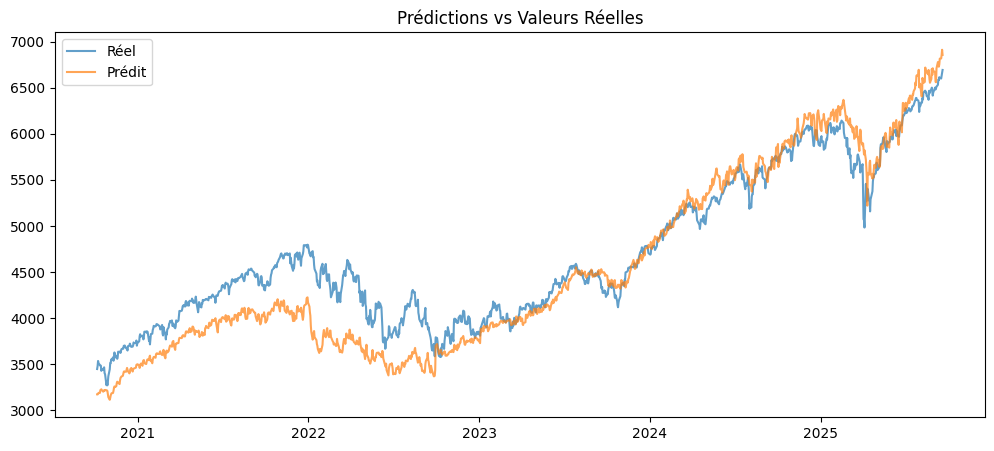

In [88]:
dd = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd.index, dd['cible'], label='Réel', alpha=0.7)
plt.plot(dd.index, dd['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

45 minutes
Paramètres initiaux : seq_len=30, units=200, batch=16 (val_loss=0.00013)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 250 (250 lignes)

📦 Bloc 250 → 500 (250 lignes)

📦 Bloc 500 → 750 (250 lignes)

📦 Bloc 750 → 1000 (250 lignes)

📦 Bloc 1000 → 1250 (250 lignes)

📦 Bloc 1250 → 1344 (94 lignes)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-26  2967.875414  3100.29
2020-06-29  2953.732421  3115.86
2020-06-30  2967.951628  3130.01
2020-07-01   2969.62475  3179.72
2020-07-02  2982.356976  3145.32

best_params (30, 200, 16, 1)

In [ ]:
import os, random, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Fixer la graine
# ======================
seed = 1759608945
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed utilisé : {seed}")

# ======================
# 2. Préparer les données
# ======================
df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_idx = df.columns.get_loc('cible')
n_features = df.shape[1]

# Split 80/20
train_size = int(len(df) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# n_features = X_train.shape[2] #train_data.shape[1]#df.shape[1]

# ======================
# 3. Fonctions utilitaires
# ======================
def create_sequences(data, seq_len, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_col_idx])
    return np.array(X), np.array(y)

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(seq_len, n_features)),
        # Dropout(0.2),
        # LSTM(units // 2, activation='relu', return_sequences=False),
        # Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        LSTM(units // 2, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        lstm_units = units // (2**i)
        if i == 0:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq,
                           input_shape=(seq_len, n_features)))
        else:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, layer_options, n_features):
    """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
    best_val_loss = float('inf')
    best_params = None
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    for n_layers in layer_options:
        for seq_len in seq_lens:
            X_train, y_train = create_sequences(train_data, seq_len, target_idx)
            if len(X_train) < 10:
                continue
            for units in units_list:
                for batch_size in batch_sizes:
                    model = build_model(seq_len, n_features, units, lr)
                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1,
                        callbacks=[early_stop]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = (seq_len, units, batch_size, n_layers)
    return best_params, best_val_loss

# ======================
# 4. Paramètres
# ======================
seq_lens = [10, 30]
units_list = [50, 100, 200]
batch_sizes = [16, 32] #max(8, len(X_train) // 50)
layer_options = [1, 2, 3]
learning_rate = 0.001
epochs = 500
block_size = 250  

validation_split = 0.4

# ======================
# 5. Entraînement initial
# ======================
print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

best_params, best_val_loss = find_best_hyperparams(
    train_data, seq_lens, units_list, batch_sizes,
    learning_rate, epochs, target_idx, layer_options, n_features
)
seq_len, units, batch_size, n_layers = best_params
print(f"Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

X_train, y_train = create_sequences(train_data, seq_len, target_idx)
model = build_model(seq_len, n_features, units, learning_rate, n_layers=n_layers)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 6. Boucle de mise à jour et prédiction progressive
# ======================
print("\n🔹 Début des prédictions progressives sur les 20% restants")

predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
n_test = len(test_data)

# On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
for step_start in range(0, n_test, block_size):
    step_end = min(step_start + block_size, n_test)
    print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

    # Préparation du bloc test
    X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
    if len(X_test) == 0:
        continue

    # --- Prédiction sur le bloc ---
    preds_scaled = model.predict(X_test, verbose=0).flatten()
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
    preds_full[:, target_idx] = preds_scaled
    preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

    global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
    predictions_df.loc[global_idx, 'prediction'] = preds_real
    predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

    # --- Mise à jour du train_data ---
    train_data = np.concatenate([
        train_data[block_size:] if len(train_data) > block_size else train_data,
        test_data[step_start:step_end]
    ])

    if (step_end - step_start) == block_size:
        # --- Nouvelle recherche d’hyperparamètres ---
        # best_params, best_val_loss = find_best_hyperparams(
        #     train_data, seq_lens, units_list, batch_sizes,
        #     learning_rate, epochs, target_idx, n_features
        # )
        # seq_len, units, batch_size = best_params
        # print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

        # --- Réentraînement du modèle mis à jour ---
    
        X_train, y_train = create_sequences(train_data, seq_len, target_idx)
        # model = build_model(seq_len, n_features, units, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=validation_split,
                callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 7. Résultat final
# ======================
print("\nSimulation terminée ✅")
print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl2.csv', sep='|')


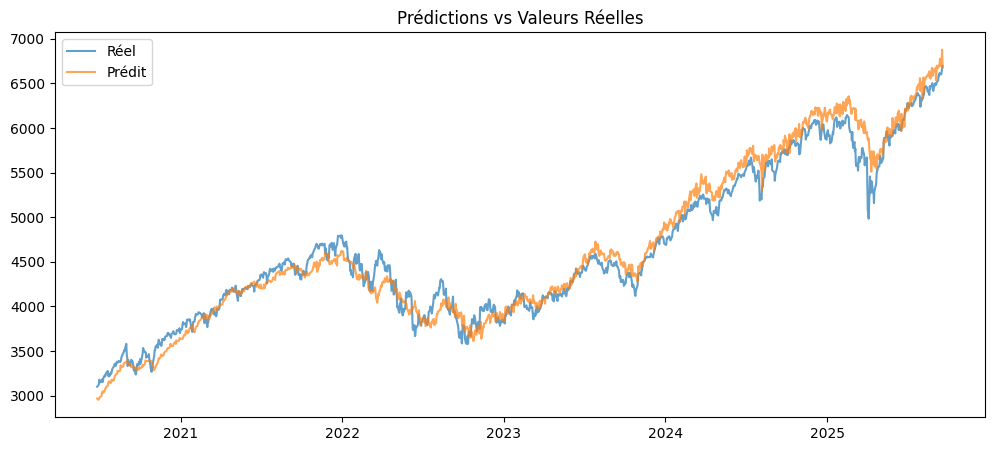

In [63]:
dd4 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd4.index, dd4['cible'], label='Réel', alpha=0.7)
plt.plot(dd4.index, dd4['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [45]:
print("X_train.shape:", X_train.shape)
print("n_features:", n_features)


X_train.shape: (5345, 30, 51)
n_features: 51


In [34]:
print(f"🔍 Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print("n_features =", n_features)

🔍 Shape X_train: (5345, 30, 51), y_train: (5345,)
n_features = 53


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Paramètres initiaux : seq_len=30, units=100, batch=32 (val_loss=0.00007)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 1000 (1000 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=30, units=200, batch=16 (val_loss=0.00021)

📦 Bloc 1000 → 1344 (344 lignes)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-26  2891.269912  3100.29
2020-06-29  2859.269165  3115.86
2020-06-30  2877.330635  3130.01
2020-07-01  2893.893827  3179.72
2020-07-02   2936.83335  3145.32

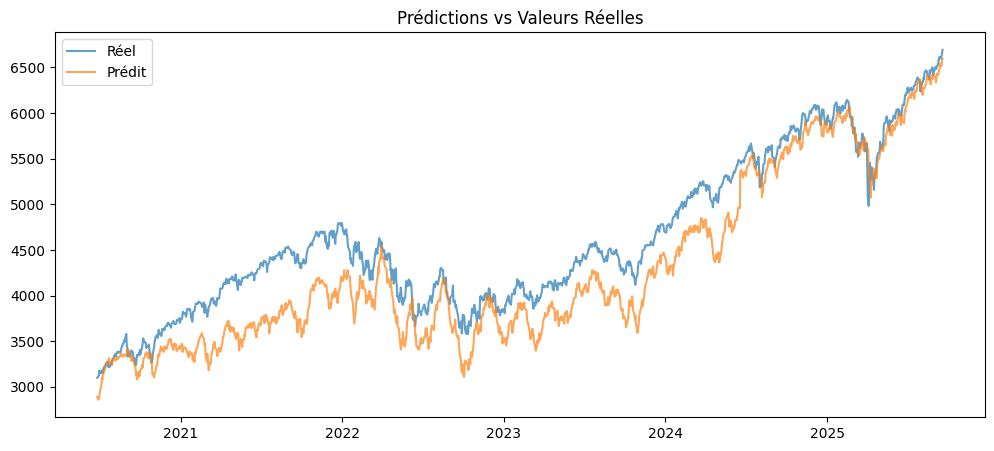

In [10]:
dd4 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd4.index, dd4['cible'], label='Réel', alpha=0.7)
plt.plot(dd4.index, dd4['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [161]:
# import os, random, time
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler

# # ======================
# # 1. Fixer la graine
# # ======================
# seed = 1759608945
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

# print(f"Seed utilisé : {seed}")

# # ======================
# # 2. Préparer les données
# # ======================
# df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(df)

# target_idx = df.columns.get_loc('cible')
# n_features = df.shape[1]

# # Split 80/20
# train_size = int(len(df) * 0.8)
# train_data = scaled_data[:train_size]
# test_data = scaled_data[train_size:]

# # ======================
# # 3. Fonctions utilitaires
# # ======================
# def create_sequences(data, seq_len, target_col_idx, forecast_horizon: int = 2):
#     X, y = [], []
#     for i in range(len(data) - seq_len - forecast_horizon +1):
#         X.append(data[i:i+seq_len])
#         y.append(data[i+seq_len + fh -1, target_col_idx])
#     return np.array(X), np.array(y)

# def build_model(seq_len, n_features, units, lr):
#     model = Sequential([
#         LSTM(units, activation='relu', input_shape=(seq_len, n_features)),
#         Dense(fh)
#     ])
#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
#     return model

# def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, n_features):
#     """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
#     best_val_loss = float('inf')
#     best_params = None
#     early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
    
#     for seq_len in seq_lens:
#         X_train, y_train = create_sequences(train_data, seq_len, target_idx)
#         if len(X_train) < 10:
#             continue
#         for units in units_list:
#             for batch_size in batch_sizes:
#                 model = build_model(seq_len, n_features, units, lr)
#                 history = model.fit(
#                     X_train, y_train,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     validation_split=0.2,
#                     verbose=0,
#                     callbacks=[early_stop]
#                 )
#                 val_loss = min(history.history['val_loss'])
#                 if val_loss < best_val_loss:
#                     best_val_loss = val_loss
#                     best_params = (seq_len, units, batch_size)
#     return best_params, best_val_loss

# # ======================
# # 4. Paramètres
# # ======================
# seq_lens = [10, 15, 30]
# units_list = [50, 100]
# batch_sizes = [16, 32]
# learning_rate = 0.001
# fh = 2 # forcast horizon
# epochs = 200
# block_size = 1000  # ⬅️ tu peux changer ici

# # ======================
# # 5. Entraînement initial
# # ======================
# print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

# best_params, best_val_loss = find_best_hyperparams(
#     train_data, seq_lens, units_list, batch_sizes,
#     learning_rate, epochs, target_idx, n_features
# )
# seq_len, units, batch_size = best_params
# print(f"✅ Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

# X_train, y_train = create_sequences(train_data, seq_len, target_idx)
# model = build_model(seq_len, n_features, units, learning_rate)
# model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
#           callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# # ======================
# # 6. Boucle de mise à jour et prédiction progressive
# # ======================
# print("\n🔹 Début des prédictions progressives sur les 20% restants")

# predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
# n_test = len(test_data)

# # On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
# for step_start in range(0, n_test, block_size):
#     step_end = min(step_start + block_size, n_test)
#     print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

#     # Préparation du bloc test
#     X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
#     if len(X_test) == 0:
#         continue

#     # --- Prédiction sur le bloc ---
#     preds_scaled = model.predict(X_test, verbose=0).flatten()
#     preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
#     preds_full[:, target_idx] = preds_scaled
#     preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

#     global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
#     predictions_df.loc[global_idx, 'prediction'] = preds_real
#     predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

#     # --- Mise à jour du train_data ---
#     train_data = np.concatenate([
#         train_data[block_size:] if len(train_data) > block_size else train_data,
#         test_data[step_start:step_end]
#     ])

#     # --- Nouvelle recherche d’hyperparamètres ---
#     best_params, best_val_loss = find_best_hyperparams(
#         train_data, seq_lens, units_list, batch_sizes,
#         learning_rate, epochs, target_idx, n_features
#     )
#     seq_len, units, batch_size = best_params
#     print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

#     # --- Réentraînement du modèle mis à jour ---
#     X_train, y_train = create_sequences(train_data, seq_len, target_idx)
#     model = build_model(seq_len, n_features, units, learning_rate)
#     model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
#               callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# # ======================
# # 7. Résultat final
# # ======================
# print("\nSimulation terminée ✅")
# print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl.csv', sep='|')


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
✅ Paramètres initiaux : seq_len=15, units=100, batch=32 (val_loss=0.00009)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 500 (500 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=10, units=50, batch=32 (val_loss=0.00009)

📦 Bloc 500 → 1000 (500 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=10, units=50, batch=16 (val_loss=0.00013)

📦 Bloc 1000 → 1344 (344 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=30, units=100, batch=32 (val_loss=0.00017)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-05  3165.629124  3207.18
2020-06-08  3134.333312  3190.14
2020-06-09  3139.092475   3002.1
2020-06-10    3013.9216  3041.31
2020-06-11  3023.106377  3066.59

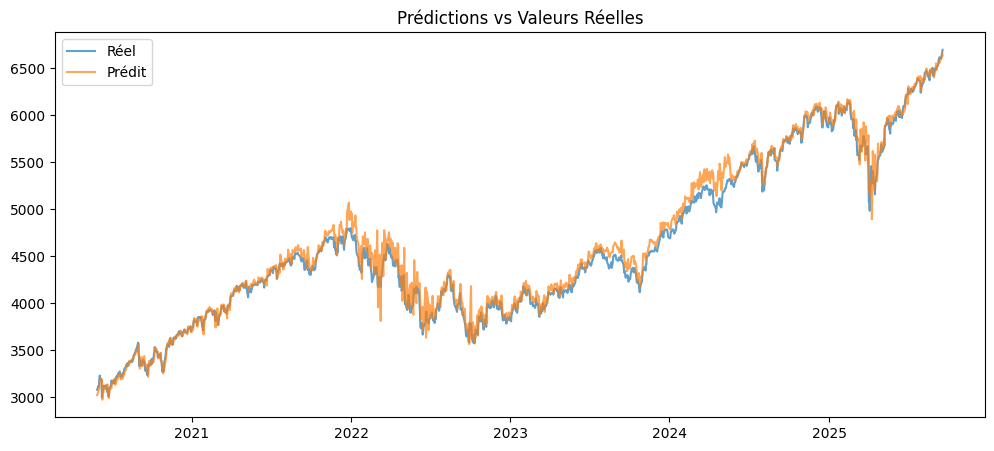

In [160]:
dd3 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd3.index, dd3['cible'], label='Réel', alpha=0.7)
plt.plot(dd3.index, dd3['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

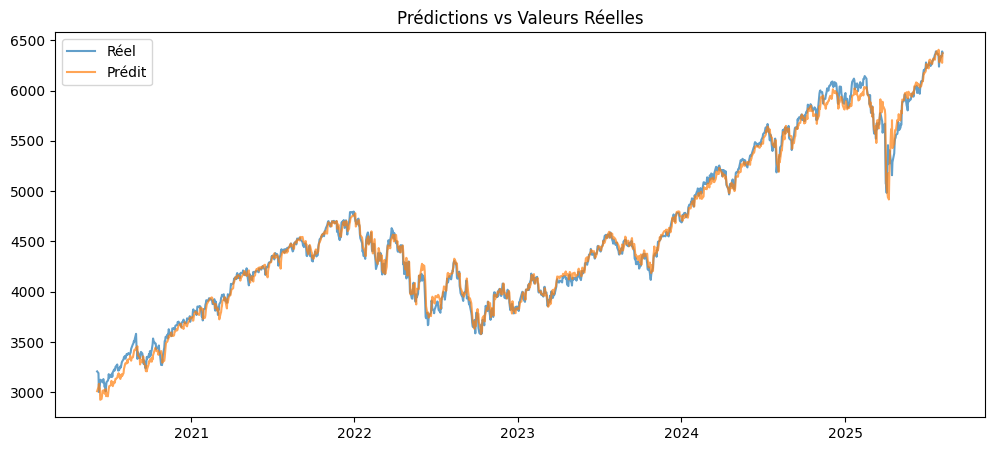

In [ ]:
# dd1 = dd.copy()
plt.figure(figsize=(12,5))
plt.plot(dd1.index, dd1['cible'], label='Réel', alpha=0.7)
plt.plot(dd1.index, dd1['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

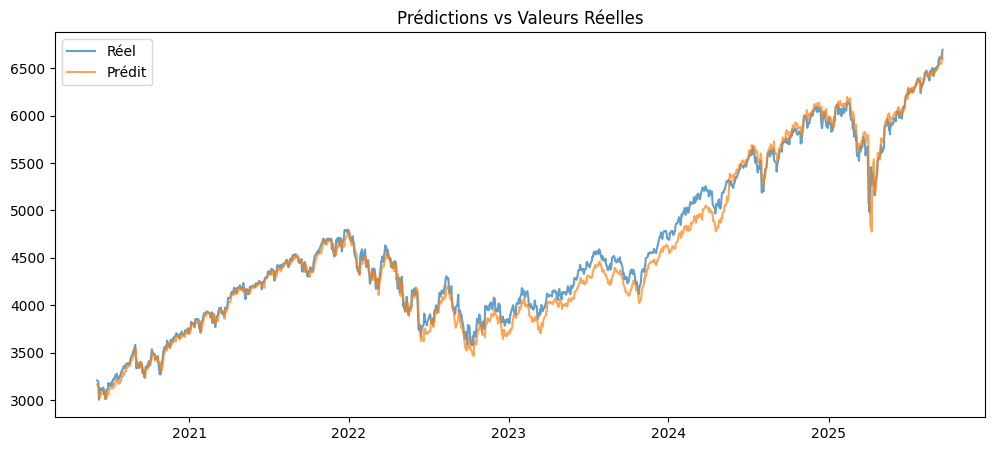

In [ ]:
# dd2 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd2.index, dd2['cible'], label='Réel', alpha=0.7)
plt.plot(dd2.index, dd2['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()